# 0.0 Imports

## 0.1. Imports

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import random            as rd
import xgboost           as xgb
import scikitplot        as skplt
   
from matplotlib           import pyplot          as plt
from sklearn              import model_selection as ms 
from sklearn              import metrics         as m
from scikitplot           import metrics         as mt
from sklearn              import preprocessing   as pp
from scipy                import stats           as ss

from category_encoders    import OneHotEncoder
from IPython.core.display import HTML
from IPython.core.display import Image
from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta               import BorutaPy
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from lightgbm             import LGBMClassifier

import os
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

## 0.2. Helper Functions

### Models

In [2]:
def models_train(models, x_train, y_train, x_test, y_test, predict='predict', metric='regression', verbose=1):
    metrics = []
    for model in models:
        print(model.__class__.__name__)
        model.fit(x_train, y_train)
        if predict == 'predict':
            yhat = model.predict(x_test)
        elif predict == 'predict_proba':
            yhat = model.predict_proba(x_test)
            yhat = yhat[:, 1]
        
        if metric == 'regression':
            metrics.append(regression_metrics(model.__class__.__name__, y_test, yhat, verbose)) # type: ignore
        elif metric == 'multiClass':
            metrics.append(multi_class_metrics(model.__class__.__name__, y_test, yhat, verbose)) # type: ignore
        elif metric == 'binaryClass':
            metrics.append(ranking_class_metrics(model.__class__.__name__, y_test, yhat, verbose)) # type: ignore
            
    return pd.concat(metrics, ignore_index=True)

### Graphics

In [3]:
def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

In [4]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    plt.show()

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v    

In [6]:
def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

### Metricals

In [7]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [8]:
def regression_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T
    
    metrics = pd.concat([model,accdf,balanceddf,kappadf]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [9]:
def multi_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T
    
    #MAtthews Correlation
    mcc=m.matthews_corrcoef(y_val,yhat)
    mccdf=pd.DataFrame([mcc])    
    
    metrics = pd.concat([model,precisiondf,recalldf,f1df,mccdf]).T.reset_index()
    metrics.columns=['Index','Model','Precision Score','Recall Score','F1 Score','Matthew Correlation Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Precision Score: {}'.format(precision))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        print('Matthew Correlation Score: {}'.format(mcc))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [10]:
def ranking_class_metrics(model, y_val, yhat, verbose=1):
    model = pd.DataFrame([model], columns=['Model'])

    # AUC_ROC
    roc = m.roc_auc_score(y_val, yhat)
    rocdf = pd.DataFrame([roc], columns=['ROC AUC'])

    # topk Score
    knum = y_val.value_counts().count() - 1
    topk = m.top_k_accuracy_score(y_val, yhat, k=knum)
    topkdf = pd.DataFrame([topk], columns=['Top K Score'])

    metrics = pd.concat([model, rocdf, topkdf], axis=1)
    if verbose == 1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        # Classification Report
        print(m.classification_report(y_val, yhat))
        # Confusion Matrix
        mt.plot_confusion_matrix(y_val, yhat, normalize=False, figsize=(12, 12))

    return metrics.reset_index(drop=True)

In [11]:
def precision_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df[target].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

In [12]:
def recall_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df[target].cumsum()/df[target].sum()
    return df.loc[k,'recall_at_k']

In [13]:
def topK_performance(df,probas,response,perc):
    df_final_performance=pd.DataFrame()
    for i in probas:   
        for j in perc:
            k=int(np.floor(len(df)*j))

            df_tg=df.copy()
            target_total=df_tg[response].sum()
            df_tg['score']= i[:,1].tolist()
            df_tg=df_tg.sort_values('score',ascending=False)
            target_at_k=df_tg[response][:k].sum()
            target_perc=target_at_k/target_total

            precision=precision_at_k(df,i,response,j)
            recall=recall_at_k(df,i,response,j)

            df_temp = pd.DataFrame([{
                'Model': 'Model',
                'perc': j,
                'k': k,
                'precision': precision,
                'recall': recall,
                'target_total': target_total,
                'target_at_k': target_at_k,
                'perc_target': target_perc
            }])

            df_final_performance = pd.concat([df_final_performance, df_temp], ignore_index=True)
    return df_final_performance

### Database

In [14]:
# def pg_connect():
    
#     credentialsFile=open('../db/credentials.json')
#     credentials=json.load(credentialsFile)

#     db = pg_driver.connect(user = credentials['user'],
#                            password = credentials['password'],
#                            host = credentials['host'],
#                            port = credentials['port'],
#                            database=credentials['database'])
#     credentialsFile.close()
#     return db

In [15]:
# def pg_query(sql):

#     db = pg_connect()
#     query = db.prepare(sql)
#     result = query()
#     db.close()
#     return result

### Supress Notation

In [16]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### CrossValidation

In [17]:
def cross_validation(num_folds, modelName, model, x, y, metric):
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed) # type: ignore

    cv_rf_metrics_list = pd.DataFrame()

    i = 1

    for train_cv, val_cv in kfold.split(x, y):
        print('Fold Number {}/{}'.format(i, num_folds))

        x_train_fold = x.iloc[train_cv]
        y_train_fold = y.iloc[train_cv]

        x_val_fold = x.iloc[val_cv]
        y_val_fold = y.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        metric_result = metric('{} - {}/{}'.format(modelName, i, num_folds), y_val_fold, yhat_model, 0)
        cv_rf_metrics_list = pd.concat([cv_rf_metrics_list, metric_result], ignore_index=True)

        i += 1
    return cv_rf_metrics_list.reset_index(drop=True)

### Enconding

In [18]:
def frequency_enconding(df,column):
    enconding=(df.groupby(column).size())/len(df)
    return enconding

## 0.3. Data Summary

**Id**:Unique ID for the customer

**Gender**: Gender of the customer

**Age**: Age of the customer

**Driving License**: 0 : Customer does not have DL, 1 : Customer already has DL

**Region Code**: 	Unique code for the region of the customer

**Previously Insured**: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

**Vehicle Age**: Age of the Vehicle

**Vehicle Damage**: 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Anual Premium**: 	The amount customer needs to pay as premium in the year

**Policy sales channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage**: Number of Days, Customer has been associated with the company

**Response**: 1 : Customer is interested, 0 : Customer is not interested

## 0.4. Data Load

In [19]:
# sqlFile=open('../db/loadFullData.sql')
# sql=sqlFile.read()

In [20]:
# result = pg_query(sql)
# sqlFile.close()

In [21]:
df_raw = pd.read_csv('../data/raw/train.csv')
new_columns = {
    'id': 'id',
    'Previously_Insured': 'previouslyInsured',
    'Annual_Premium': 'annualPremium',
    'Vintage': 'vintage',
    'Response': 'response',
    'Gender': 'gender',
    'Age': 'age',
    'Region_Code': 'regionCode',
    'Policy_Sales_Channel': 'policySalesChannel',
    'Driving_License': 'drivingLicense',
    'Vehicle_Age': 'vehicleAge',
    'Vehicle_Damage': 'vehicleDamage'
}

df_raw = df_raw.rename(columns=new_columns)

df_raw = df_raw[[
    'id',
    'previouslyInsured',
    'annualPremium',
    'vintage',
    'response',
    'gender',
    'age',
    'regionCode',
    'policySalesChannel',
    'drivingLicense',
    'vehicleAge',
    'vehicleDamage'
]]

In [22]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  381109 non-null  int64  
 1   previouslyInsured   381109 non-null  int64  
 2   annualPremium       381109 non-null  float64
 3   vintage             381109 non-null  int64  
 4   response            381109 non-null  int64  
 5   gender              381109 non-null  object 
 6   age                 381109 non-null  int64  
 7   regionCode          381109 non-null  float64
 8   policySalesChannel  381109 non-null  float64
 9   drivingLicense      381109 non-null  int64  
 10  vehicleAge          381109 non-null  object 
 11  vehicleDamage       381109 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [23]:
df_test=pd.read_csv('../data/raw/train.csv')
df_test.drop(columns=['Response'],inplace=True)
df_test.columns=['id','gender','age','drivingLicense','regionCode','previouslyInsured','vehicleAge','vehicleDamage','annualPremium','policySalesChannel','vintage']

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  381109 non-null  int64  
 1   gender              381109 non-null  object 
 2   age                 381109 non-null  int64  
 3   drivingLicense      381109 non-null  int64  
 4   regionCode          381109 non-null  float64
 5   previouslyInsured   381109 non-null  int64  
 6   vehicleAge          381109 non-null  object 
 7   vehicleDamage       381109 non-null  object 
 8   annualPremium       381109 non-null  float64
 9   policySalesChannel  381109 non-null  float64
 10  vintage             381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


In [25]:
seed = 77

# 1.0. Data Description

In [26]:
df_dd=df_raw.copy()

In [27]:
df_dd.sample(10)

id  previouslyInsured  annualPremium  vintage  response  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage
138444  138445                  0     38819.0000      281         0    Male   49     28.0000             52.0000               1   1-2 Year           Yes
225558  225559                  0      2630.0000      264         0  Female   30     33.0000            156.0000               1   1-2 Year           Yes
88636    88637                  0     39105.0000      186         1  Female   31      8.0000            156.0000               1   < 1 Year           Yes
225007  225008                  1     18949.0000      265         0    Male   26     10.0000            152.0000               1   < 1 Year            No
373435  373436                  1     35417.0000      223         0  Female   23     50.0000            152.0000               1   < 1 Year            No
132318  132319                  1     37118.0000      275         0  Female   21     28.0000            152.0000               1   < 1 Year            No
180340  180341                  1     21328.0000       95         0    Male   21     36.0000            152.0000               1   < 1 Year            No
85395    85396                  0     18126.0000      245         0    Male   36      3.0000            152.0000               1   1-2 Year           Yes
325278  325279                  0     33718.0000      120         0    Male   38     24.0000            124.0000               1   1-2 Year            No
154949  154950                  1     25628.0000      242         0  Female   54     18.0000            124.0000               1   1-2 Year            No

## <s>1.1. Rename Column<s>

## 1.2. Data Dimension

In [28]:
print('Total Rows: {}'.format(df_dd.shape[0]))
print('Total Columns: {}'.format(df_dd.shape[1]))

Total Rows: 381109
Total Columns: 12


## 1.3. Data Types

In [29]:
df_dd.dtypes

id                      int64
previouslyInsured       int64
annualPremium         float64
vintage                 int64
response                int64
gender                 object
age                     int64
regionCode            float64
policySalesChannel    float64
drivingLicense          int64
vehicleAge             object
vehicleDamage          object
dtype: object

## 1.4. Check NA

In [30]:
df_dd.isna().sum()

id                    0
previouslyInsured     0
annualPremium         0
vintage               0
response              0
gender                0
age                   0
regionCode            0
policySalesChannel    0
drivingLicense        0
vehicleAge            0
vehicleDamage         0
dtype: int64

## <s>1.5. Fill NA</s>
No one NA was detected

## 1.6. Check Balance Data

In [31]:
df_dd['response'].value_counts(normalize=True)

response
0   0.8774
1   0.1226
Name: proportion, dtype: float64

About 12,26% of all customers have interest on vehicle insurance

## 1.7. Statistical Description

In [32]:
numerical_columns=df_dd.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_columns=df_dd.select_dtypes(exclude=['int64','float64']).columns.tolist()

### 1.7.1. Numerical Attributes

In [33]:
na_resume=numerical_metrics(df_dd[numerical_columns])
na_resume

Attributes       Min         Max       Range        Mean      Median         STD     Skew  Kurtosis
0                  id    1.0000 381109.0000 381108.0000 190555.0000 190555.0000 110016.6919   0.0000   -1.2000
1   previouslyInsured    0.0000      1.0000      1.0000      0.4582      0.0000      0.4983   0.1677   -1.9719
2       annualPremium 2630.0000 540165.0000 537535.0000  30564.3896  31669.0000  17213.1325   1.7661   34.0046
3             vintage   10.0000    299.0000    289.0000    154.3474    154.0000     83.6712   0.0030   -1.2007
4            response    0.0000      1.0000      1.0000      0.1226      0.0000      0.3279   2.3019    3.2988
5                 age   20.0000     85.0000     65.0000     38.8226     36.0000     15.5116   0.6725   -0.5657
6          regionCode    0.0000     52.0000     52.0000     26.3888     28.0000     13.2299  -0.1153   -0.8679
7  policySalesChannel    1.0000    163.0000    162.0000    112.0343    133.0000     54.2039  -0.9000   -0.9708
8      drivingLicense    0.0000      1.0000      1.0000      0.9979      1.0000      0.0461 -21.5952  464.3543

In [34]:
df_dd[numerical_columns].describe()

id  previouslyInsured  annualPremium     vintage    response         age  regionCode  policySalesChannel  drivingLicense
count 381109.0000        381109.0000    381109.0000 381109.0000 381109.0000 381109.0000 381109.0000         381109.0000     381109.0000
mean  190555.0000             0.4582     30564.3896    154.3474      0.1226     38.8226     26.3888            112.0343          0.9979
std   110016.8362             0.4983     17213.1551     83.6713      0.3279     15.5116     13.2299             54.2040          0.0461
min        1.0000             0.0000      2630.0000     10.0000      0.0000     20.0000      0.0000              1.0000          0.0000
25%    95278.0000             0.0000     24405.0000     82.0000      0.0000     25.0000     15.0000             29.0000          1.0000
50%   190555.0000             0.0000     31669.0000    154.0000      0.0000     36.0000     28.0000            133.0000          1.0000
75%   285832.0000             1.0000     39400.0000    227.0000      0.0000     49.0000     35.0000            152.0000          1.0000
max   381109.0000             1.0000    540165.0000    299.0000      1.0000     85.0000     52.0000            163.0000          1.0000

Most 50% of customer don't have vehicles insurance

Mean value of Health Insurance is about 30k

All customers have less 1 year on Insurance All, being 75% had 227 days

Most 75% of customers don't have interest to buy a vehicle insurance

Most customer are between 25 and 49 years old

Most 75% of customer have driver license

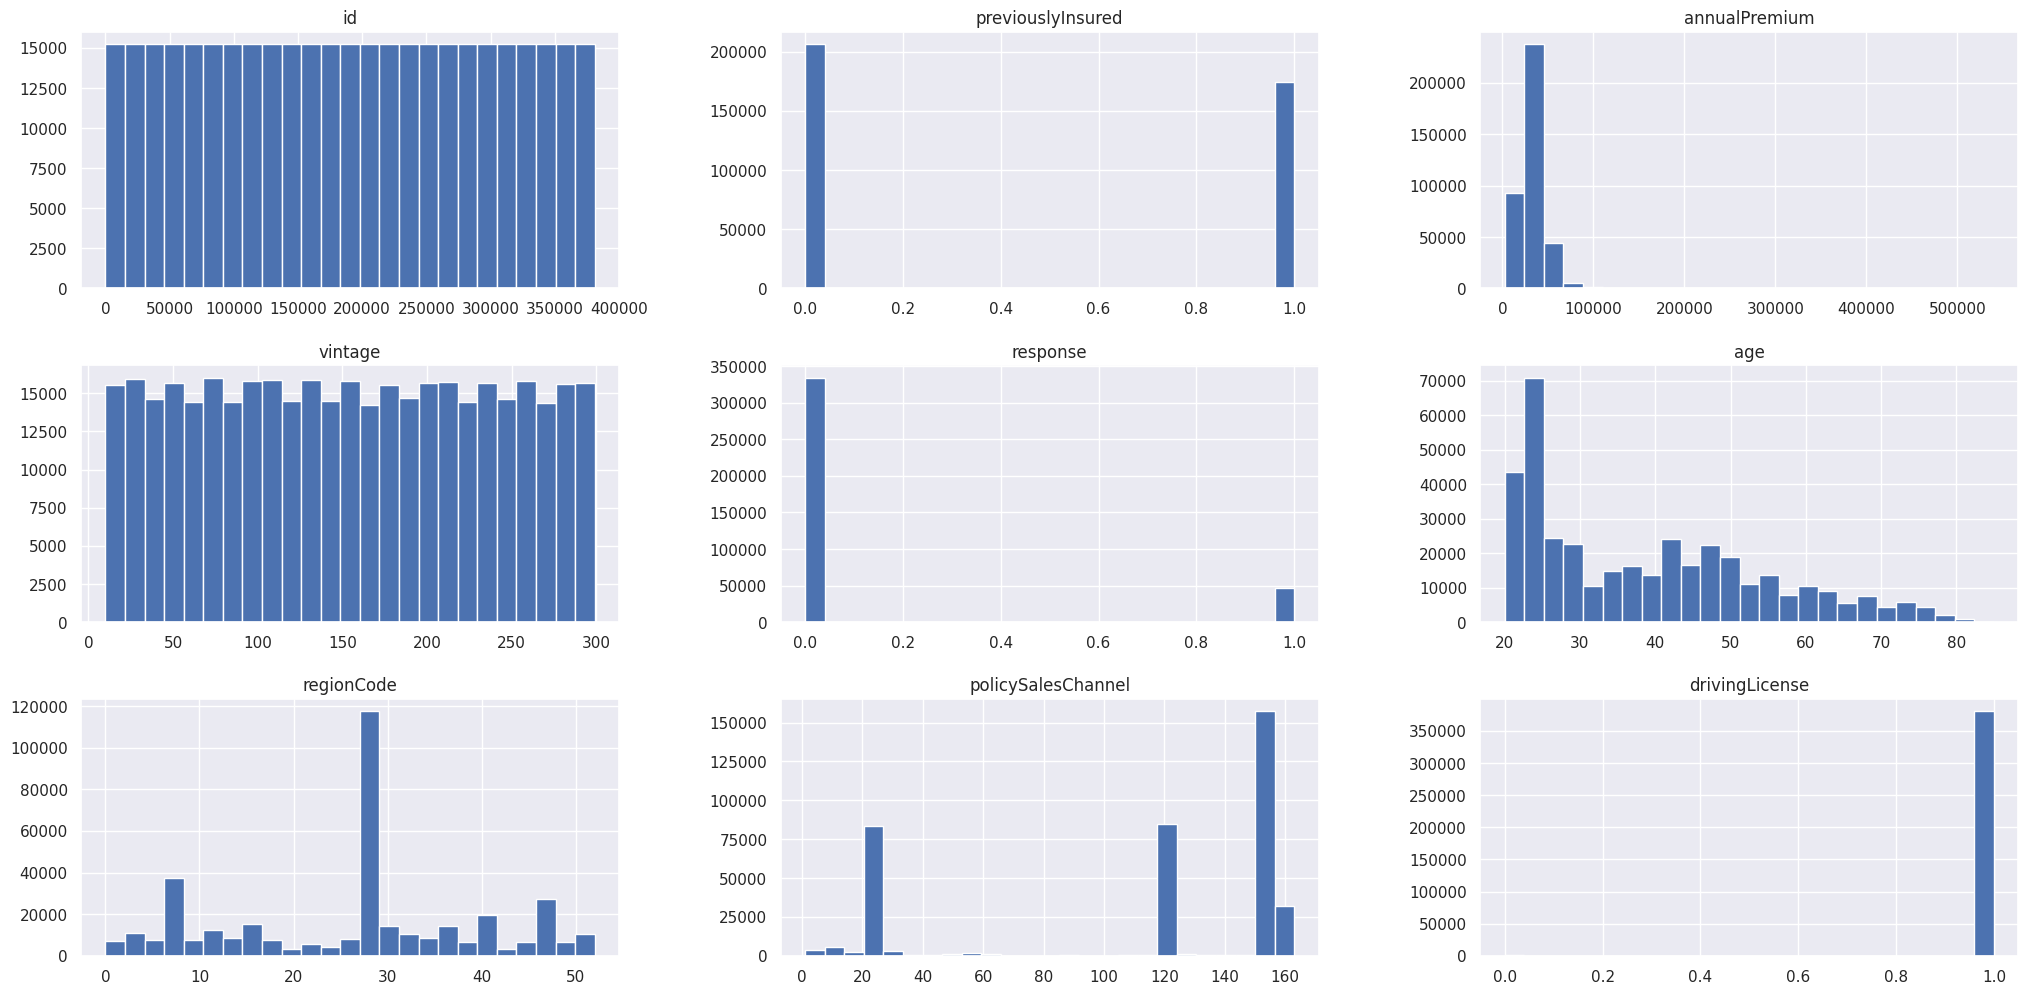

In [35]:
df_dd[numerical_columns].hist(bins=25);

In [36]:
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=seed)
for train_index, test_index in split.split(df_dd,df_dd['response']):
    df_aux = df_dd.loc[test_index]


In [37]:
df_aux['response'].value_counts(normalize=True)

response
0   0.8775
1   0.1225
Name: proportion, dtype: float64

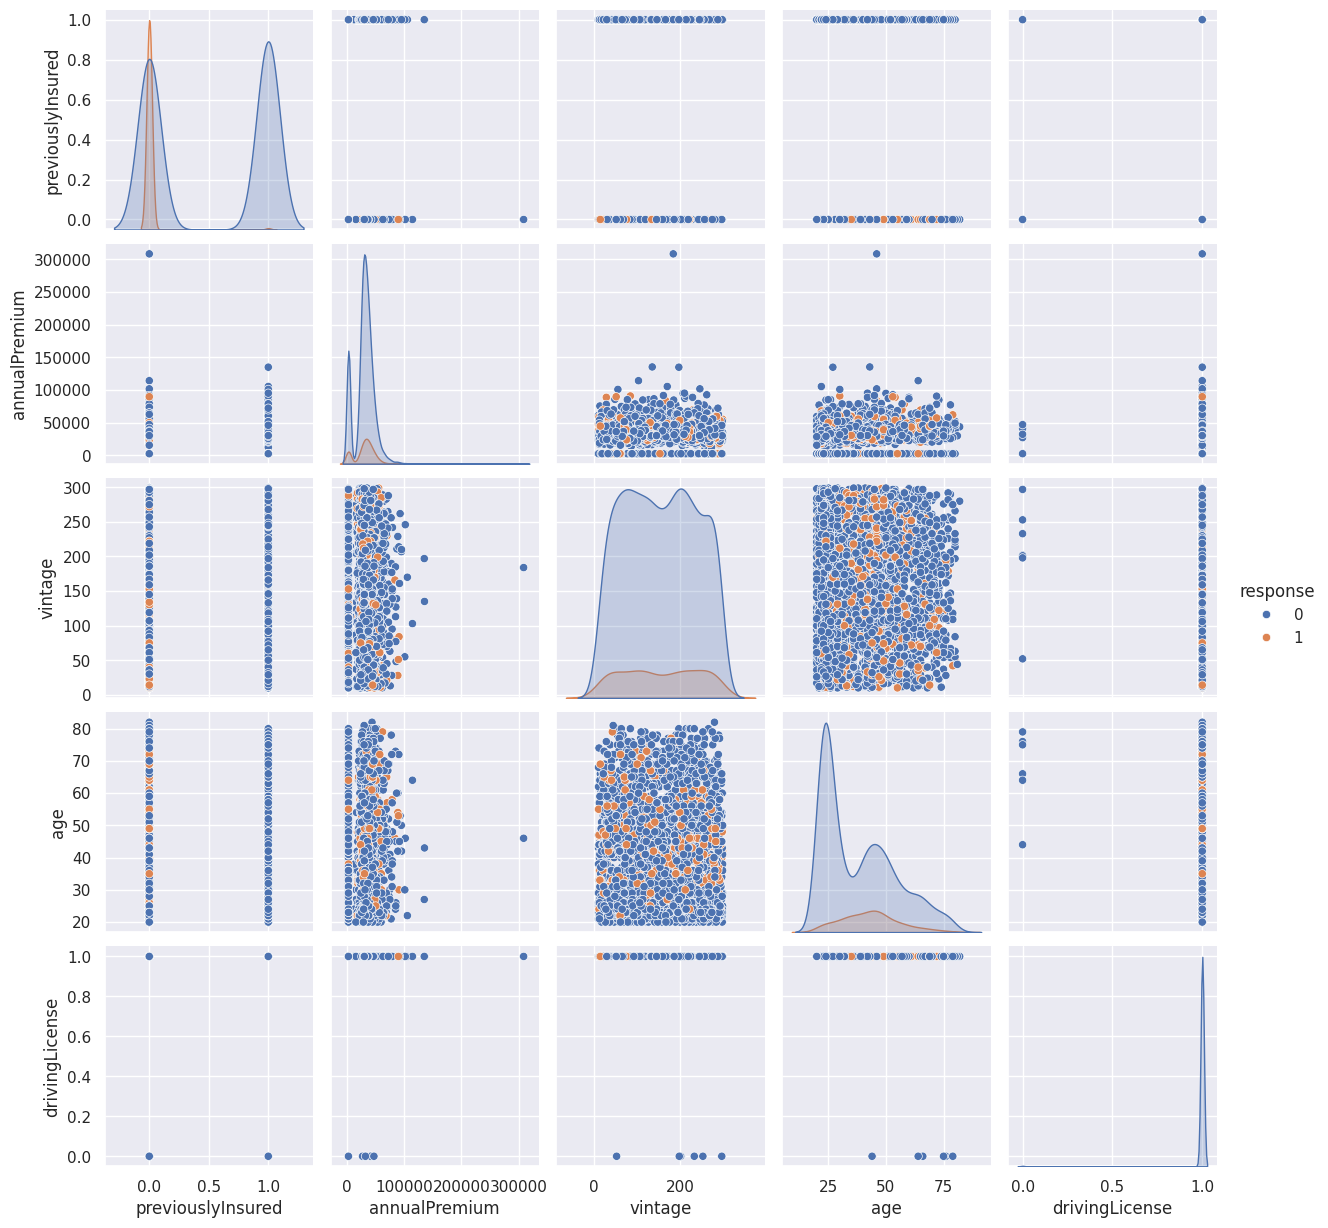

In [38]:
sns.pairplot(df_aux,vars=['previouslyInsured', 'annualPremium', 'vintage', 'age', 'drivingLicense'],hue='response');

### 1.7.2 Categorical Attributes

In [39]:
df_dd[categorical_columns].describe()

gender vehicleAge vehicleDamage
count   381109     381109        381109
unique       2          3             2
top       Male   1-2 Year           Yes
freq    206089     200316        192413

Most customer are Male

53 different regions

155 Policy Sales Channel

Most customers vehicles age is less 2 years

About 54% of customer has vehicles damage on past

In [40]:
df_dd[categorical_columns].apply(lambda x: x.unique().shape[0])

gender           2
vehicleAge       3
vehicleDamage    2
dtype: int64

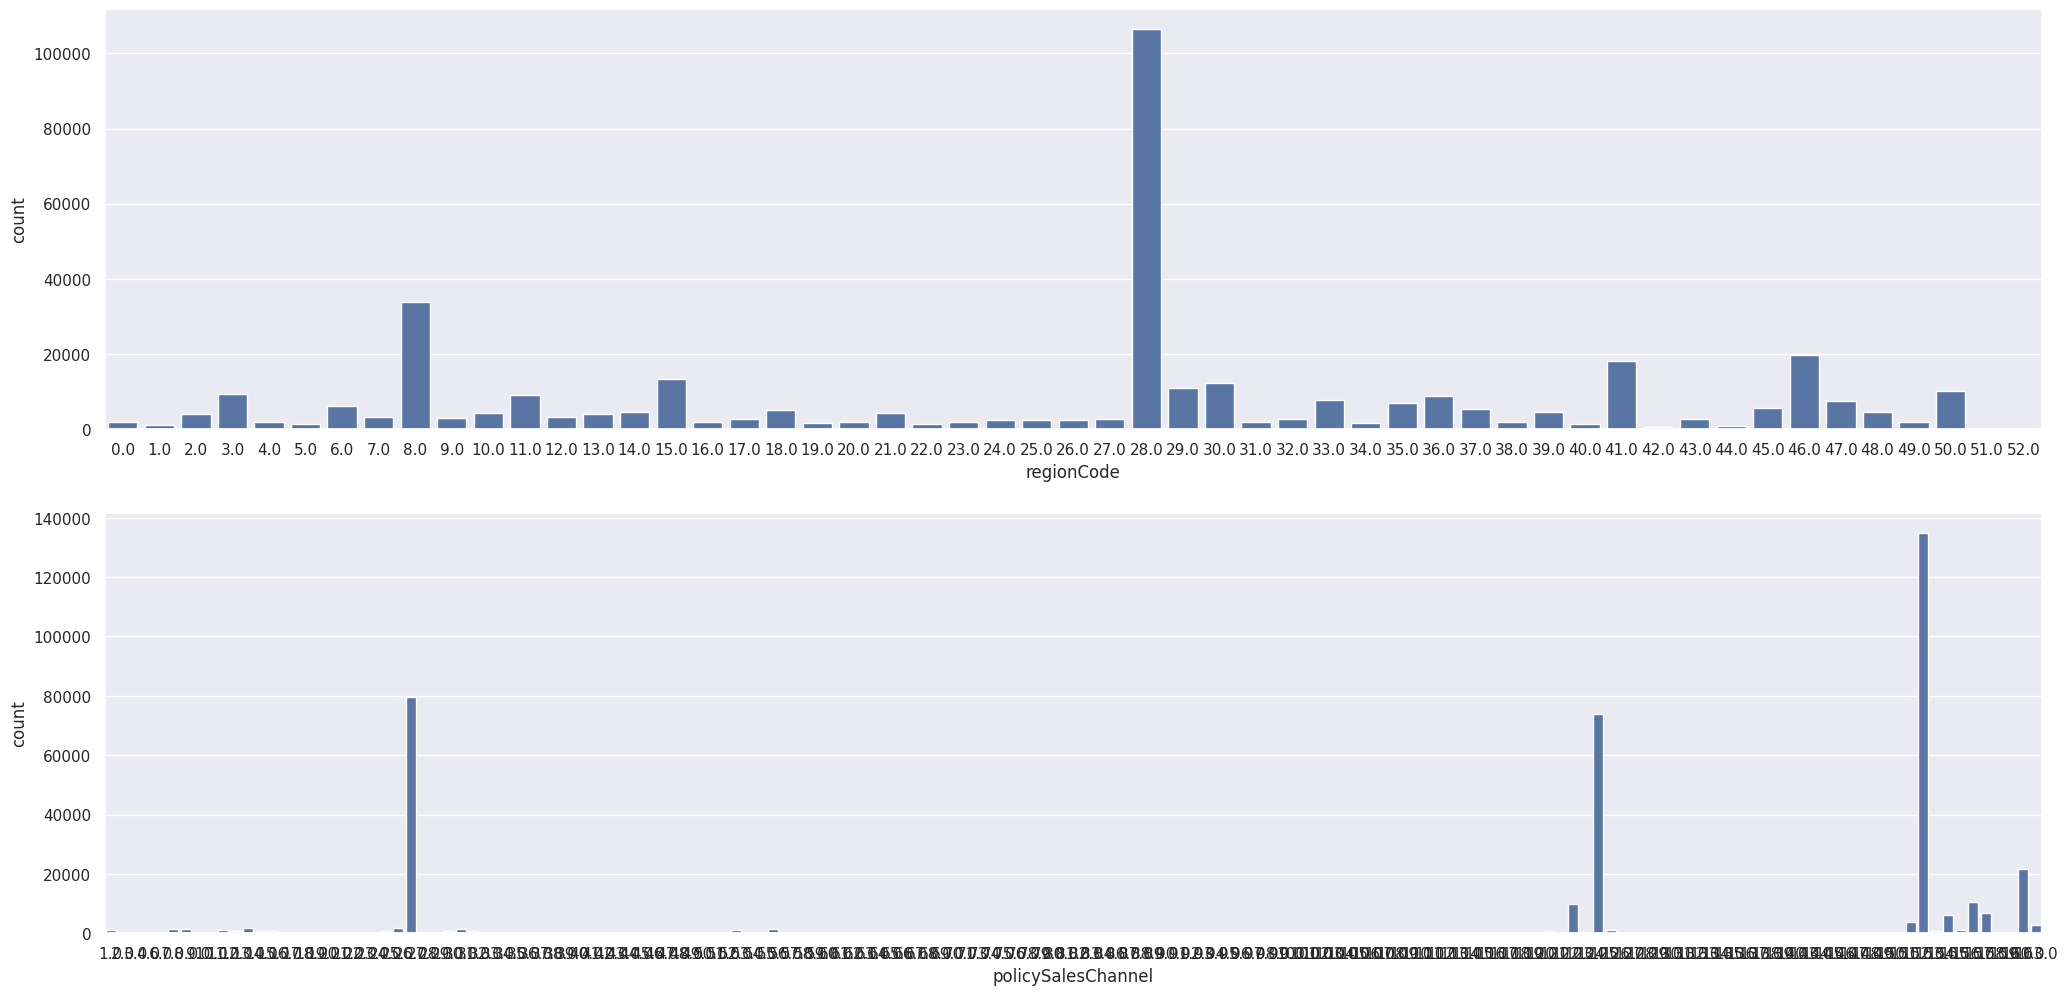

In [41]:
plt.subplot(2,1,1)
sns.countplot(x='regionCode',data=df_dd);

plt.subplot(2,1,2)
sns.countplot(x='policySalesChannel',data=df_dd);

# 2.0. Feature Engieneering

In [42]:
# Spliting test dataset before 
x=df_dd.drop(columns='response')
y=df_dd['response']
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, test_index in split.split(x,y):
    x_train,x_test = x.loc[train_index],x.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
for train_index, test_index in split.split(x_train,y_train):
    x_train,x_val = x_train.iloc[train_index],x.loc[test_index]
    y_train,y_val = y_train.iloc[train_index],y.loc[test_index]

In [43]:
df_fe=pd.concat([x_train,y_train],axis=1)

## 2.1. Business Search

**Features Relevant to Business Model**

Age

Years from driver license

Garage 

Security alarm

Historical Car's Damages, accidents and theft

Gender

Civil State

Car Model

City Risk

sources

https://blog.rodobens.com.br/perfil-no-seguro-auto



**Cross Selling Strategy**

Analyse products interesting to a customer

Dont try cross sell products more expensive then main



Sources:

https://resultadosdigitais.com.br/blog/cross-selling-up-selling/#:~:text=O%20cross%20selling%2C%20também%20chamado,oferta%20que%20o%20cliente%20adquiriu.

https://neilpatel.com/br/blog/cross-selling/


## 2.2. Hypotheses Map

**H1** - Women buy more vehicles insurance than men

**H2** - Customer with cars younger than 2 years old, have more interest on vehicle insurance

**H3** - Customer without driving license don't have interest in vehicles insurance

**H4** - Customers had damage Historical have more interest on vehicle insurance

**H5** - Customer older than 30 years old have more interest in vehicles insurance

**H6** - Customer that paid between 24405 a 39400 on Annual Premium have more interest in vehicles insurance

## 2.3. Feature Engieneering

In [44]:
def feature_Engieneering(df_fe):
    df_fe['riskAge']=df_fe['age'].apply(lambda x: 0 if x>25 else 1)    
    return  df_fe

In [45]:
df_fe=feature_Engieneering(df_fe)

In [46]:
numerical_columns=df_fe.select_dtypes(include=['int64','float64']).columns.tolist()

# 3.0. <s>Balance Data</s>

# 4.0. Exploratory Data Analysis

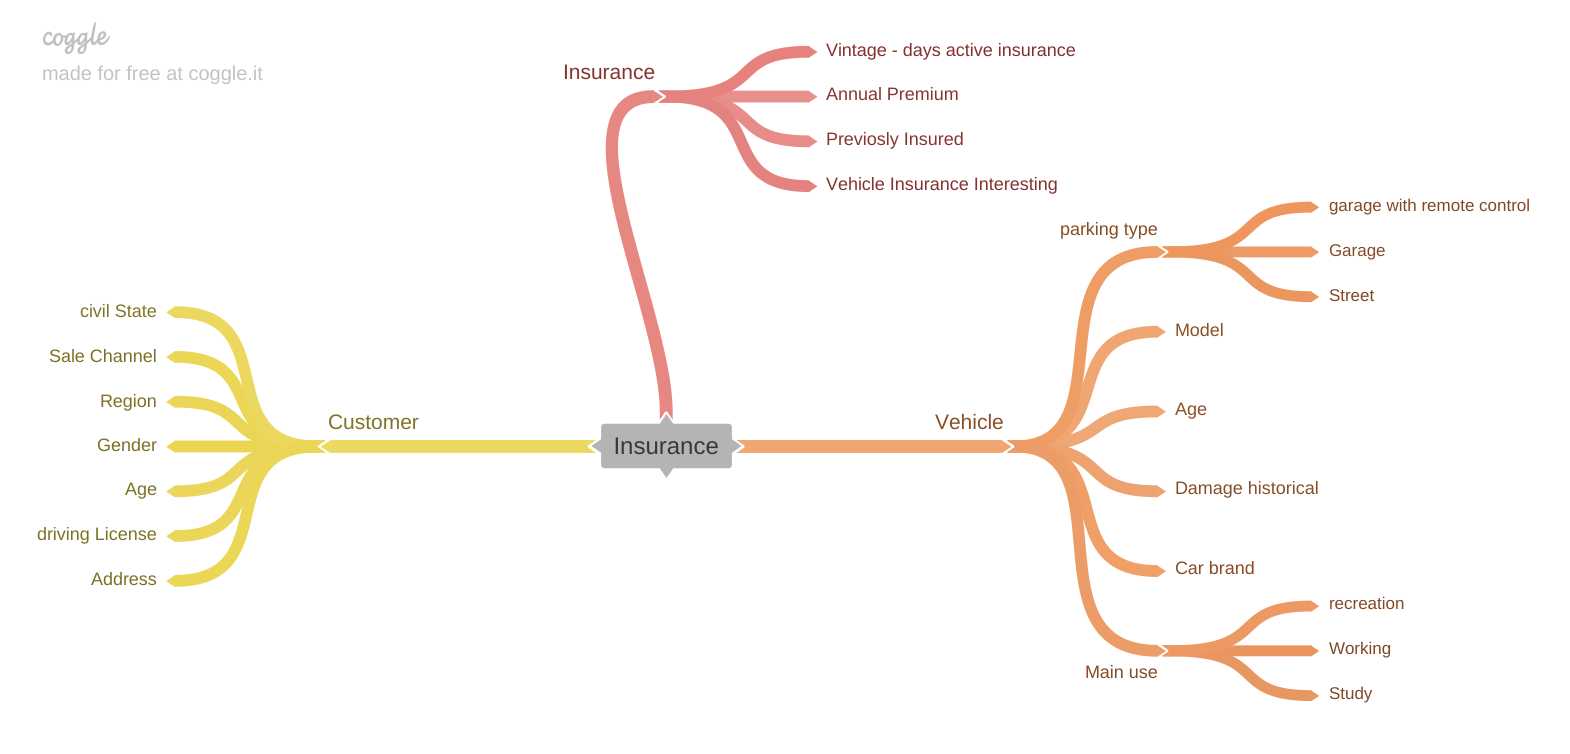

In [47]:
Image('../images/featuresMap.png')

In [48]:
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=77)
for train_index, test_index in split.split(df_fe,df_fe['response']):
    df_eda = df_fe.iloc[train_index]

## 4.1. Univariate Analysis

### 4.1.1. - Target Variable

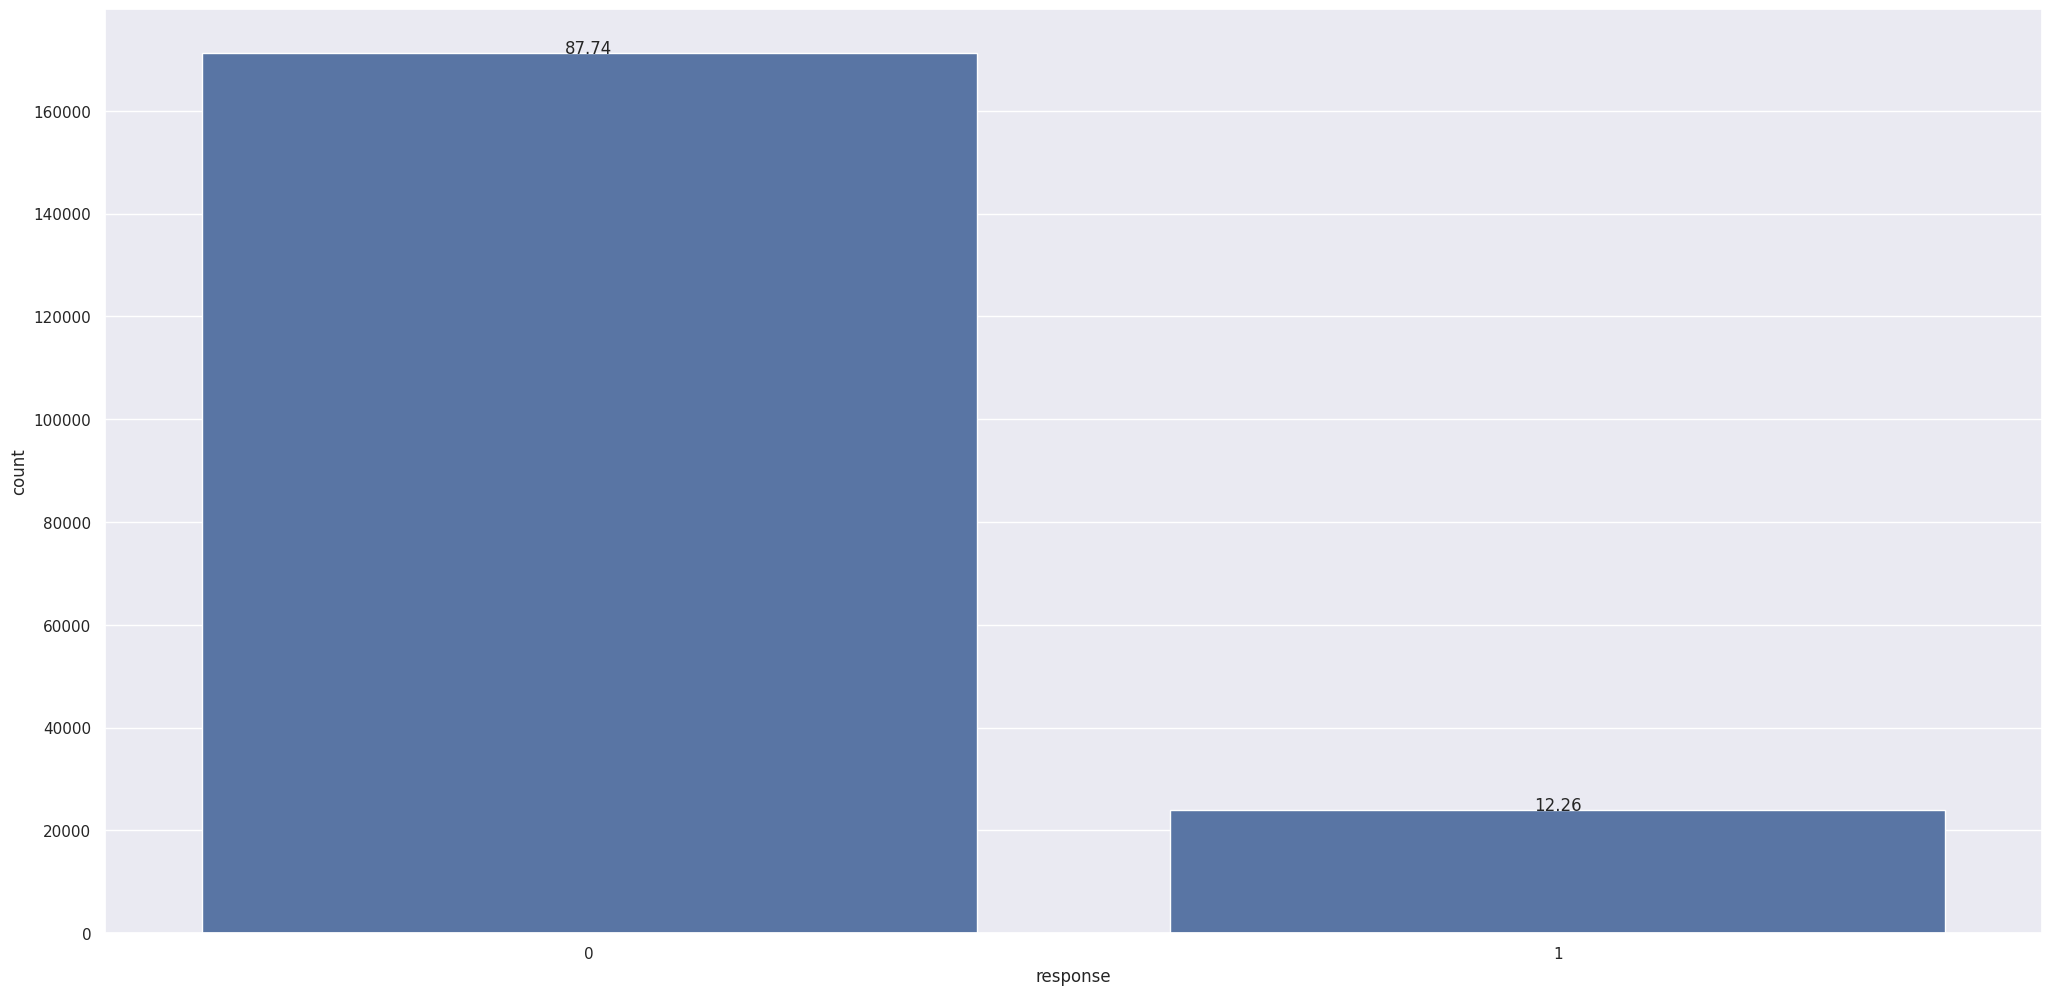

In [49]:
ax = sns.countplot(x='response', data=df_eda)
total = len(df_eda['response'])
graphic_percentage(ax, total)

### 4.1.2. - Numerical Variables

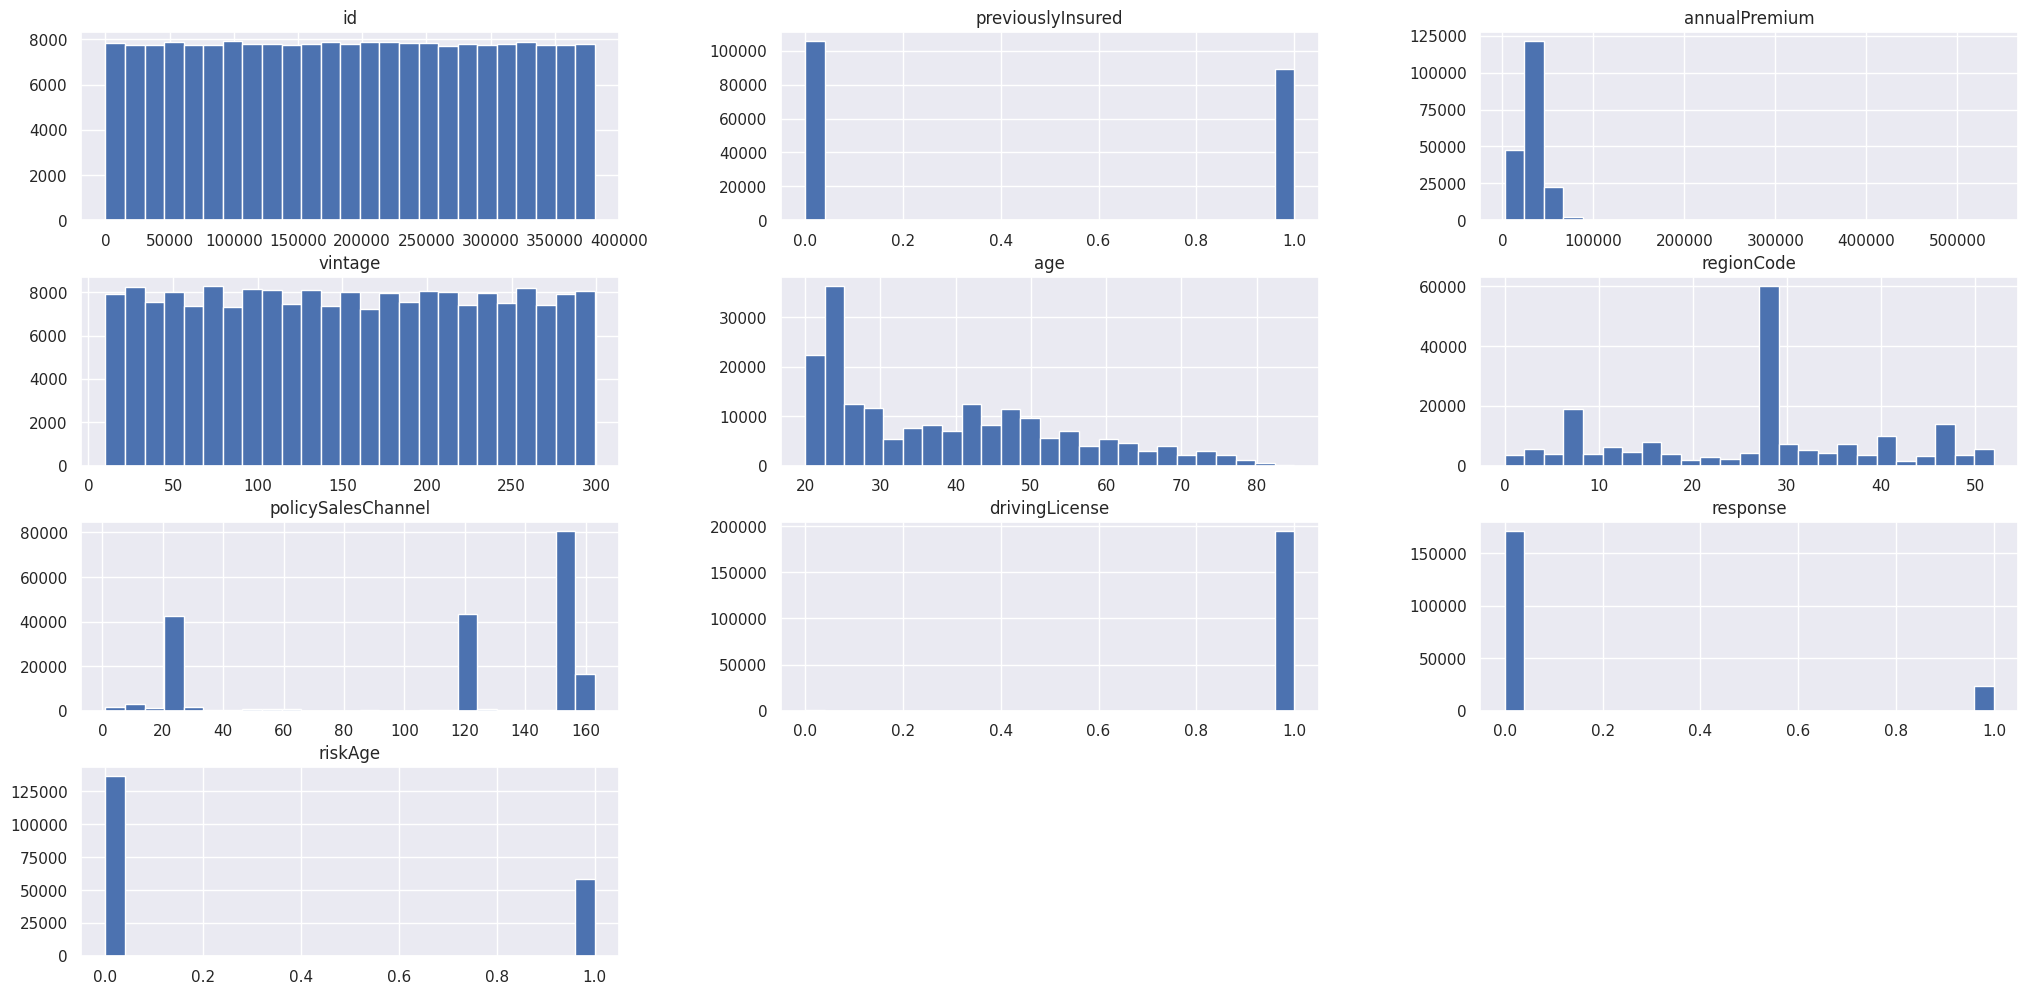

In [50]:
df_eda[numerical_columns].hist(bins=25);

#### Previosly Insured

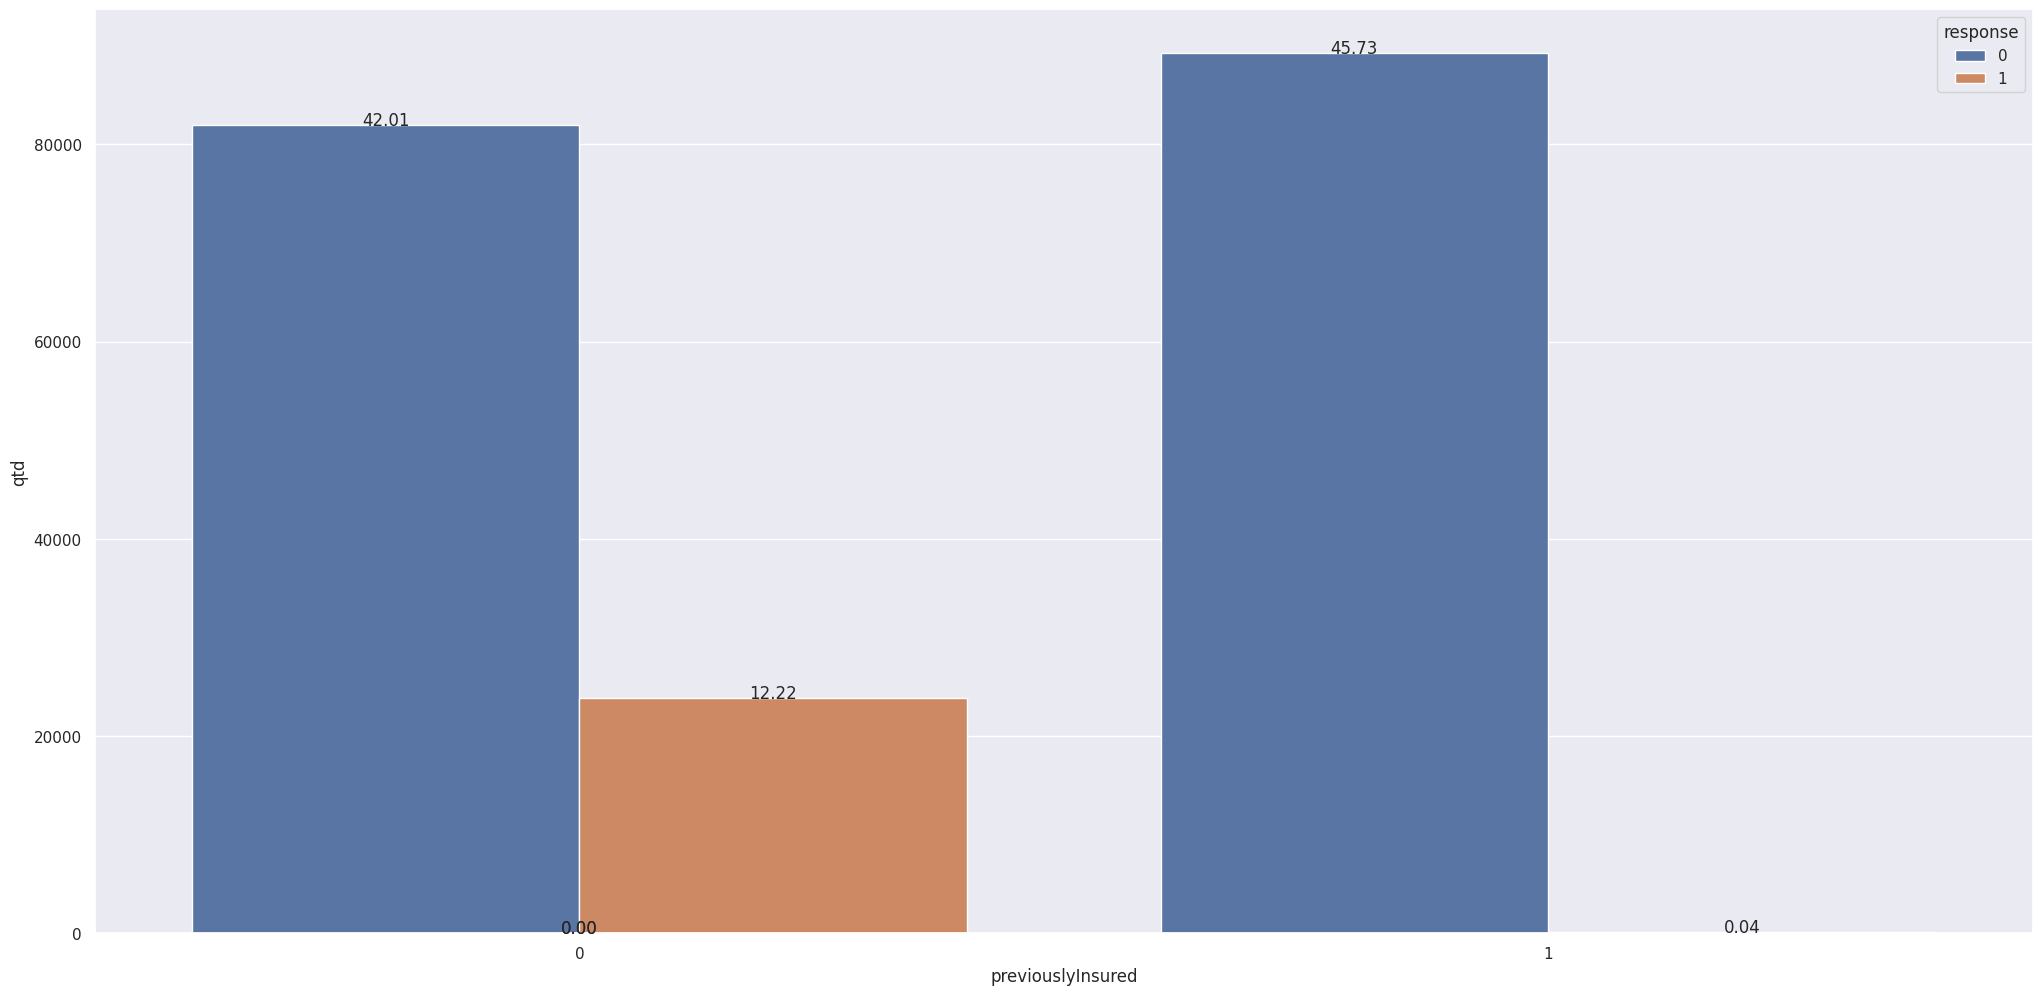

In [51]:
aux=df_eda[['previouslyInsured','response']].groupby(['previouslyInsured','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(x='previouslyInsured',y='qtd',data=aux,hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

#### Annual Premium

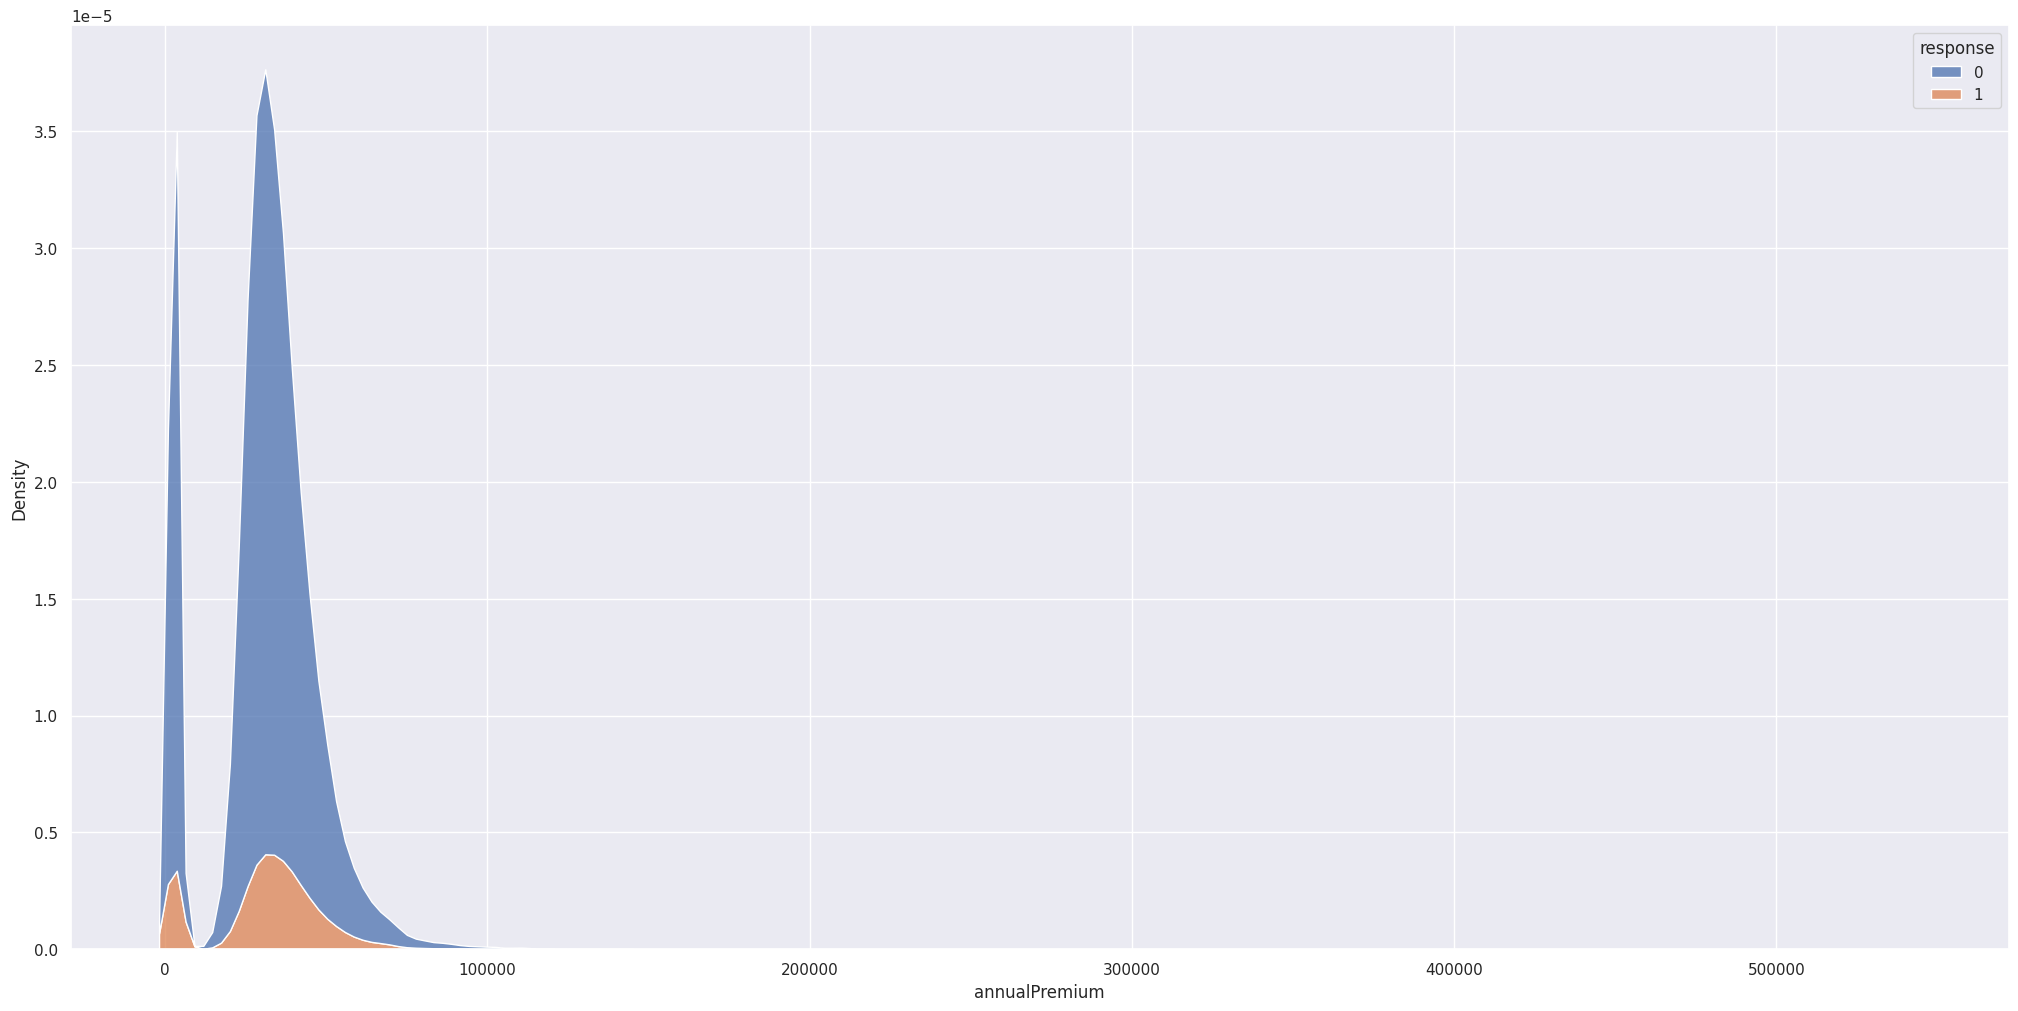

In [52]:
sns.kdeplot(x='annualPremium',data=df_eda,hue='response',multiple='stack');

#### Vintage

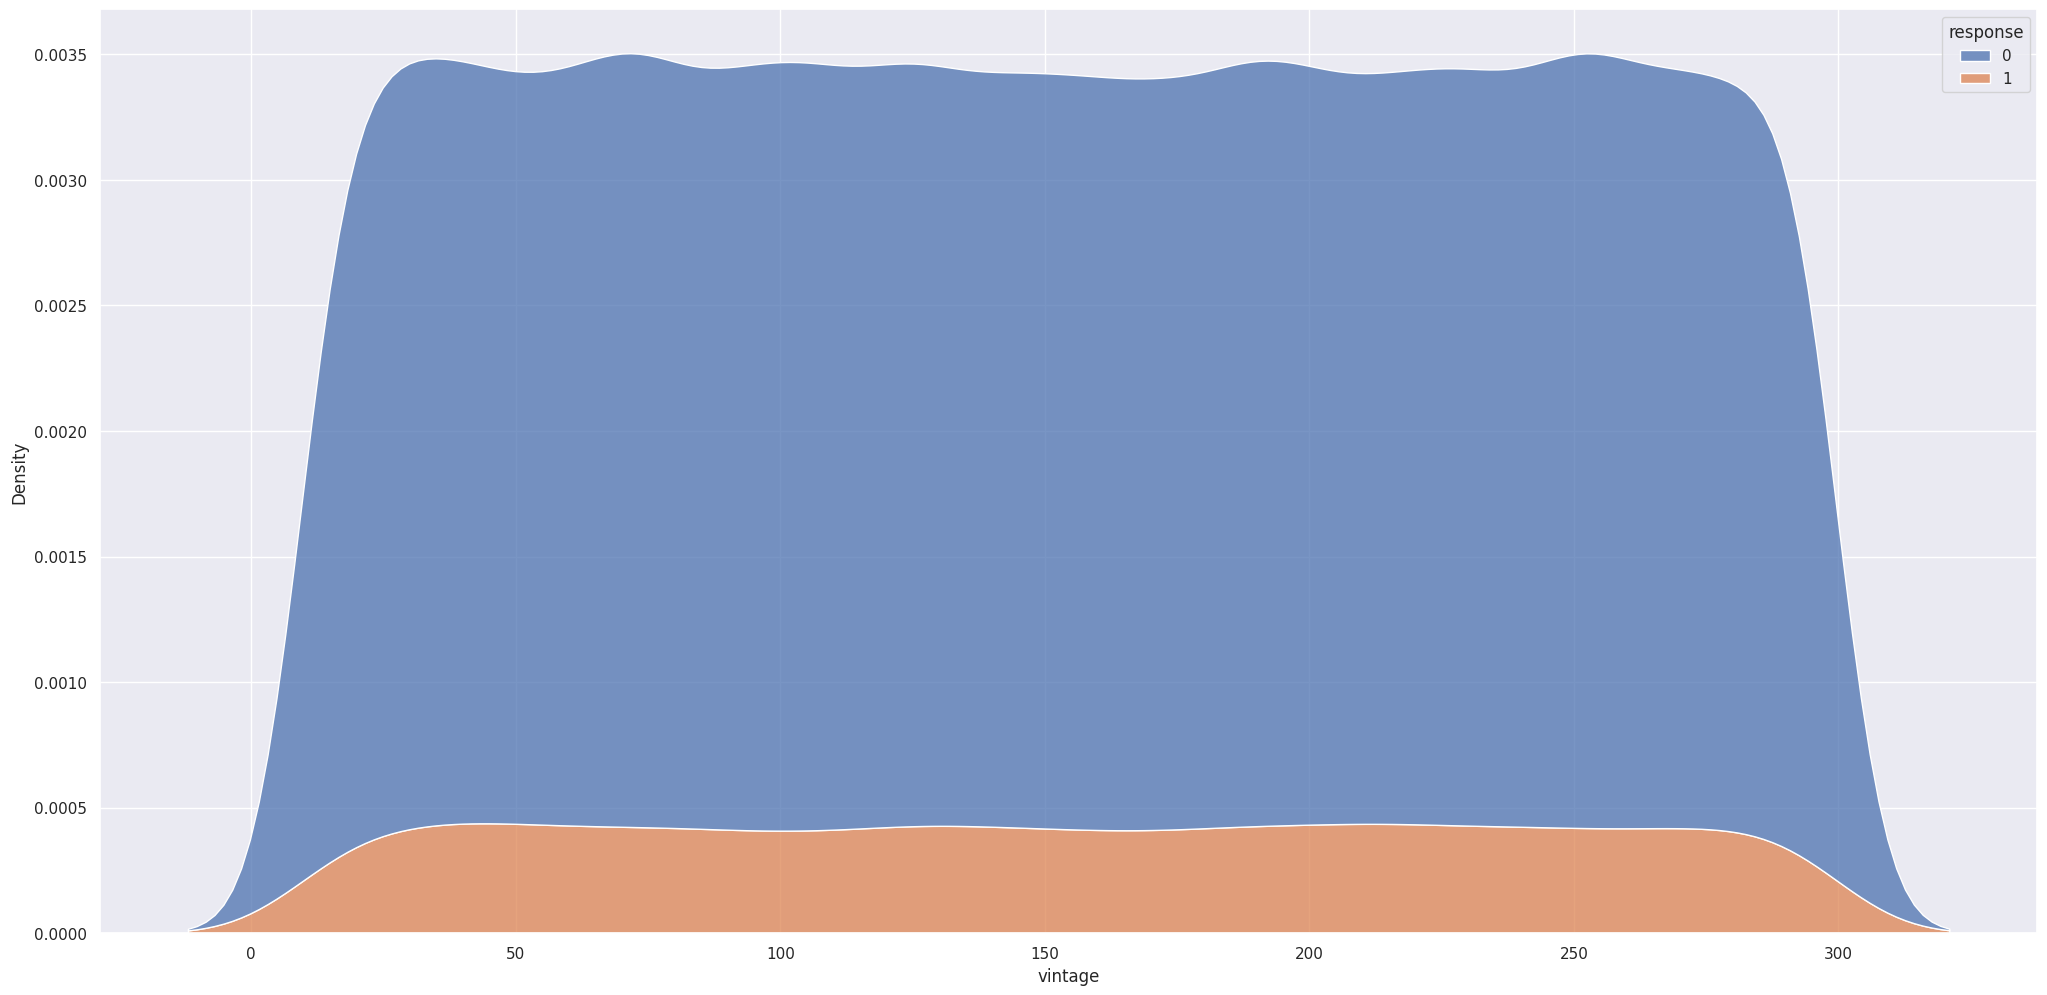

In [53]:
sns.kdeplot(x='vintage',data=df_eda,hue='response',multiple='stack');

#### Age

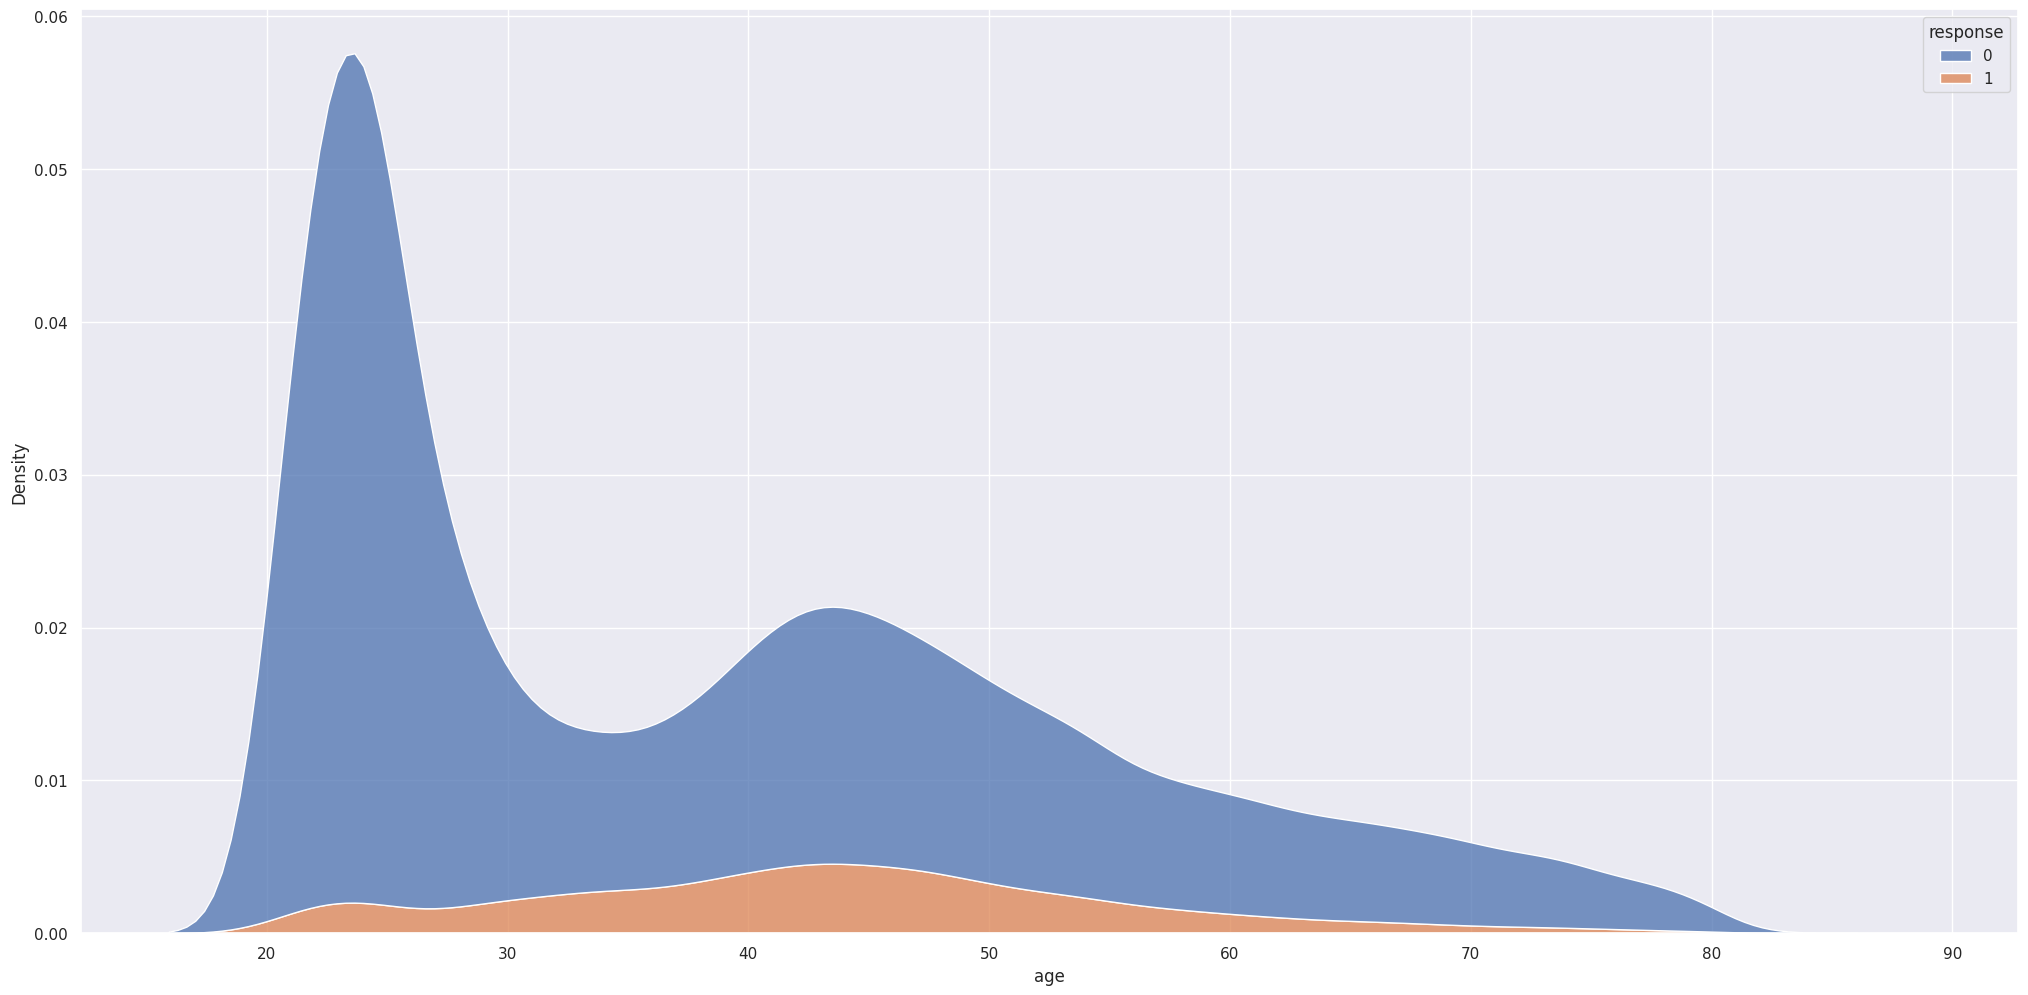

In [54]:
sns.kdeplot(x='age',data=df_eda,hue='response',multiple='stack');

#### Region Code

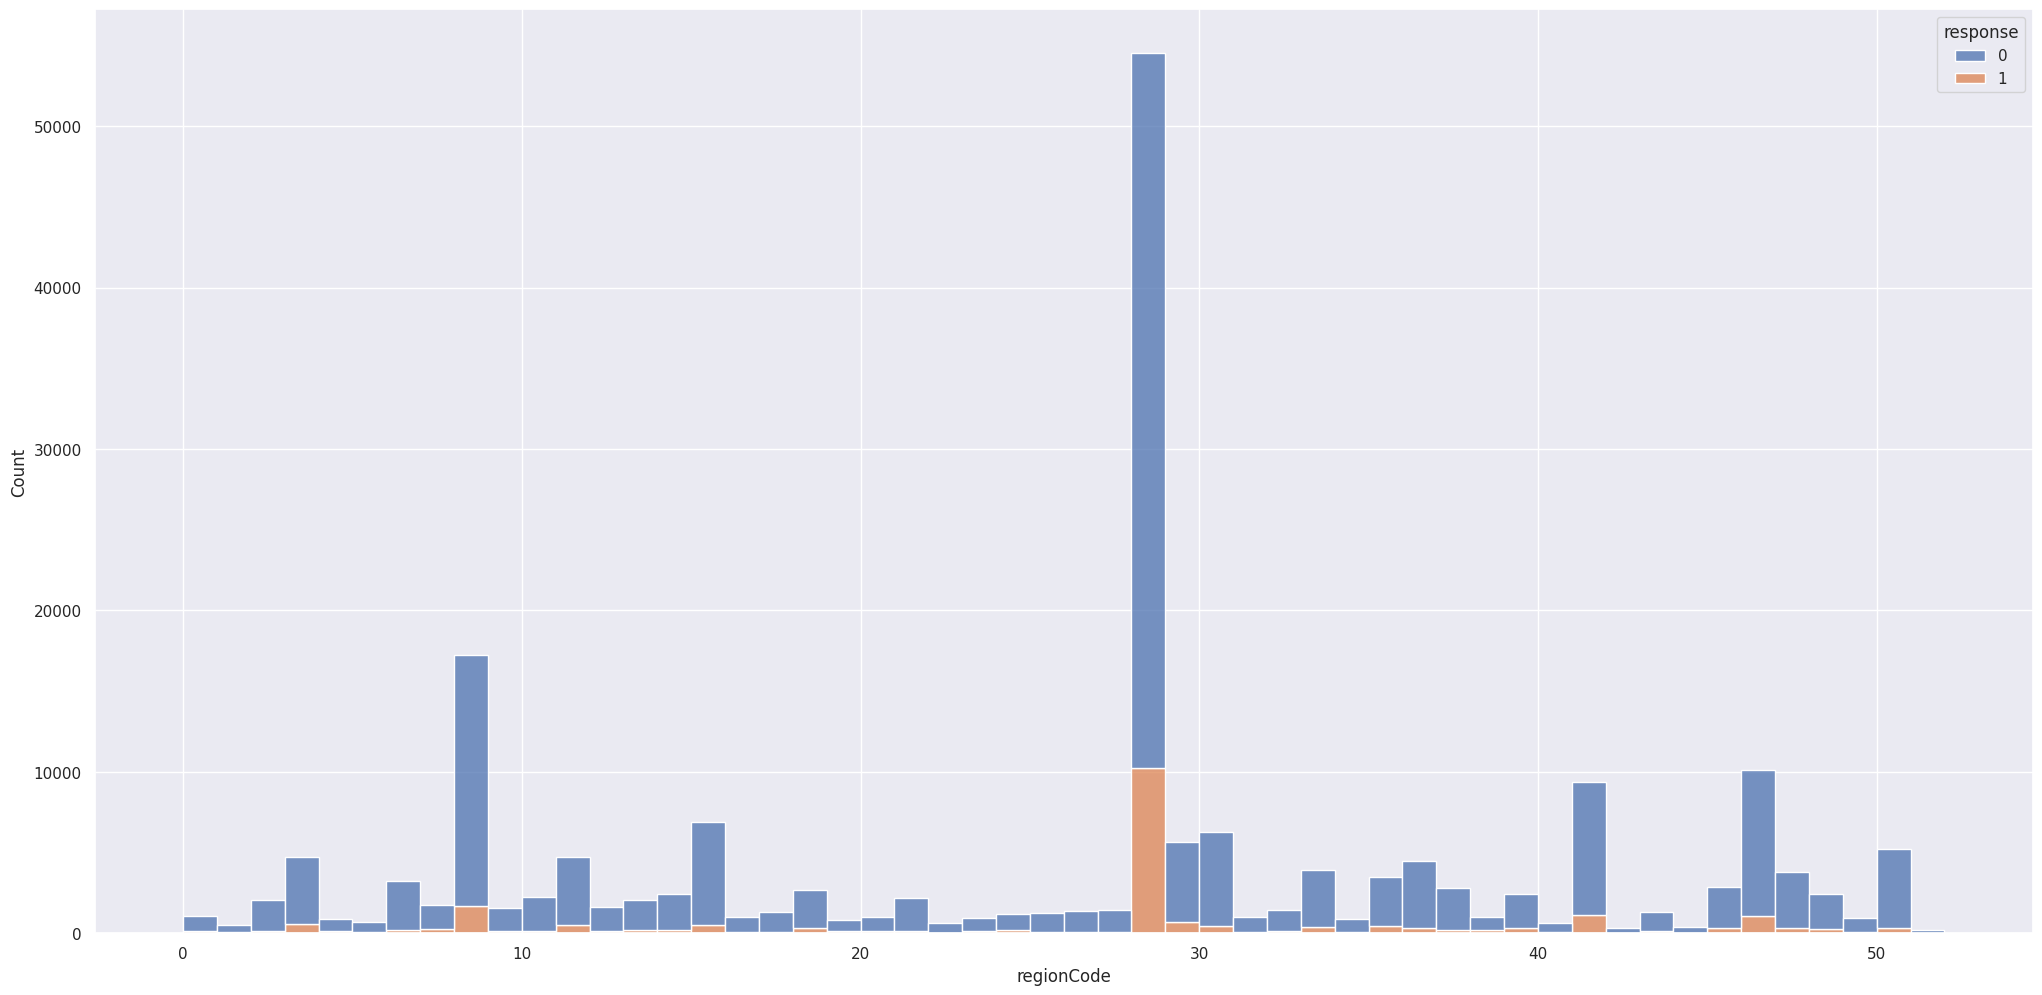

In [55]:
sns.histplot(data=df_eda, x='regionCode', hue='response', multiple='stack', binwidth=1);

#### Policy Sale Channel

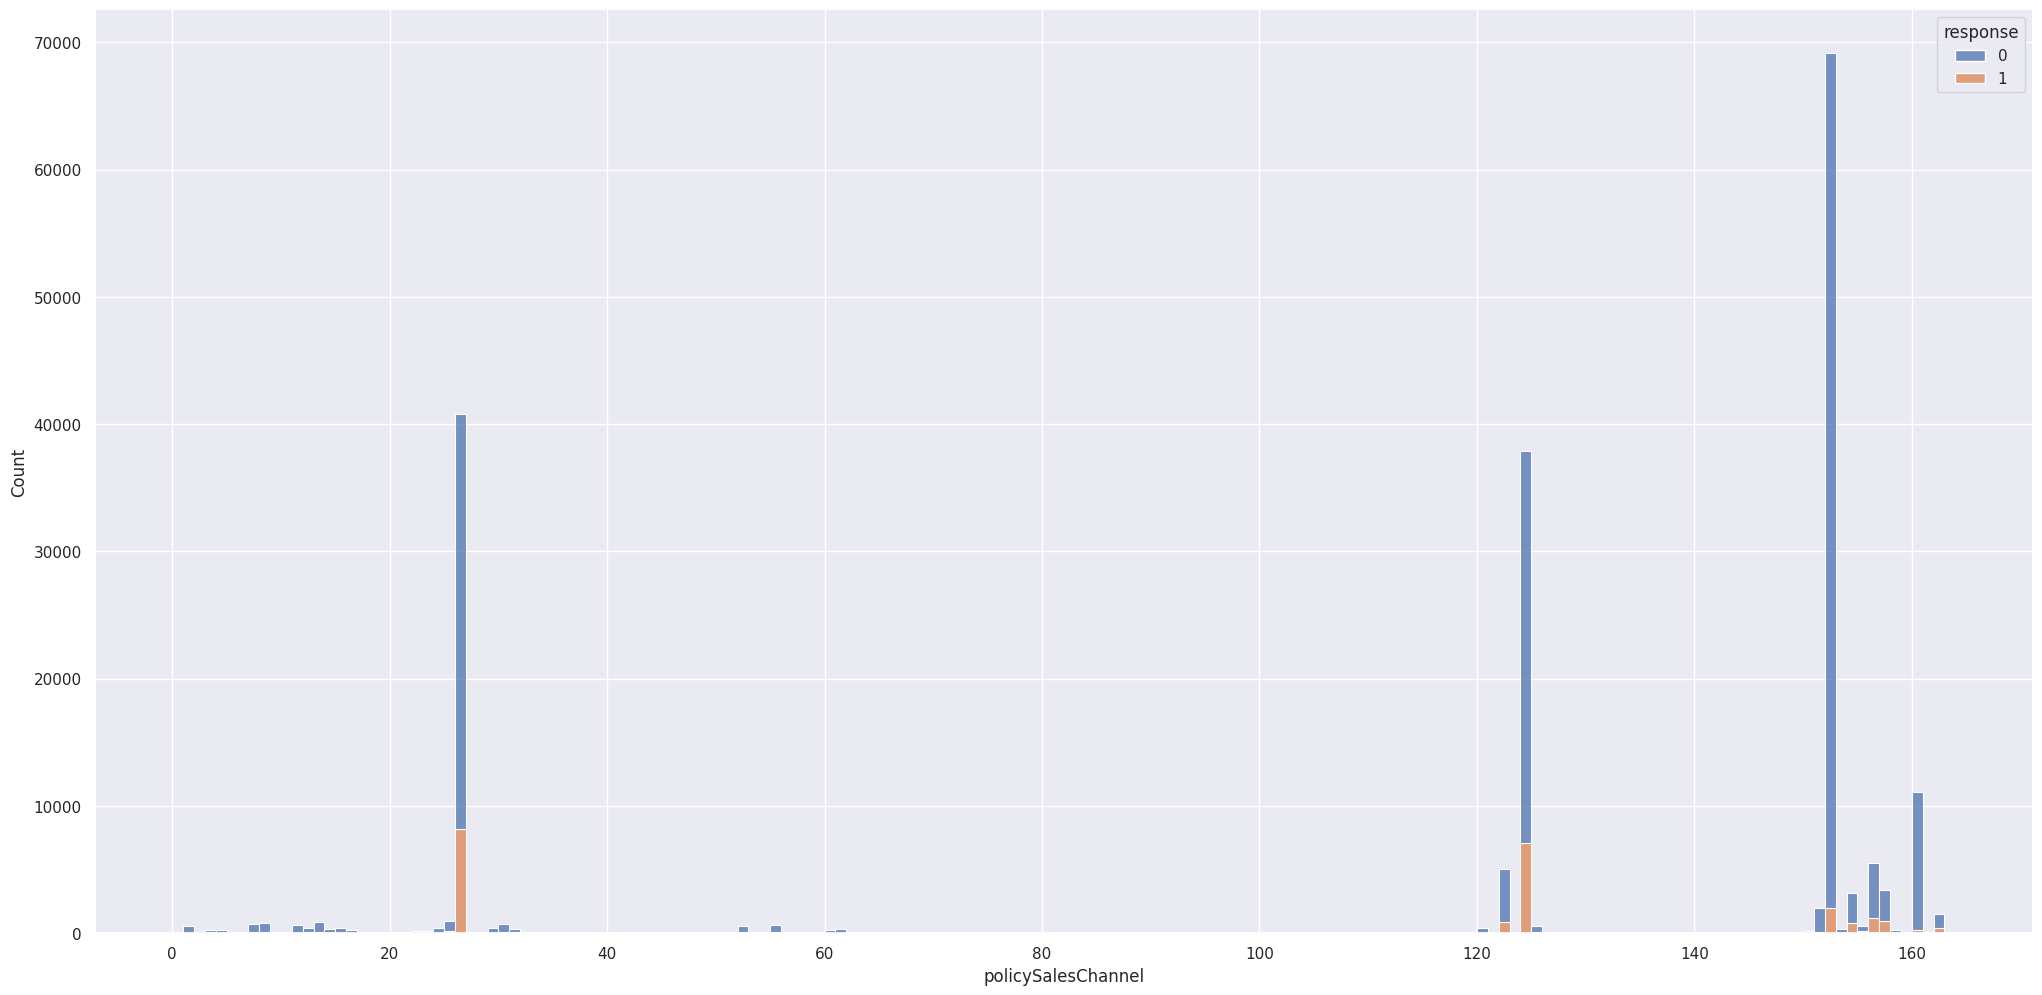

In [56]:
sns.histplot(data=df_eda, x='policySalesChannel', hue='response', multiple='stack', binwidth=1);

#### Risk Age

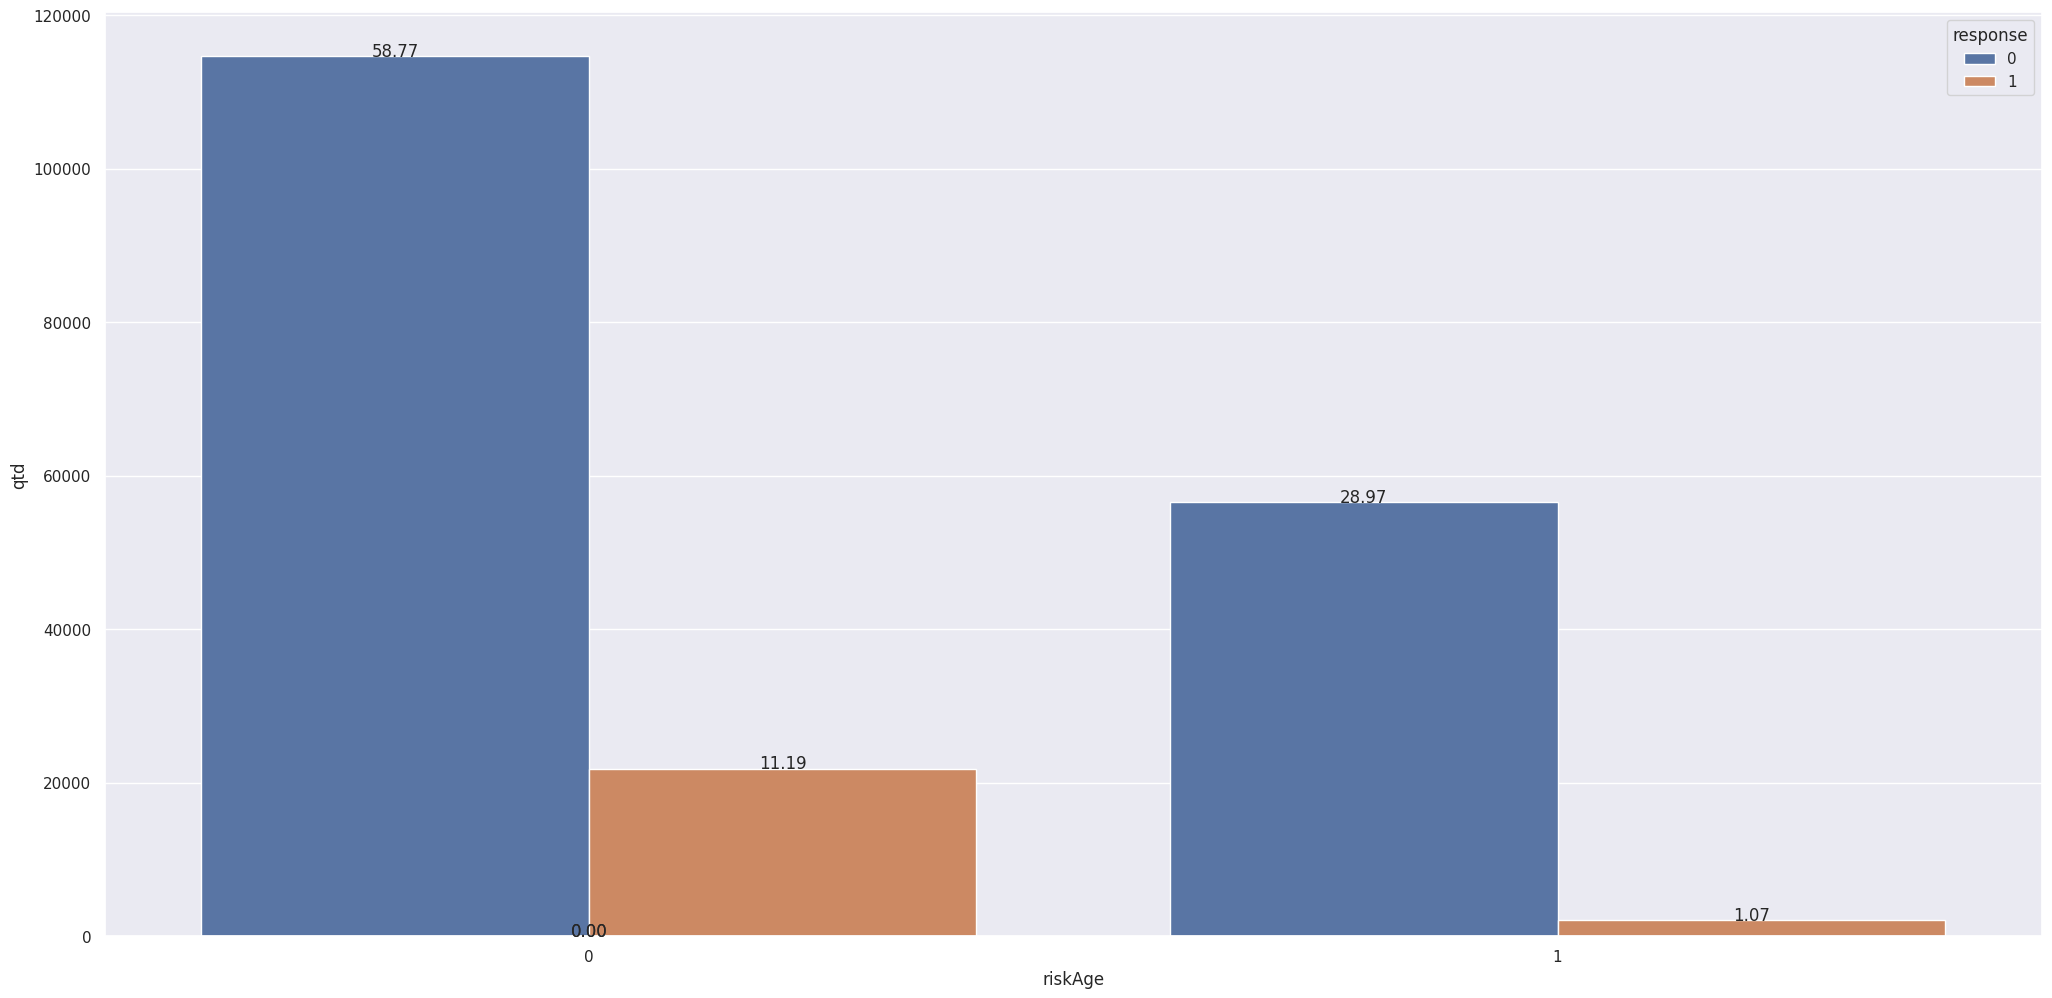

In [57]:
aux=df_eda[['riskAge','response']].groupby(['riskAge','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(x='riskAge',y='qtd',data=aux,hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

## 4.2. Hypotheses Validation

### H1 - Women buy more vehicles insurance than men

**False** - Men (60,82%) have more interest in vehicles insurance than women (39,18%)

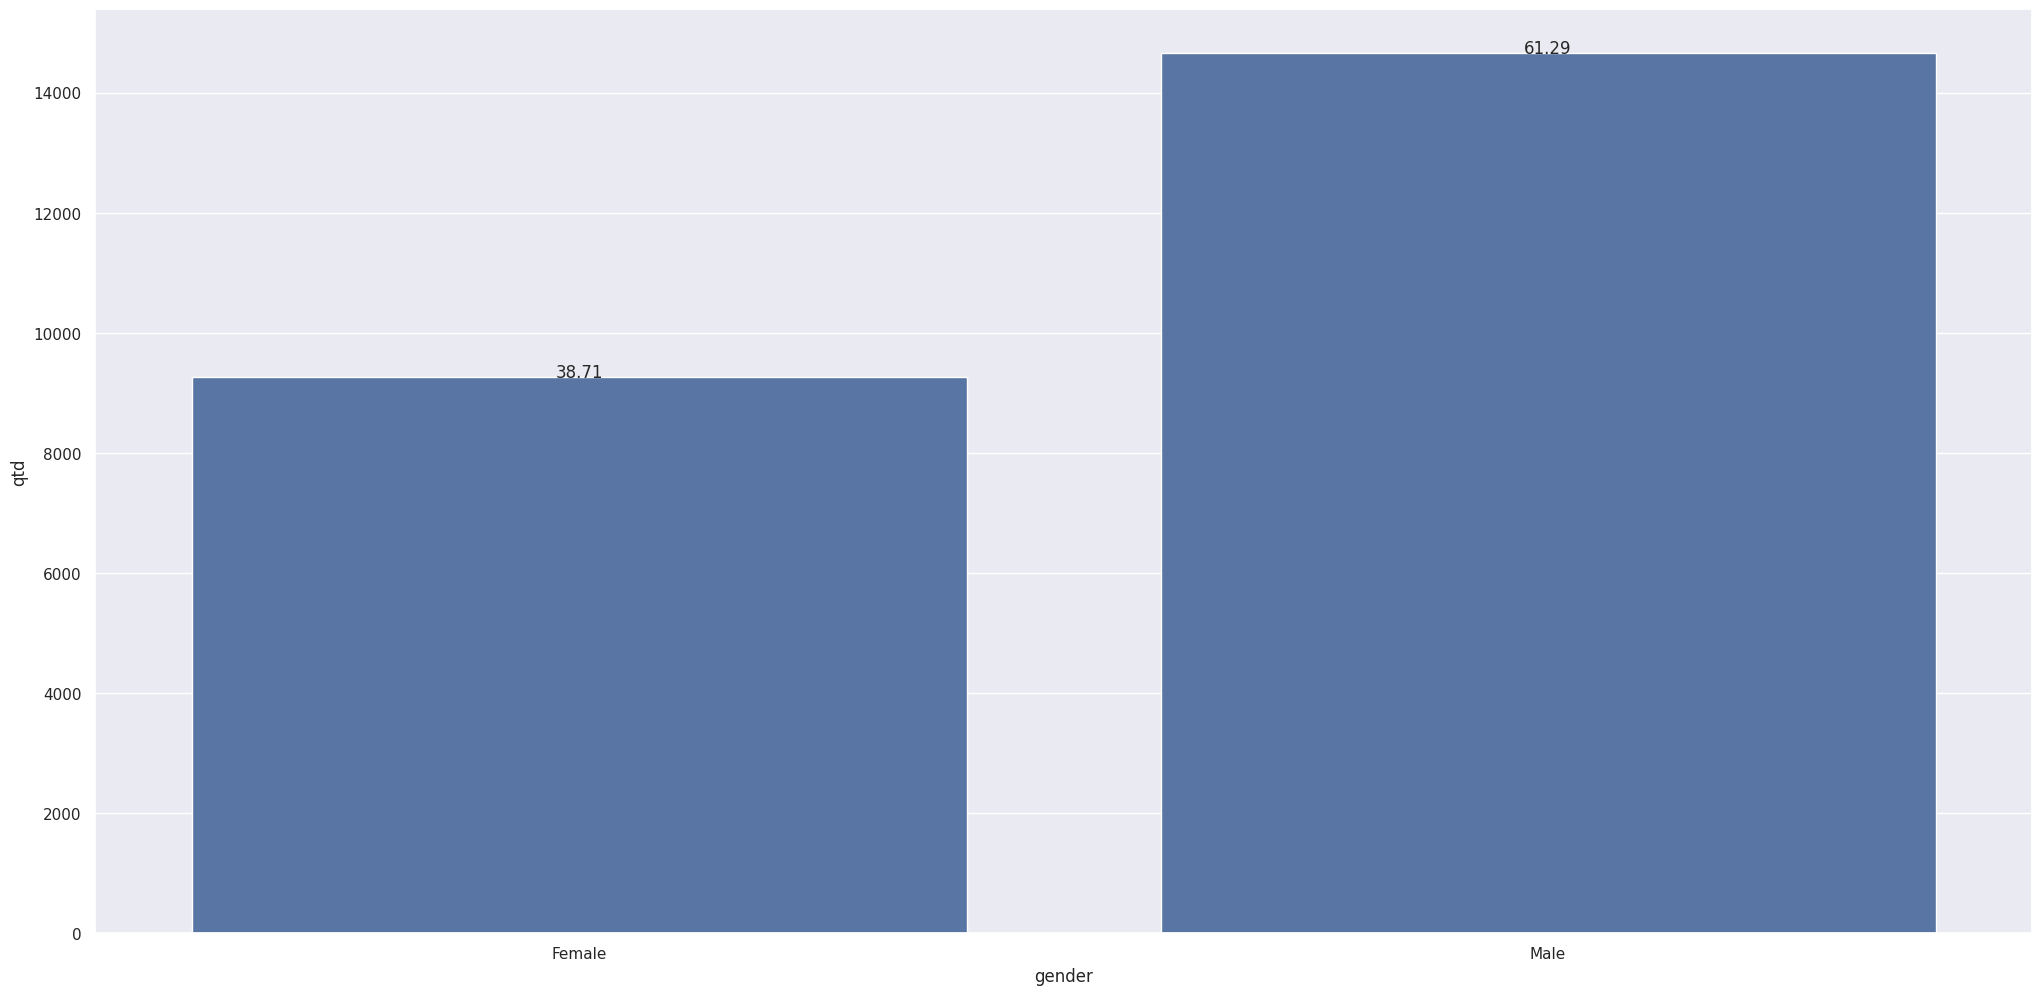

In [58]:
aux=df_eda[df_eda['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)


### H2 - Customer with cars less than 2 years old, have more interest on vehicle insurance

**True** - Customers with cars between 1 and 2 years correspond to 74,34% of interesting in vehicles insurance

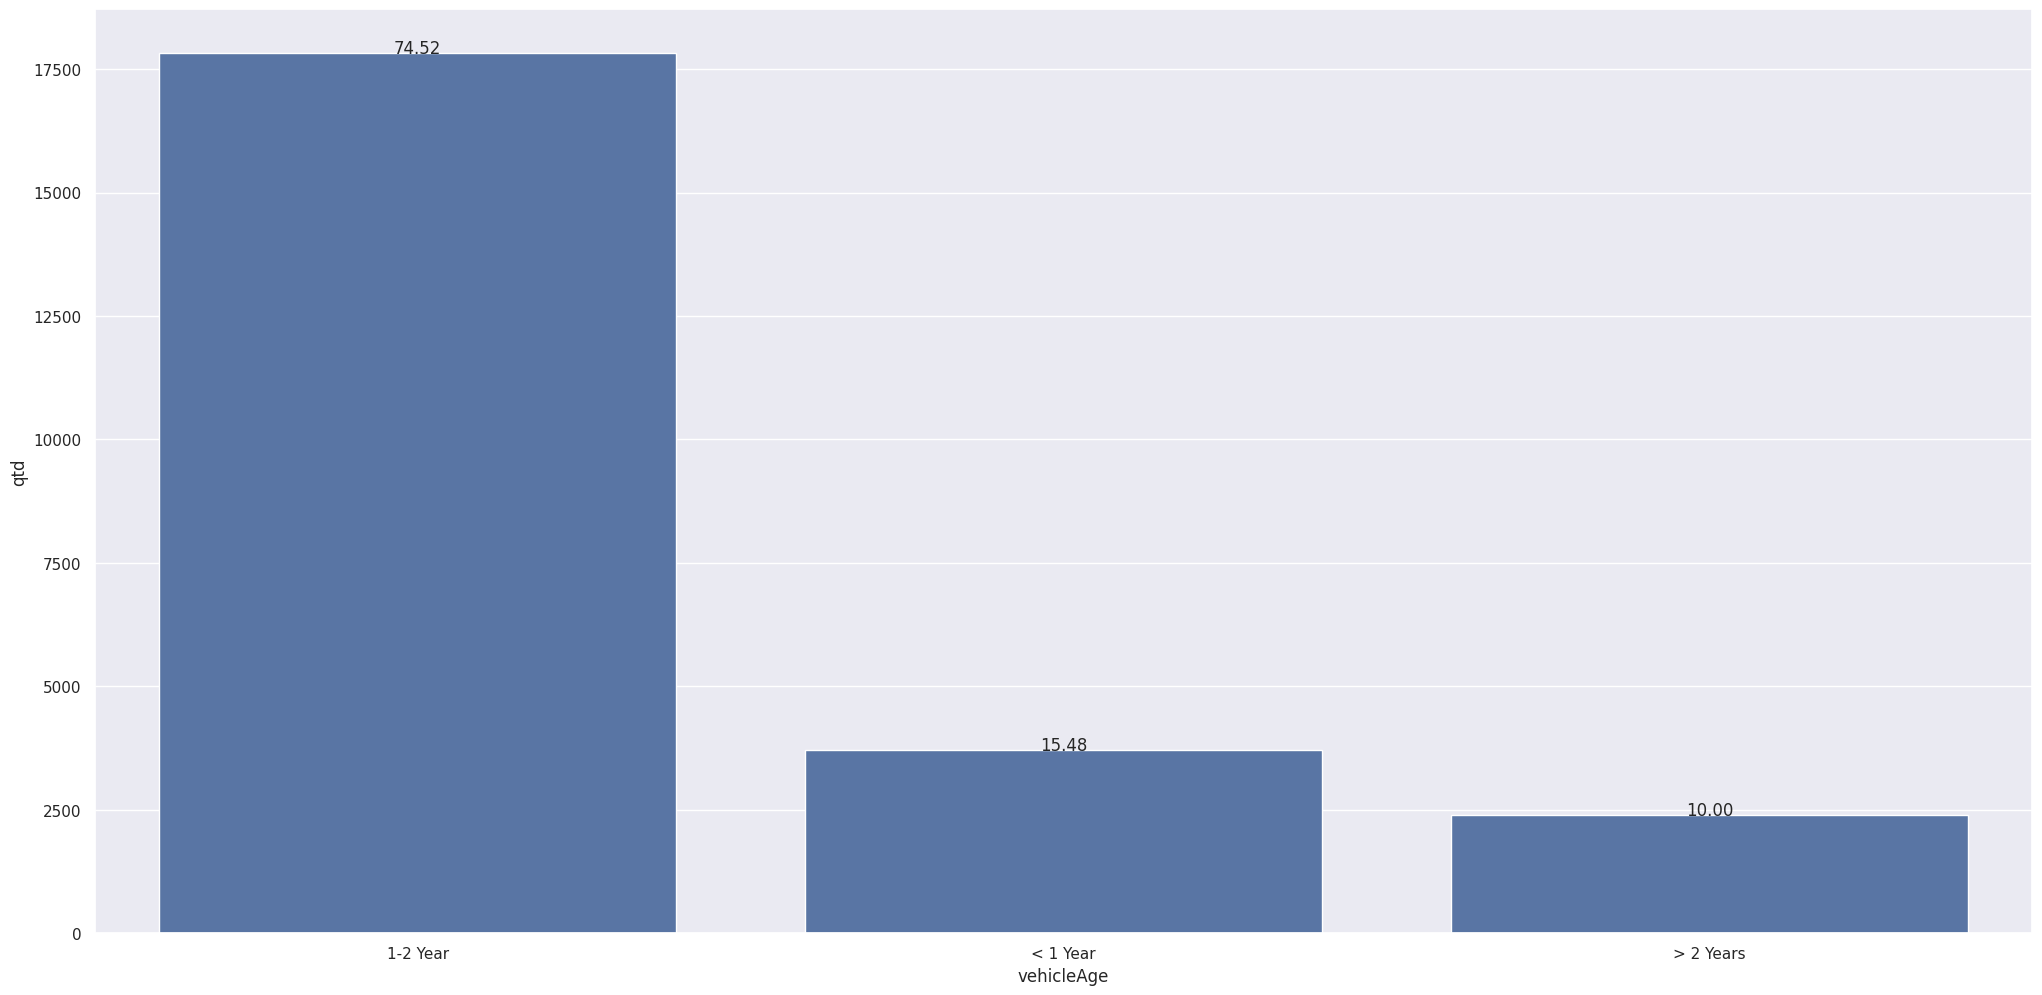

In [59]:
aux=df_eda[df_eda['response']==1]
aux=aux[['vehicleAge']].groupby('vehicleAge').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicleAge',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)


### H3 - Customer without driving license don't have interest in vehicles insurance
**False** - A tiny customers quantity(0,01%) have interest on vehicles insurance, dispite haven't driving license

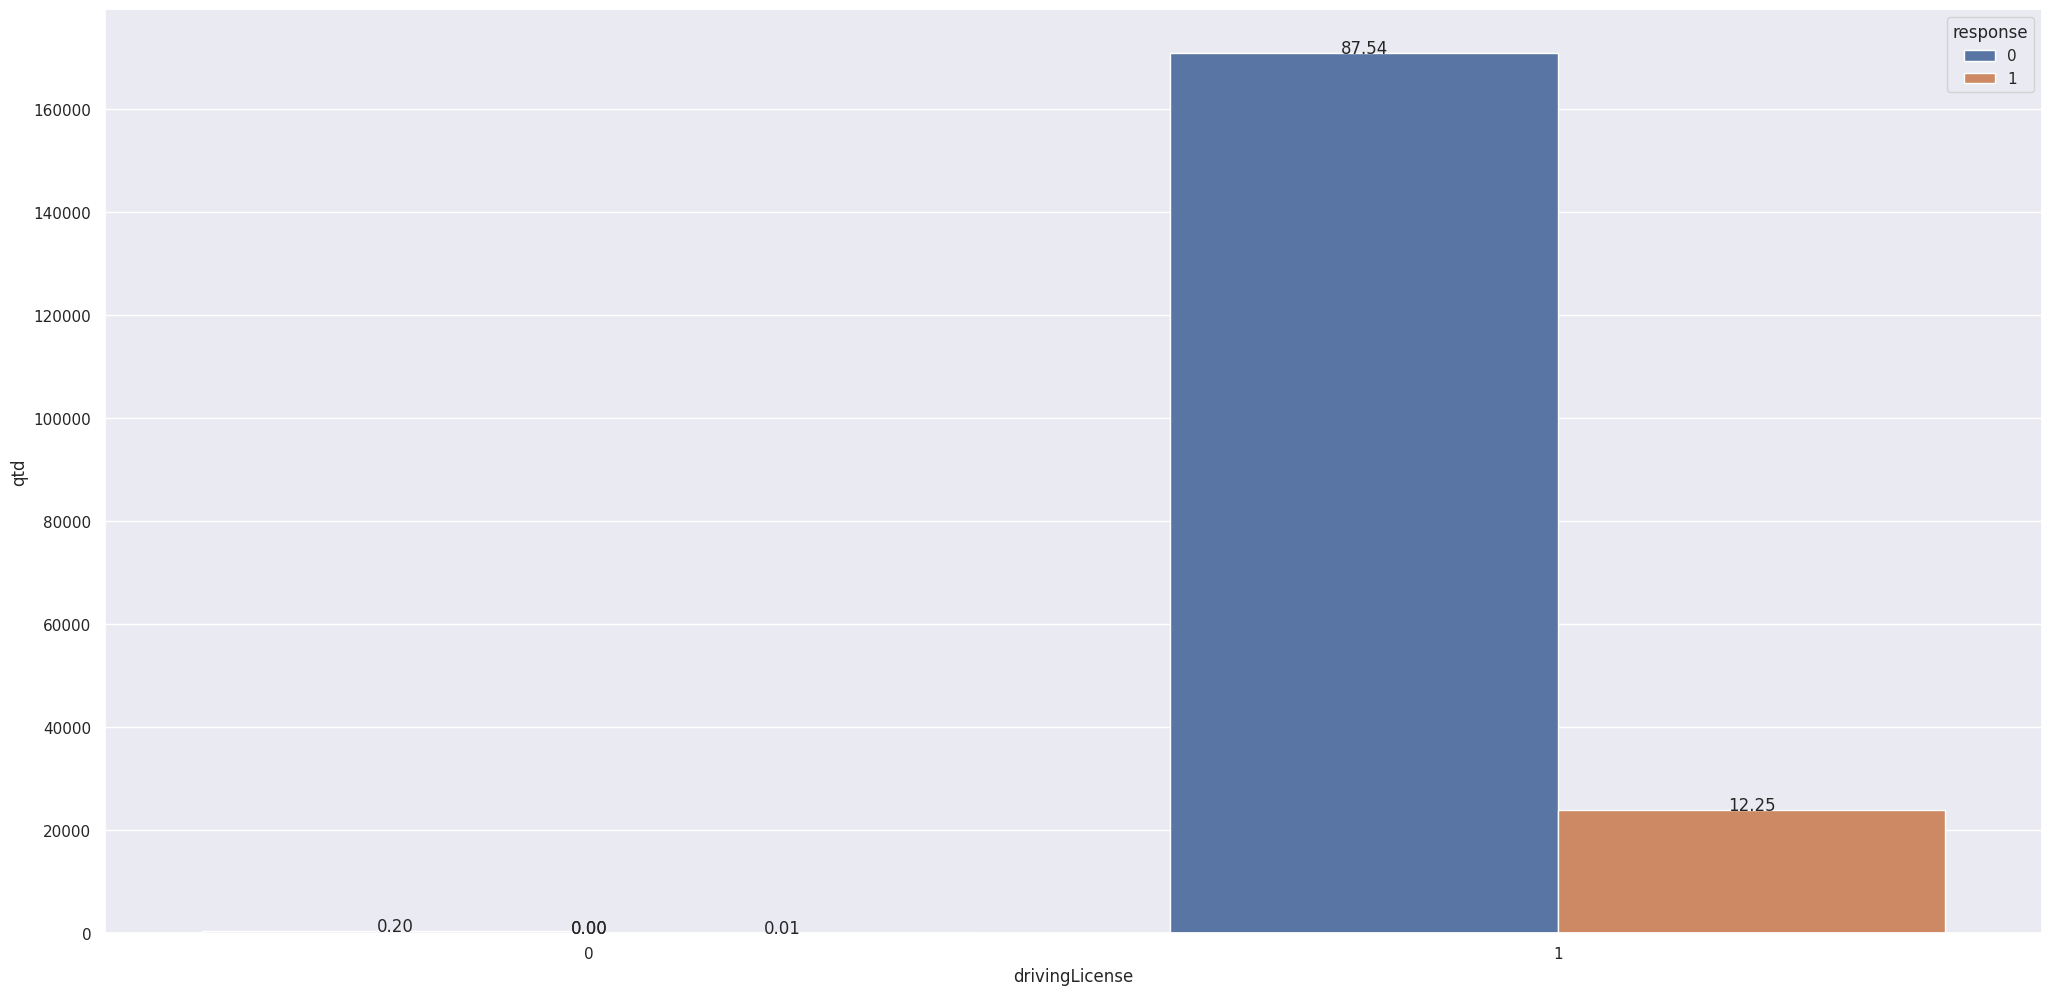

In [60]:
aux=df_eda[['drivingLicense','response']].groupby(['drivingLicense','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='drivingLicense',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)


Because proportion of customer haven't driver license is most smaller than customer have driver license i'll analysing him separated

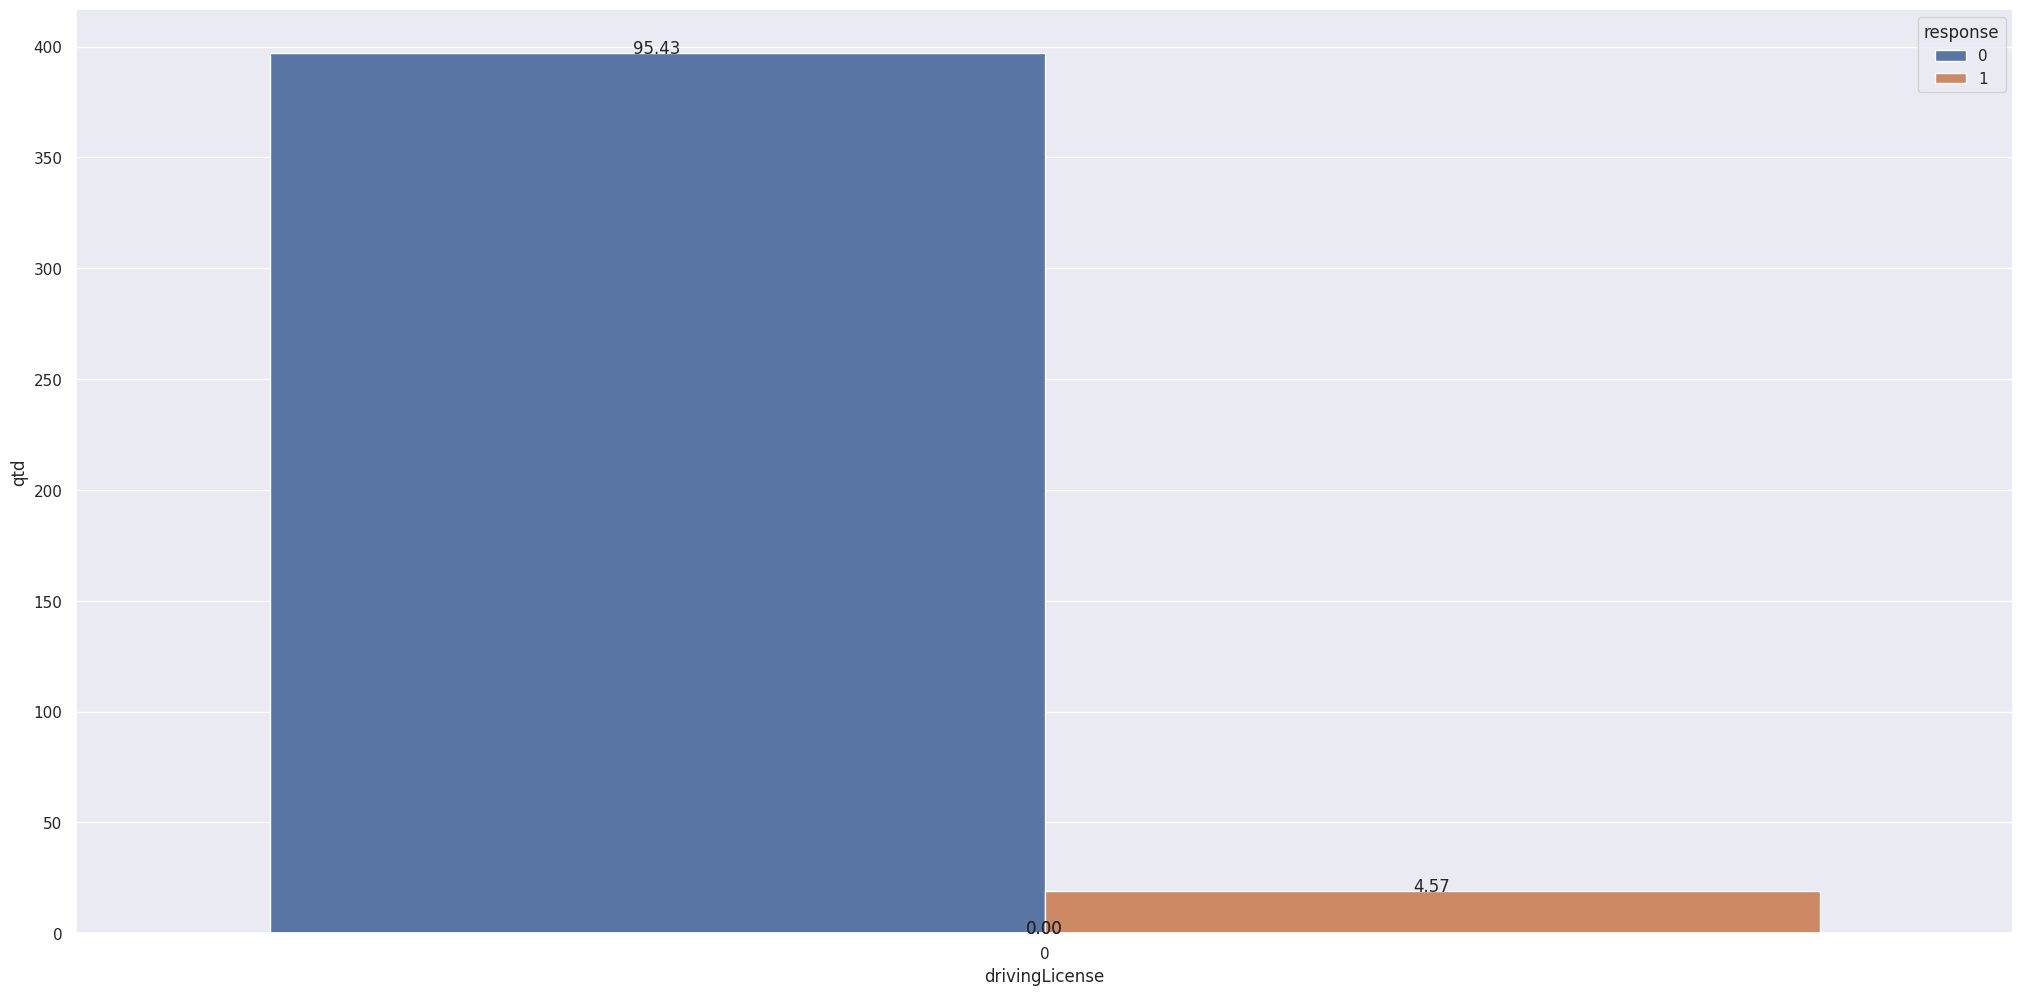

In [61]:
aux=aux[aux['drivingLicense']==0]
ax=sns.barplot(data=aux,x='drivingLicense',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Customers had damage Historical have more interest on vehicle insurance

**True** -  Almost 98% of customer interesting on vehicle insurance had damage historical

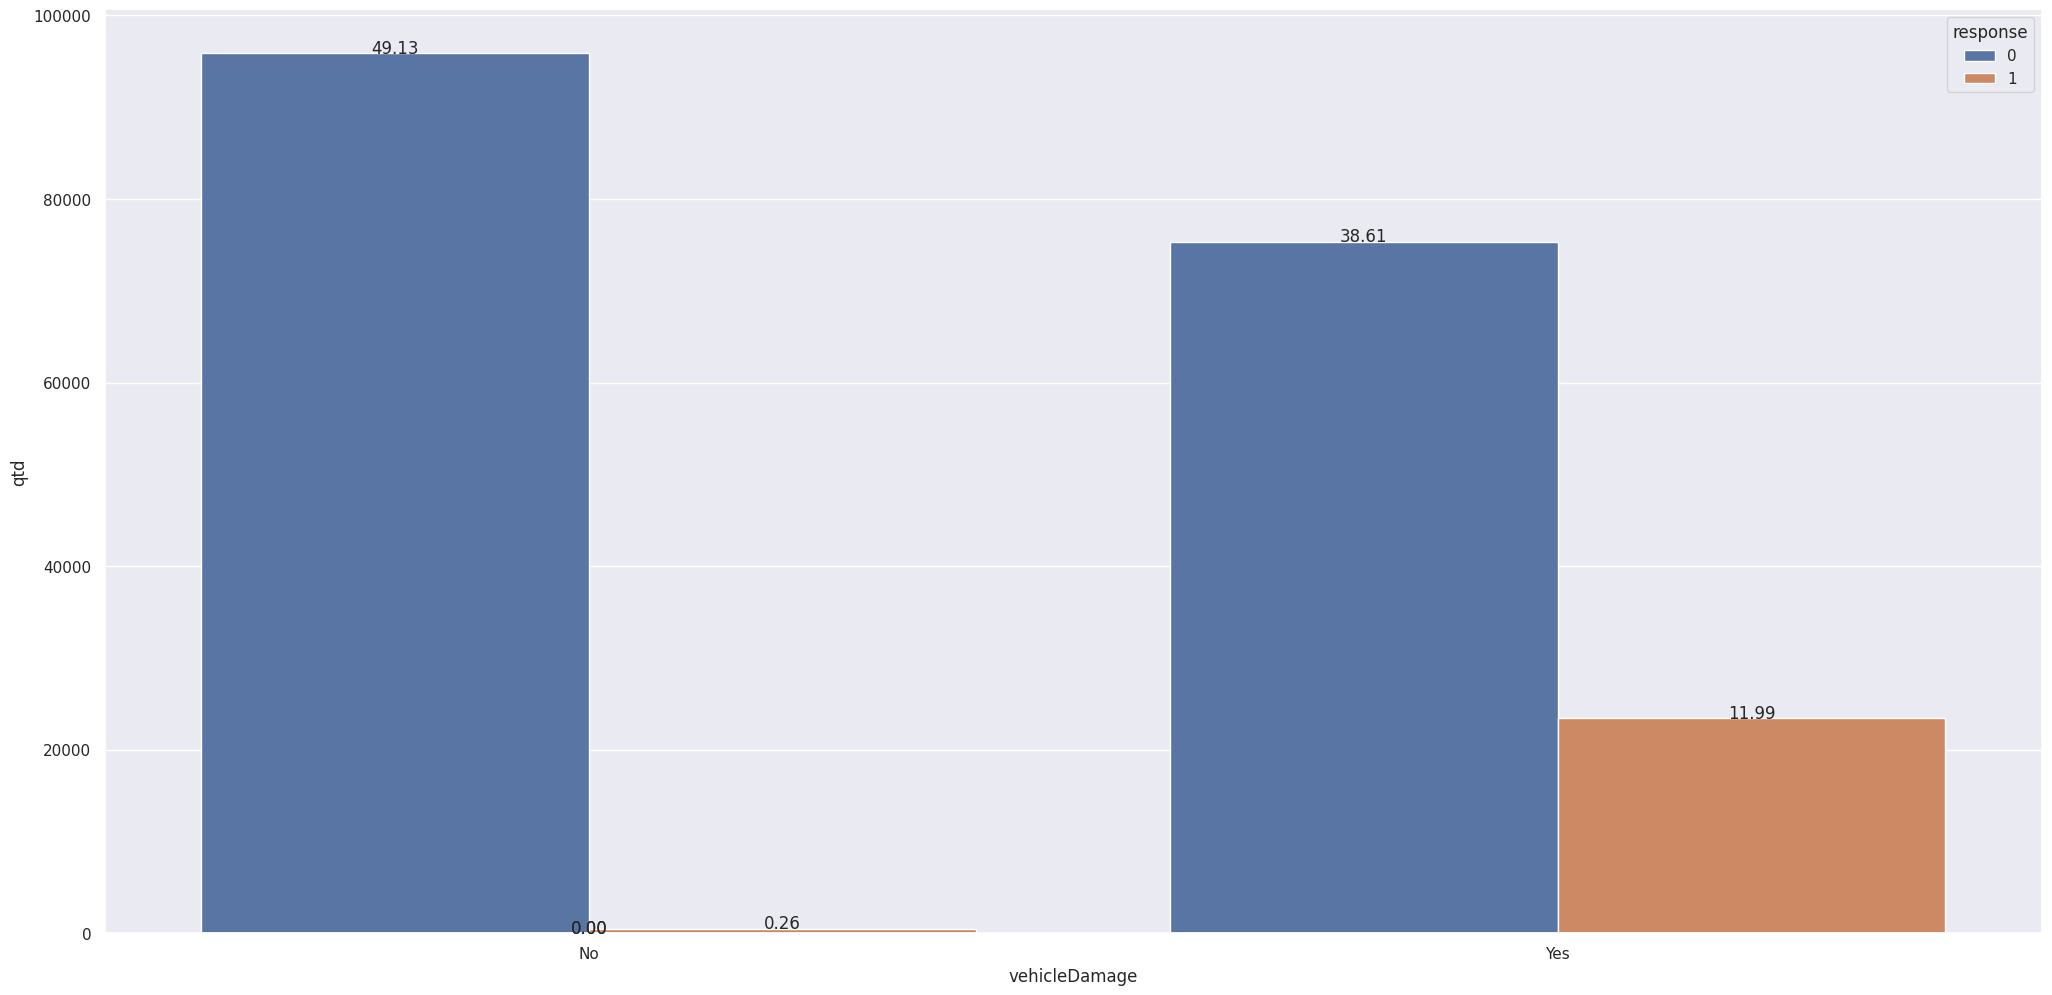

In [62]:
aux=df_eda[['vehicleDamage','response']].groupby(['vehicleDamage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicleDamage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

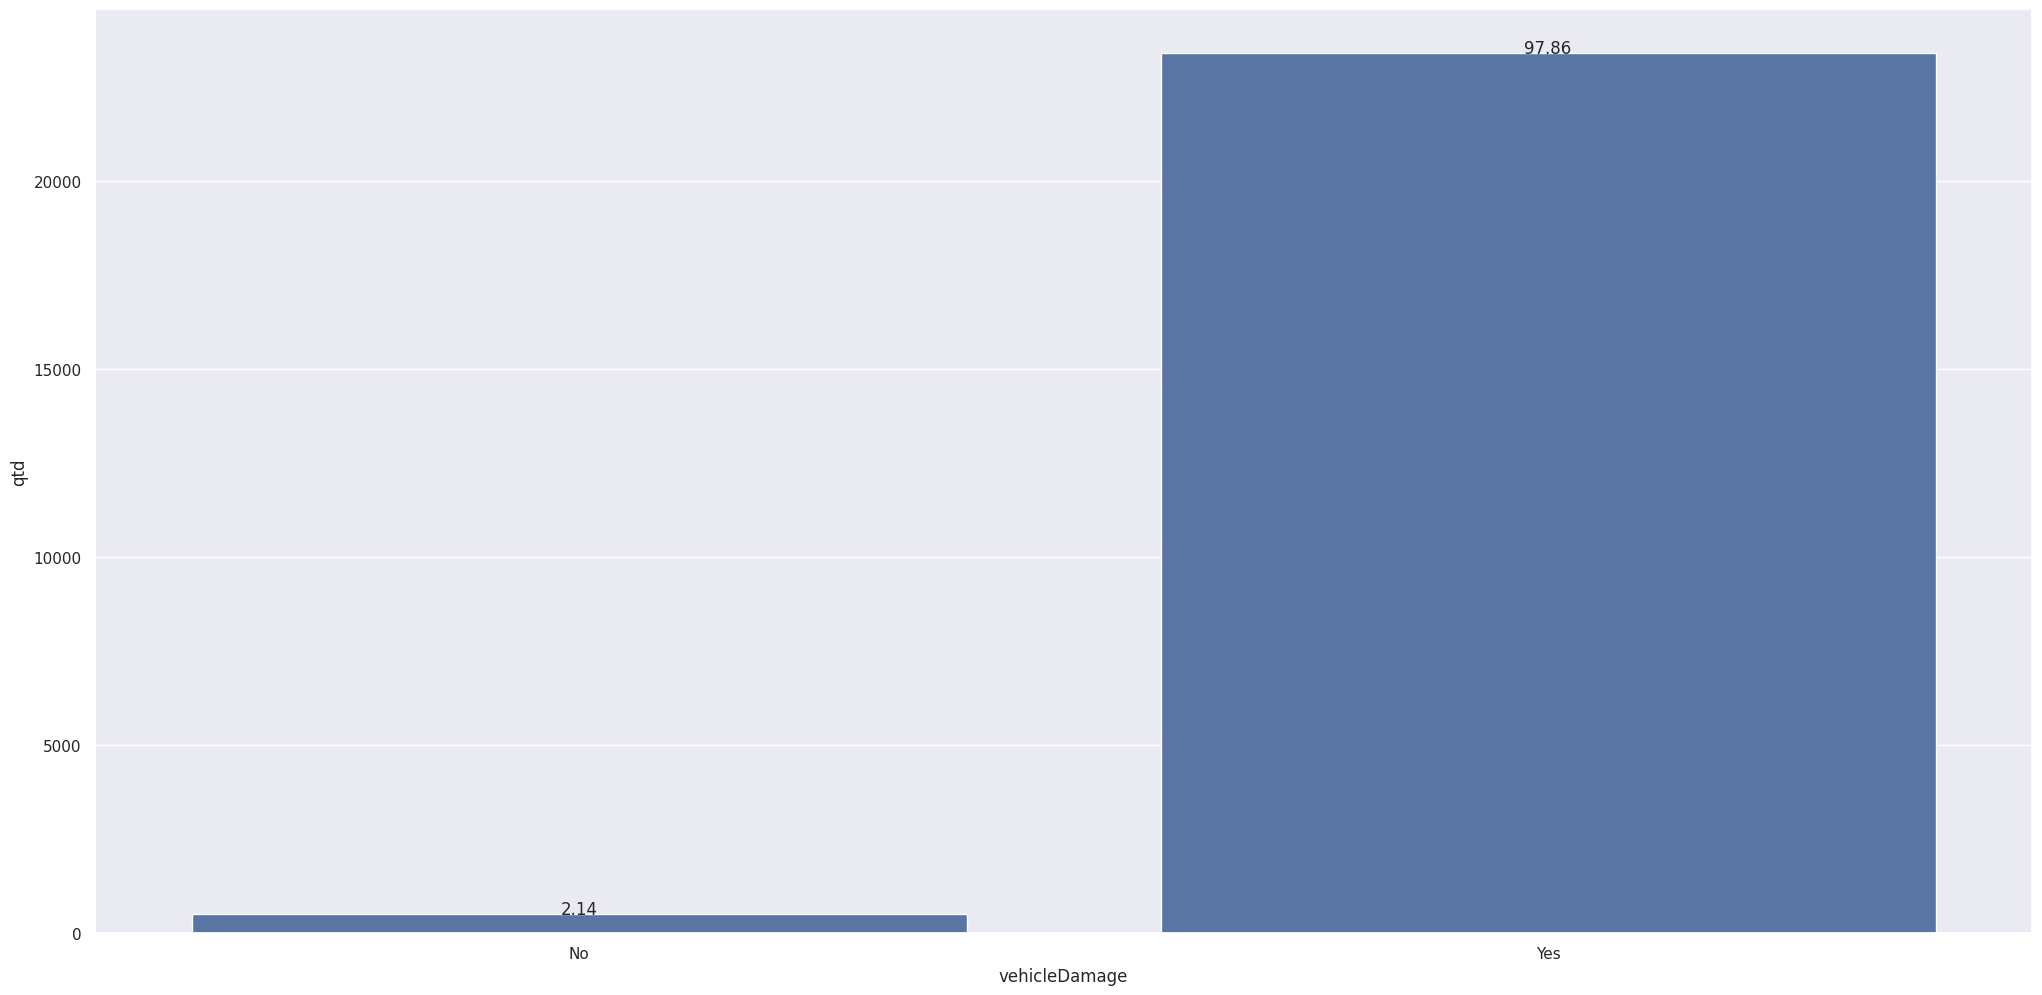

In [63]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicleDamage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5 - Customer older than 30 years old have more interest in vehicles insurance
**True** - Almost 85% of customer interesting on vehicle insurance has more then 30 years old

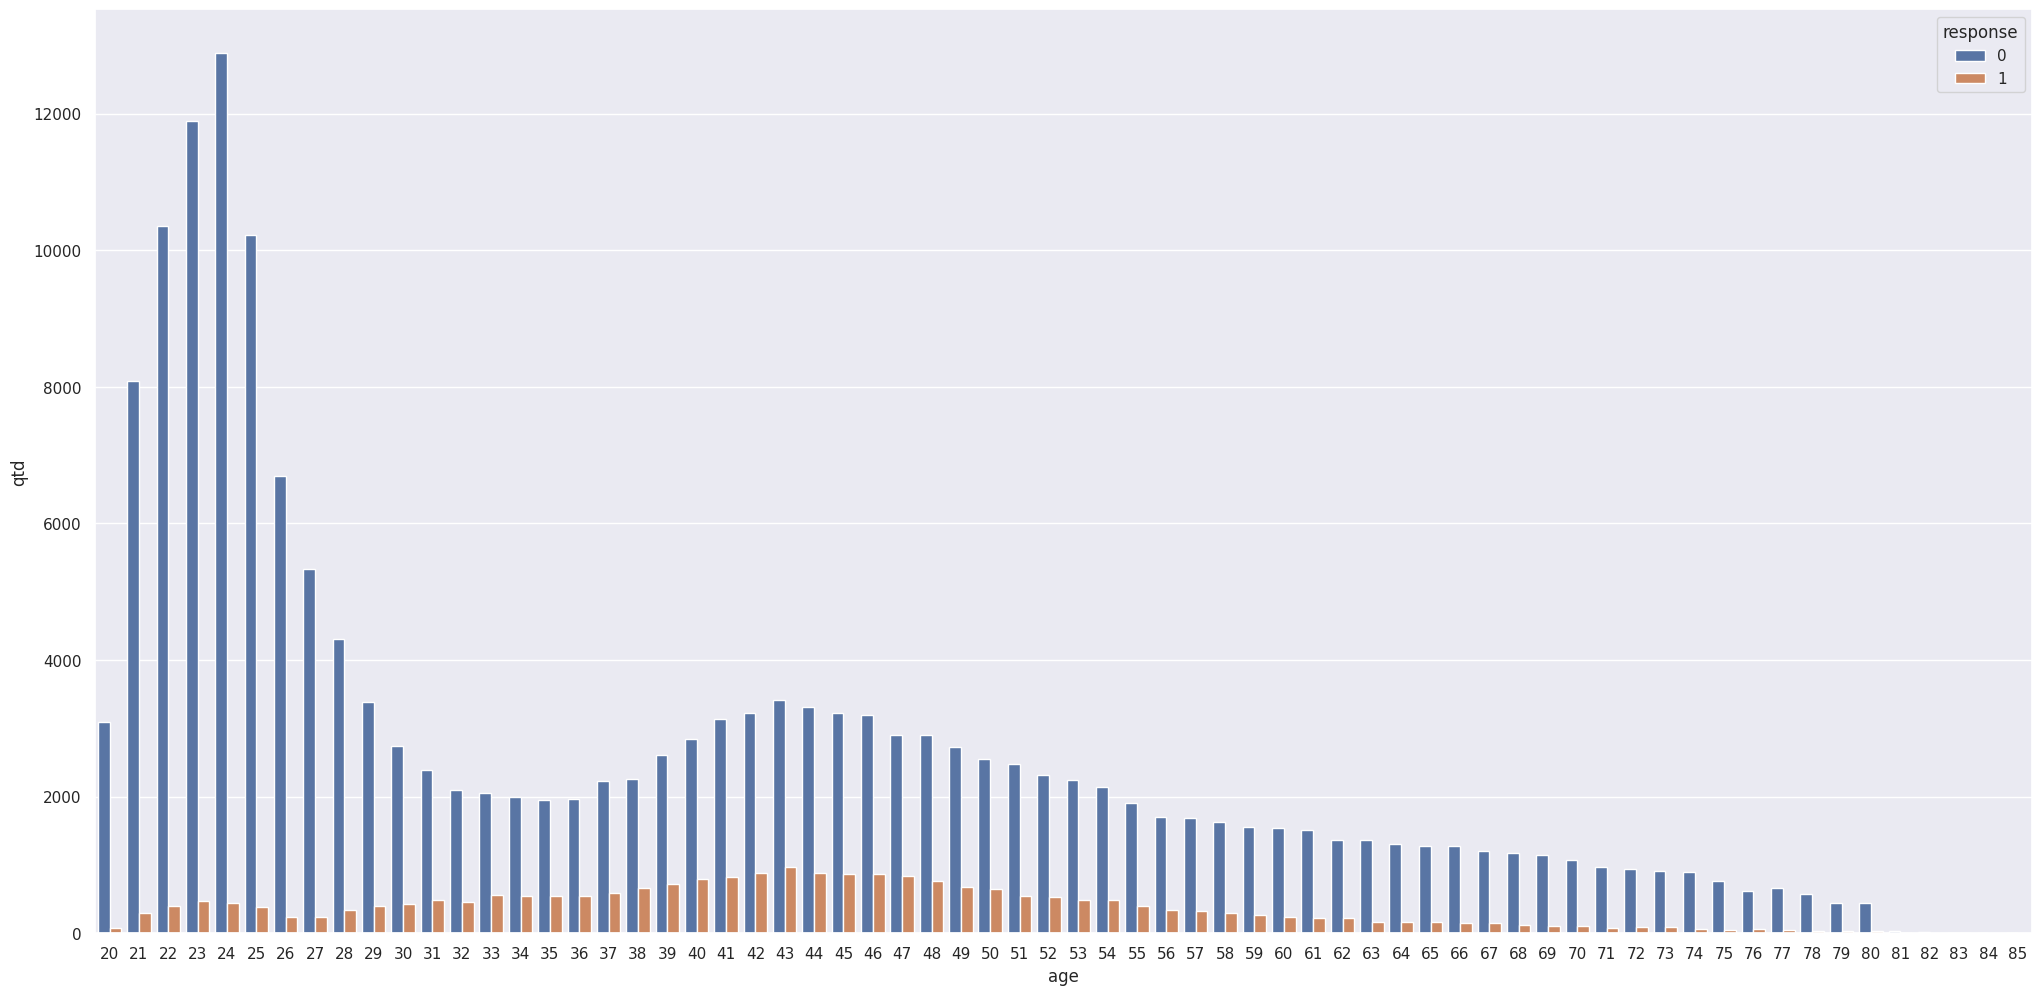

In [64]:
aux=df_eda[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response');

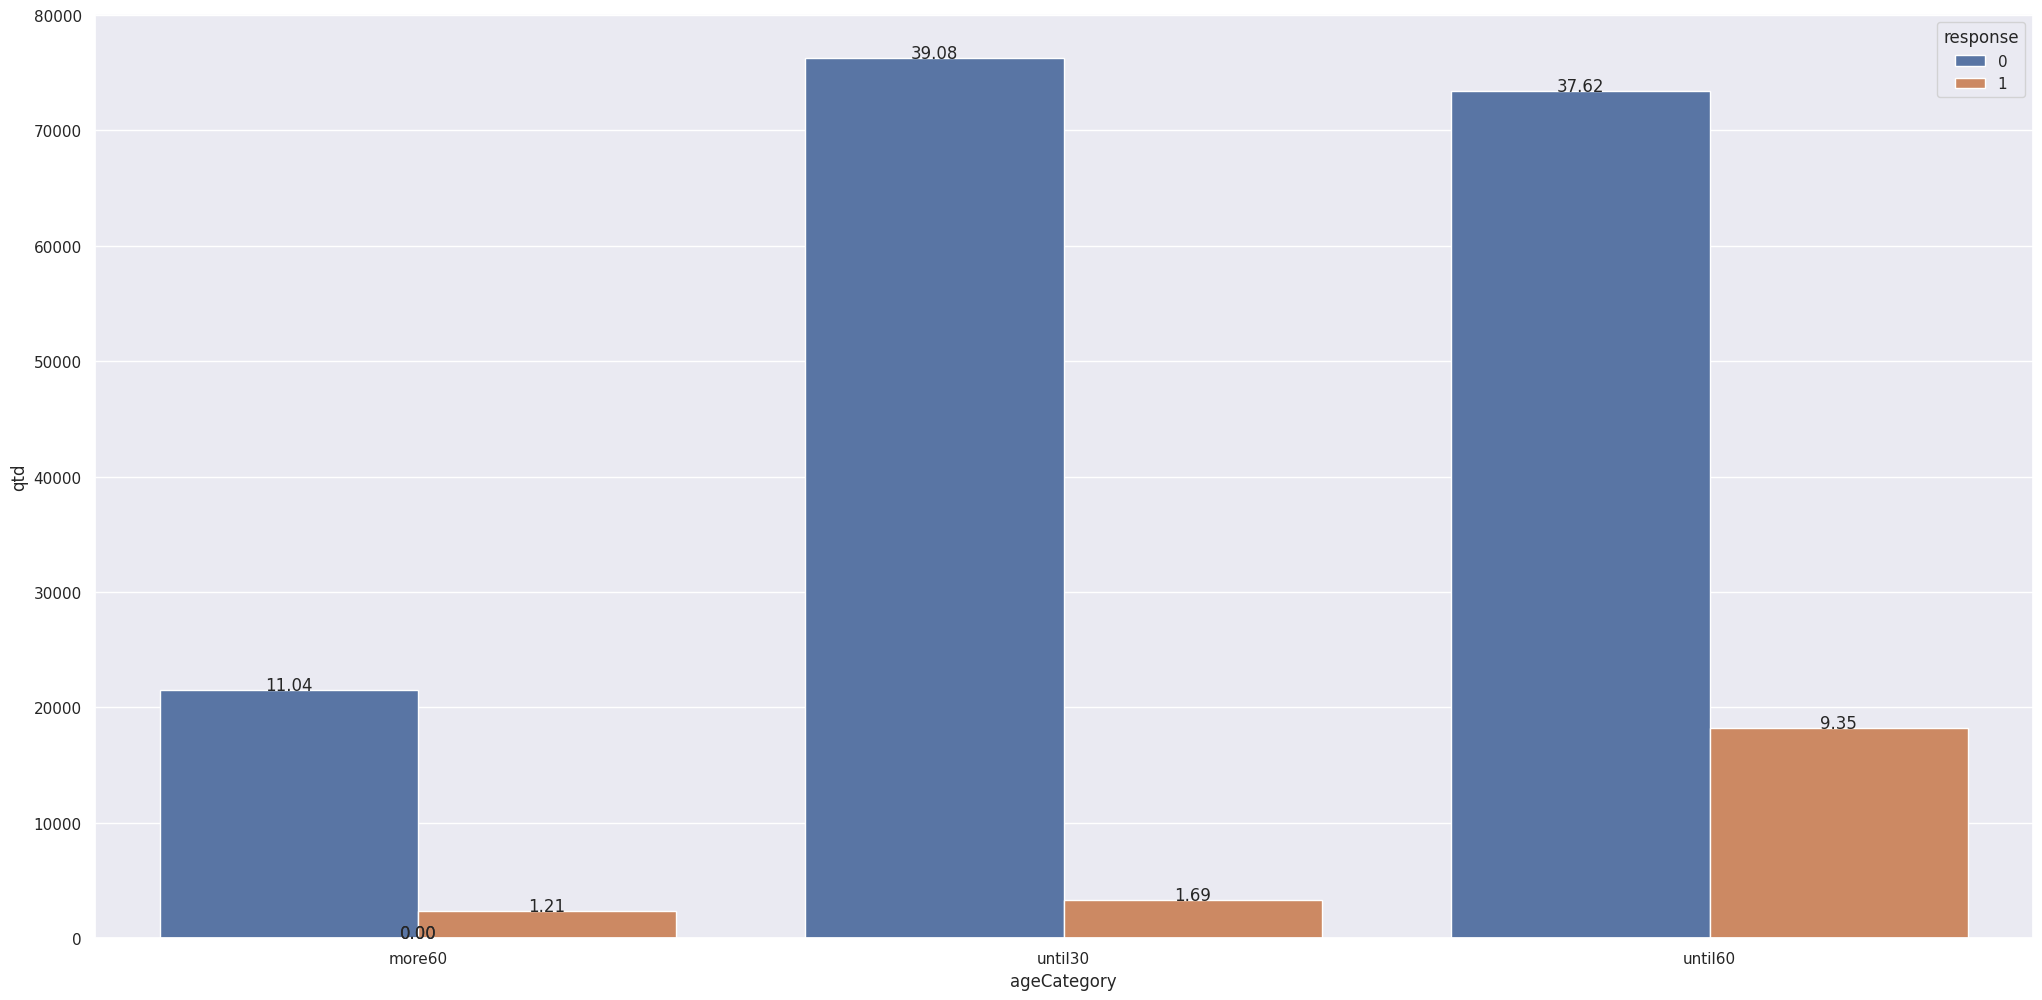

In [65]:
aux=df_eda.copy()
aux['ageCategory']=df_eda['age'].apply(lambda x: 'until30' if x<30 else 'until60' if x>=30 and x<60 else 'more60')
aux=aux[['ageCategory','response']].groupby(['ageCategory','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='ageCategory',y='qtd',hue='response');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

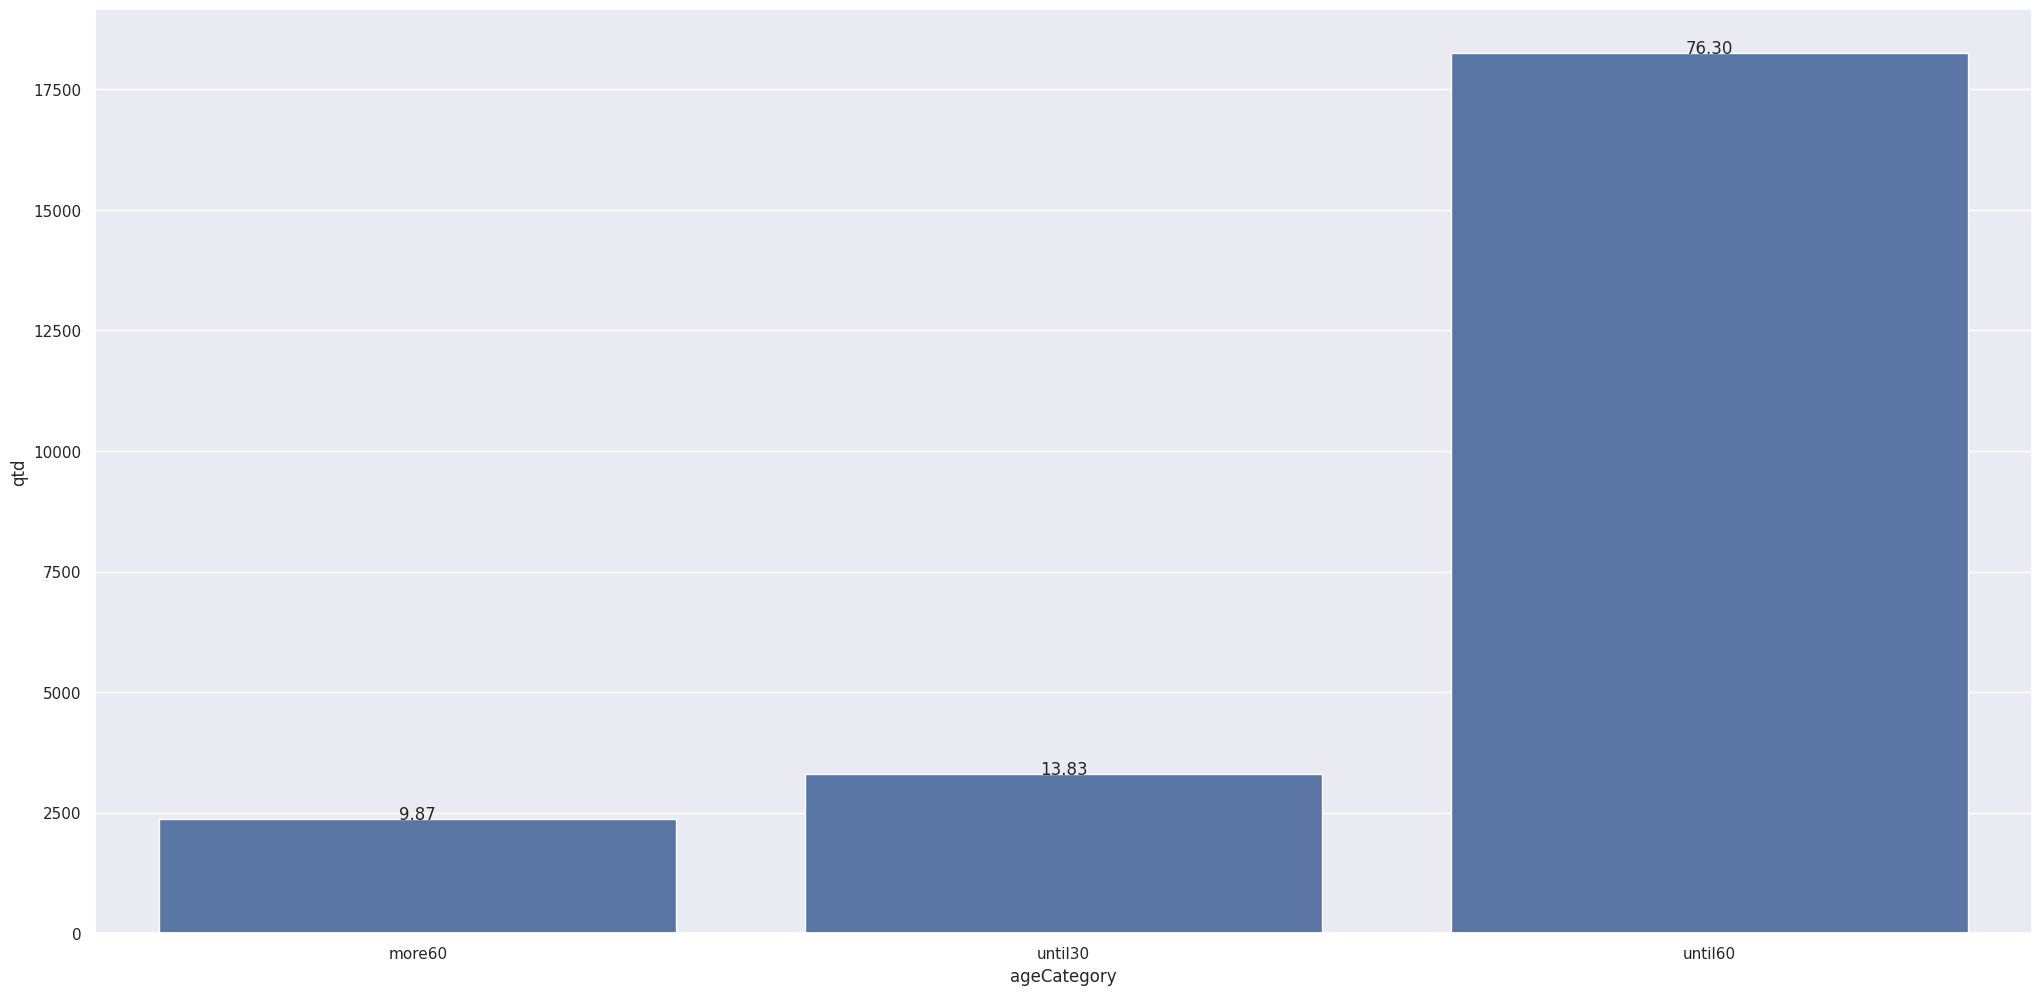

In [66]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='ageCategory',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H6 - Customer that paid between 24405 a 39400 on Annual Premium have more interest in vehicles insurance
**True** - Customer that paid between 24405 a 39400 on Annual Premium correspond a 46,52% of customer interesting in vehicles insurance

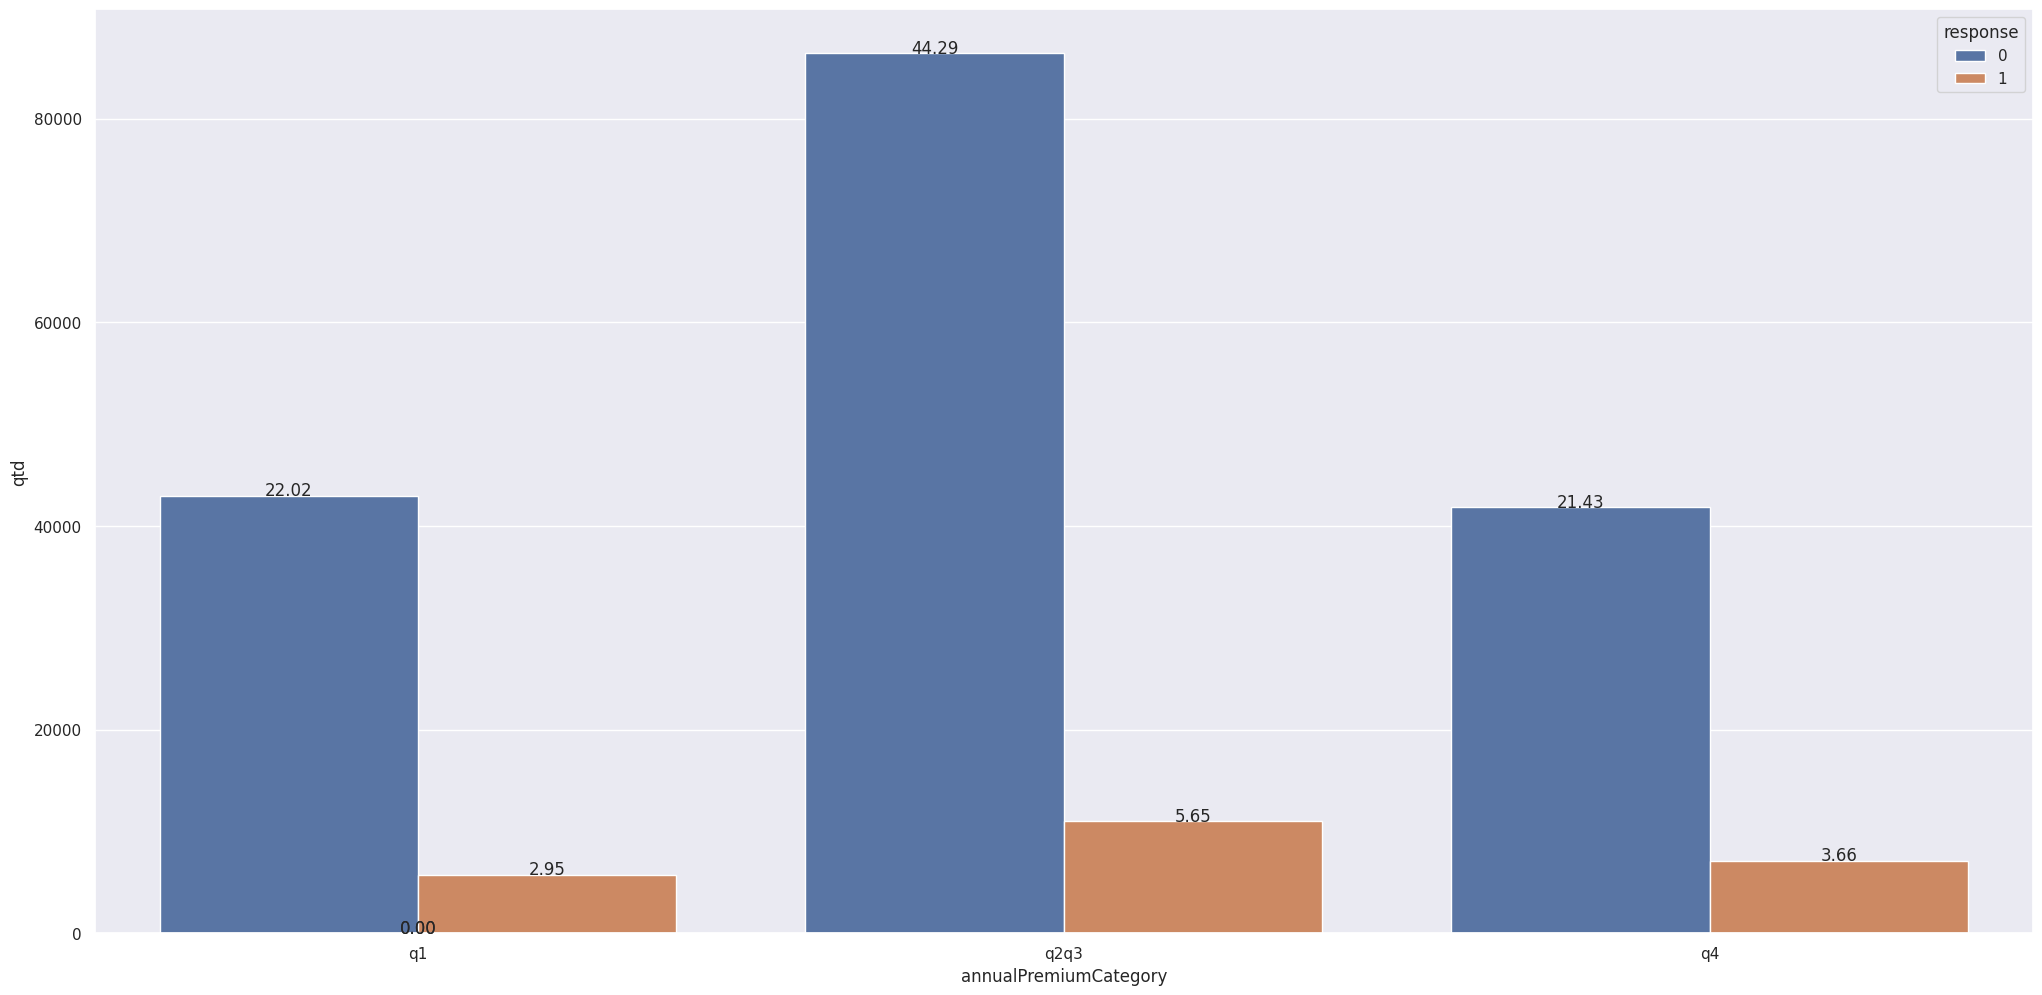

In [67]:
aux = df_eda.copy()
aux['annualPremiumCategory'] =aux['annualPremium'].apply(lambda x: 'q1' if x<24405 else 'q4' if x>39400 else 'q2q3')
aux=aux[['annualPremiumCategory','response']].groupby(['annualPremiumCategory','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='annualPremiumCategory',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

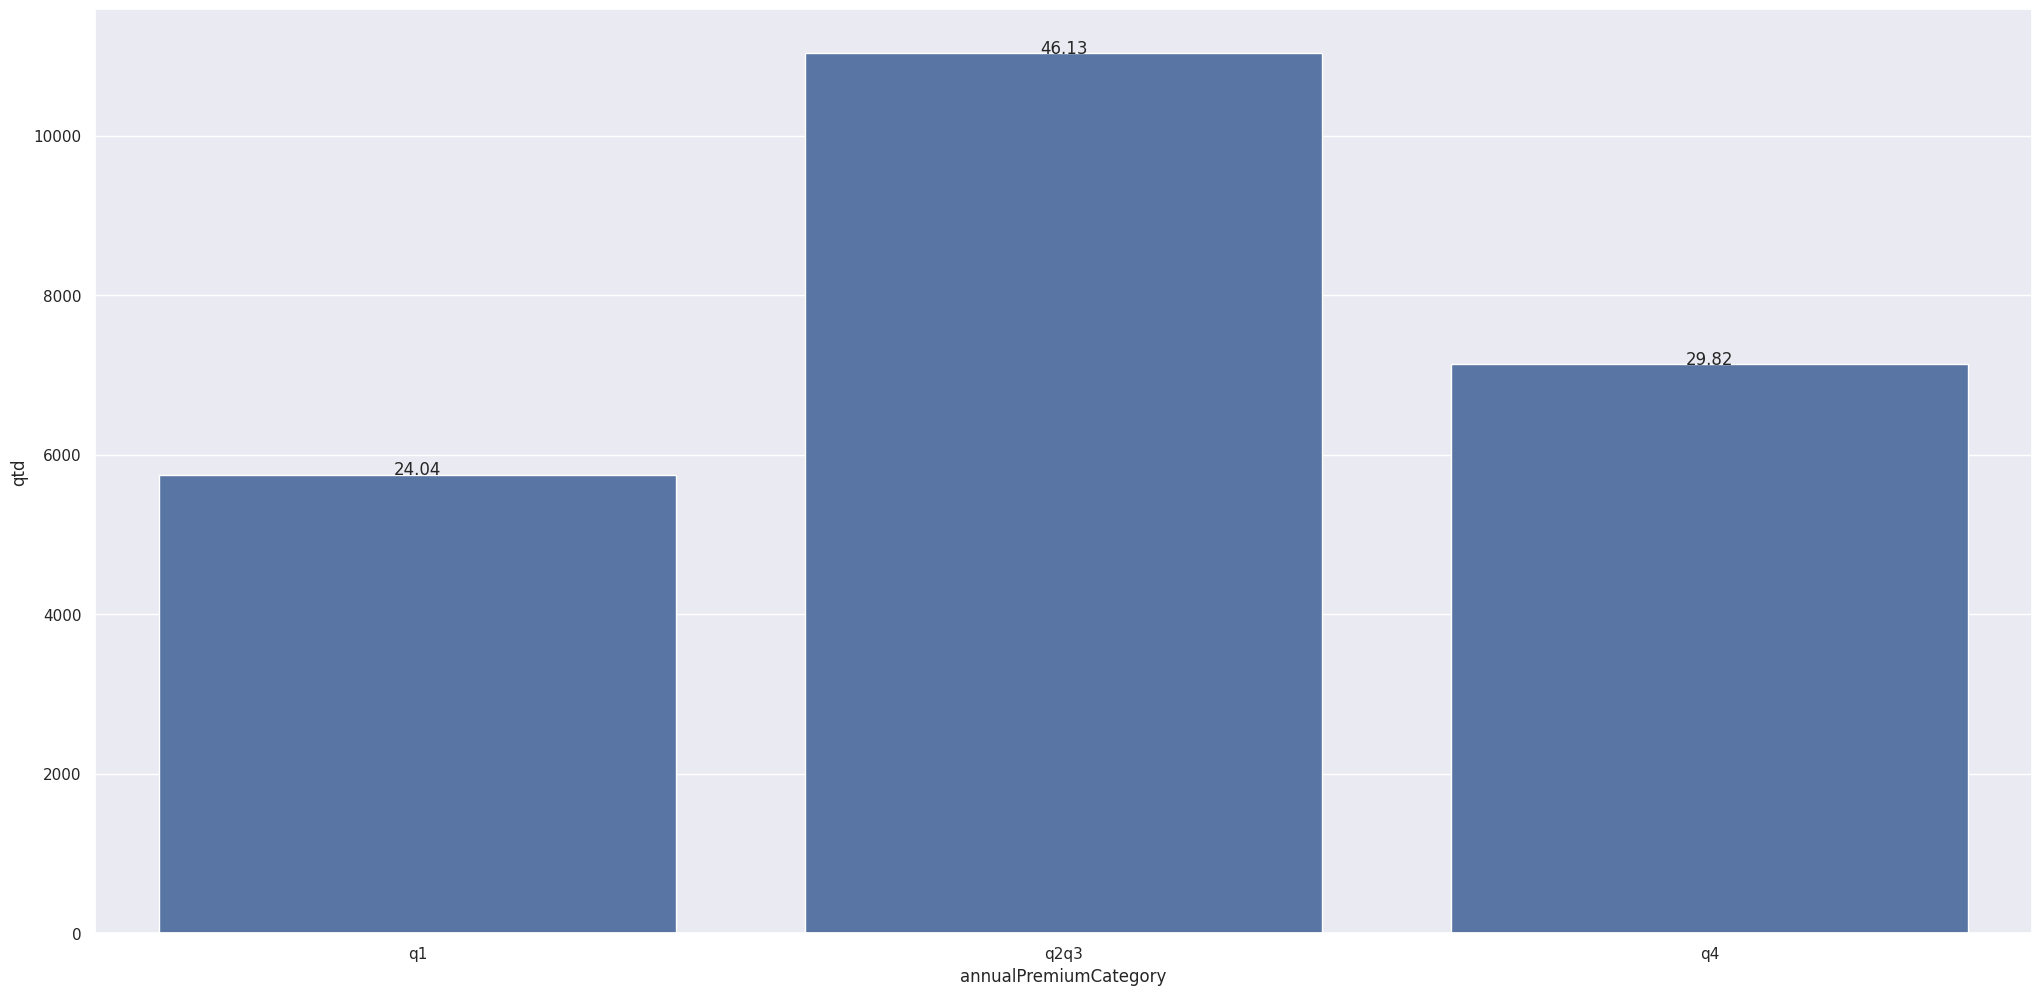

In [68]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='annualPremiumCategory',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

## 4.3. Bivariate Analysis

### Annual Premium by Region Code

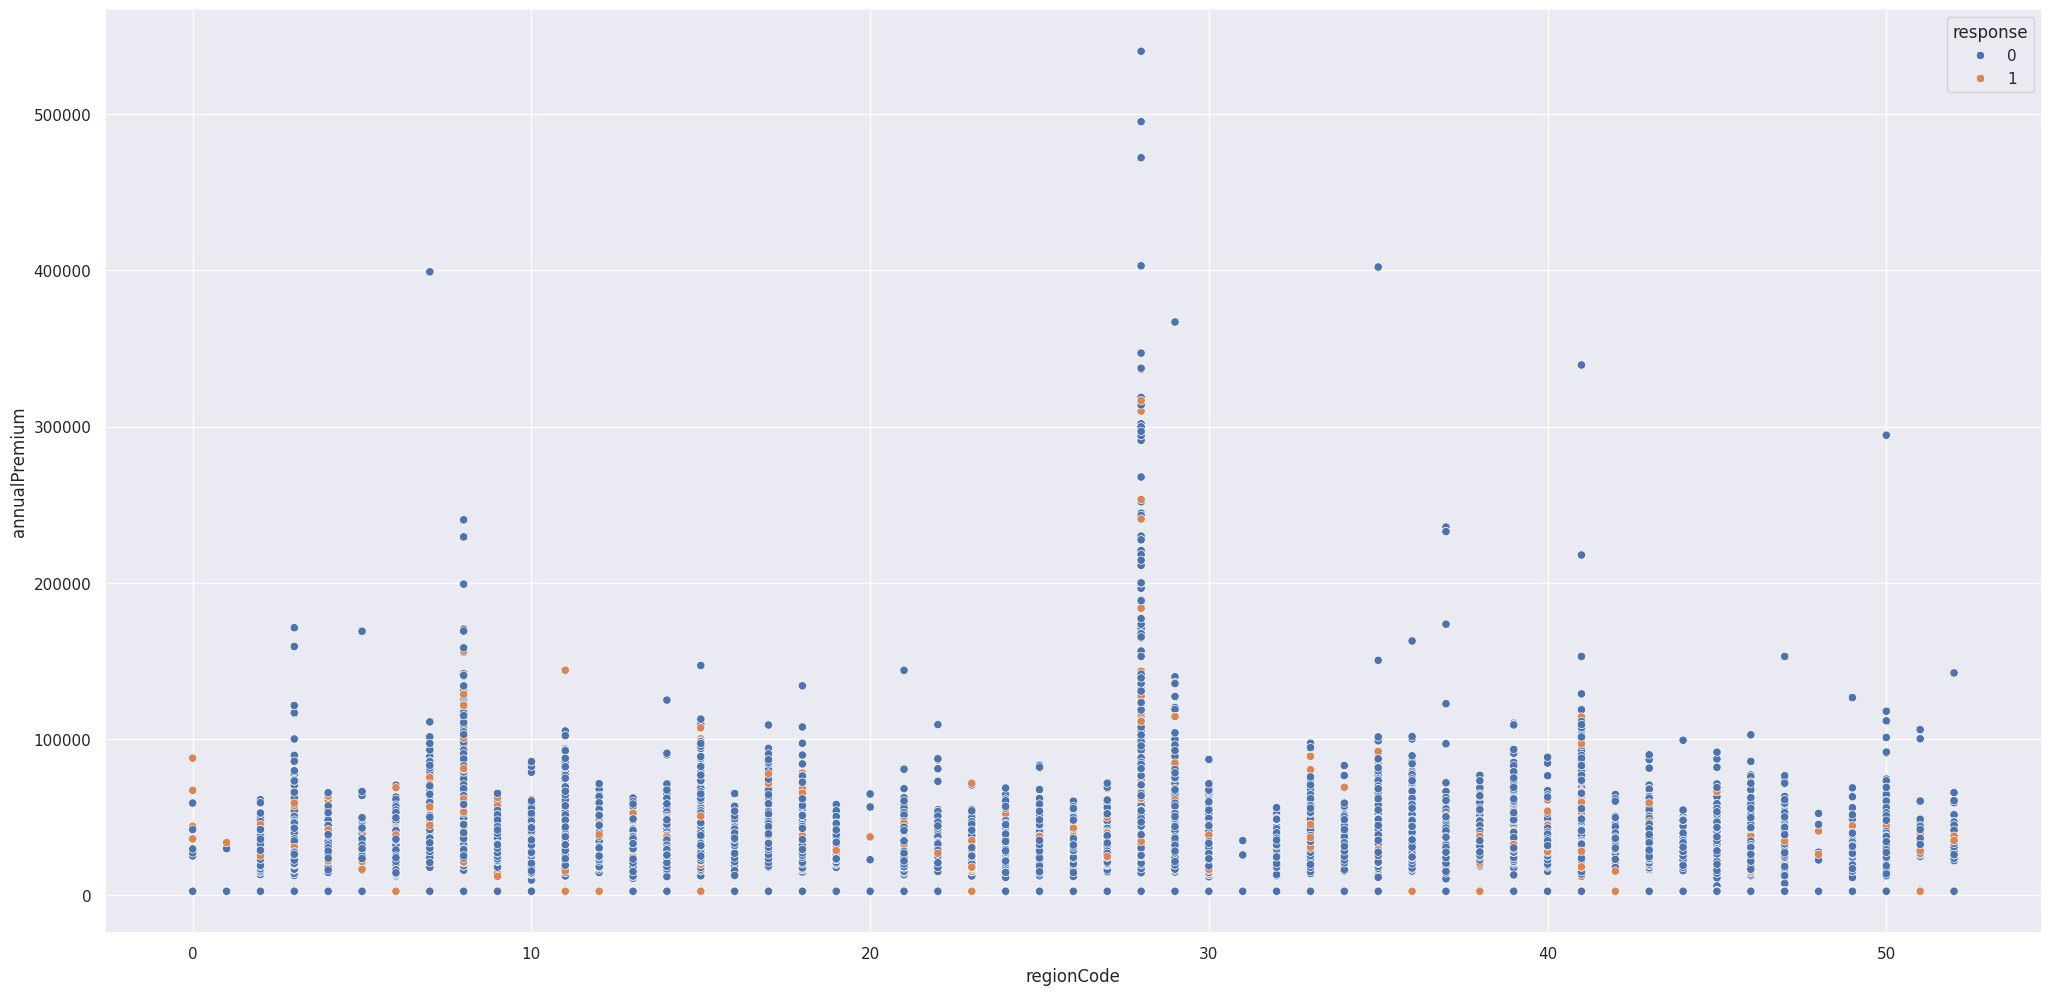

In [69]:
sns.scatterplot(x='regionCode',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Policy Sales Channel

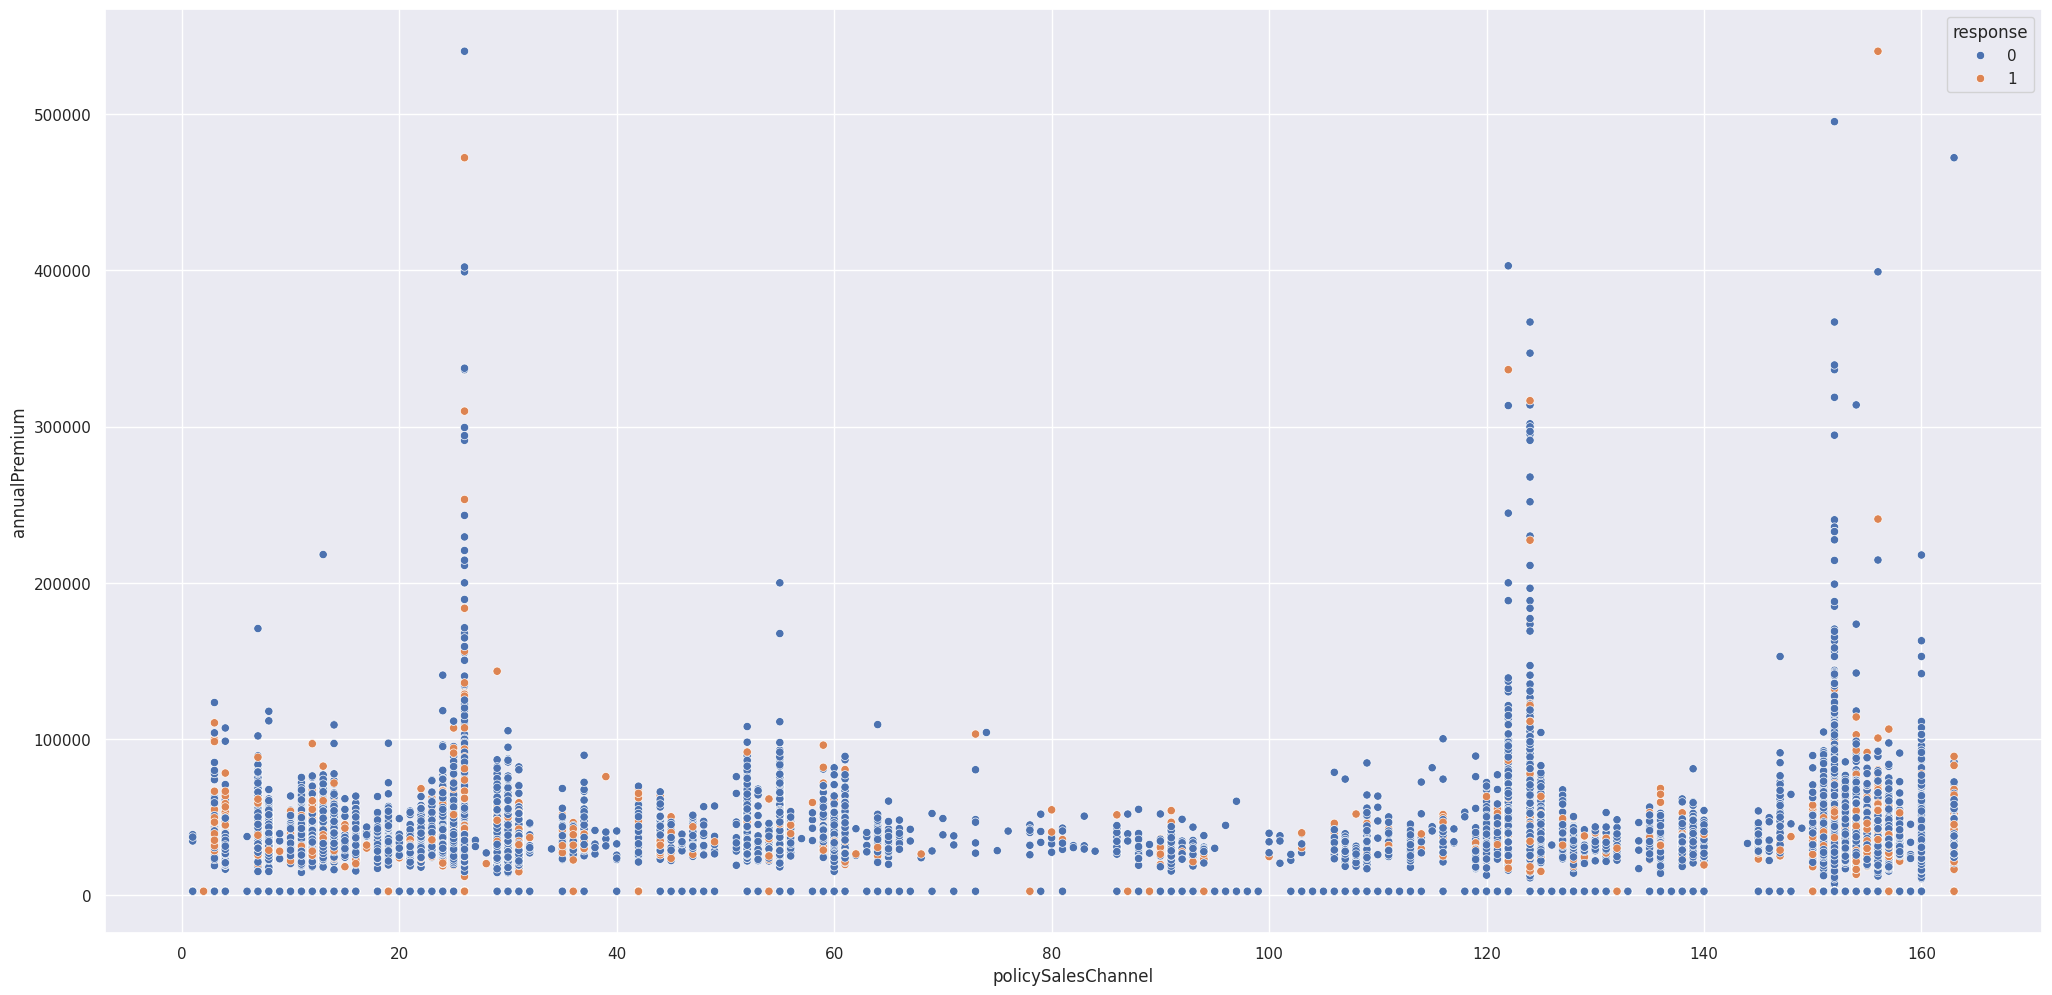

In [70]:
sns.scatterplot(x='policySalesChannel',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Previously Insured

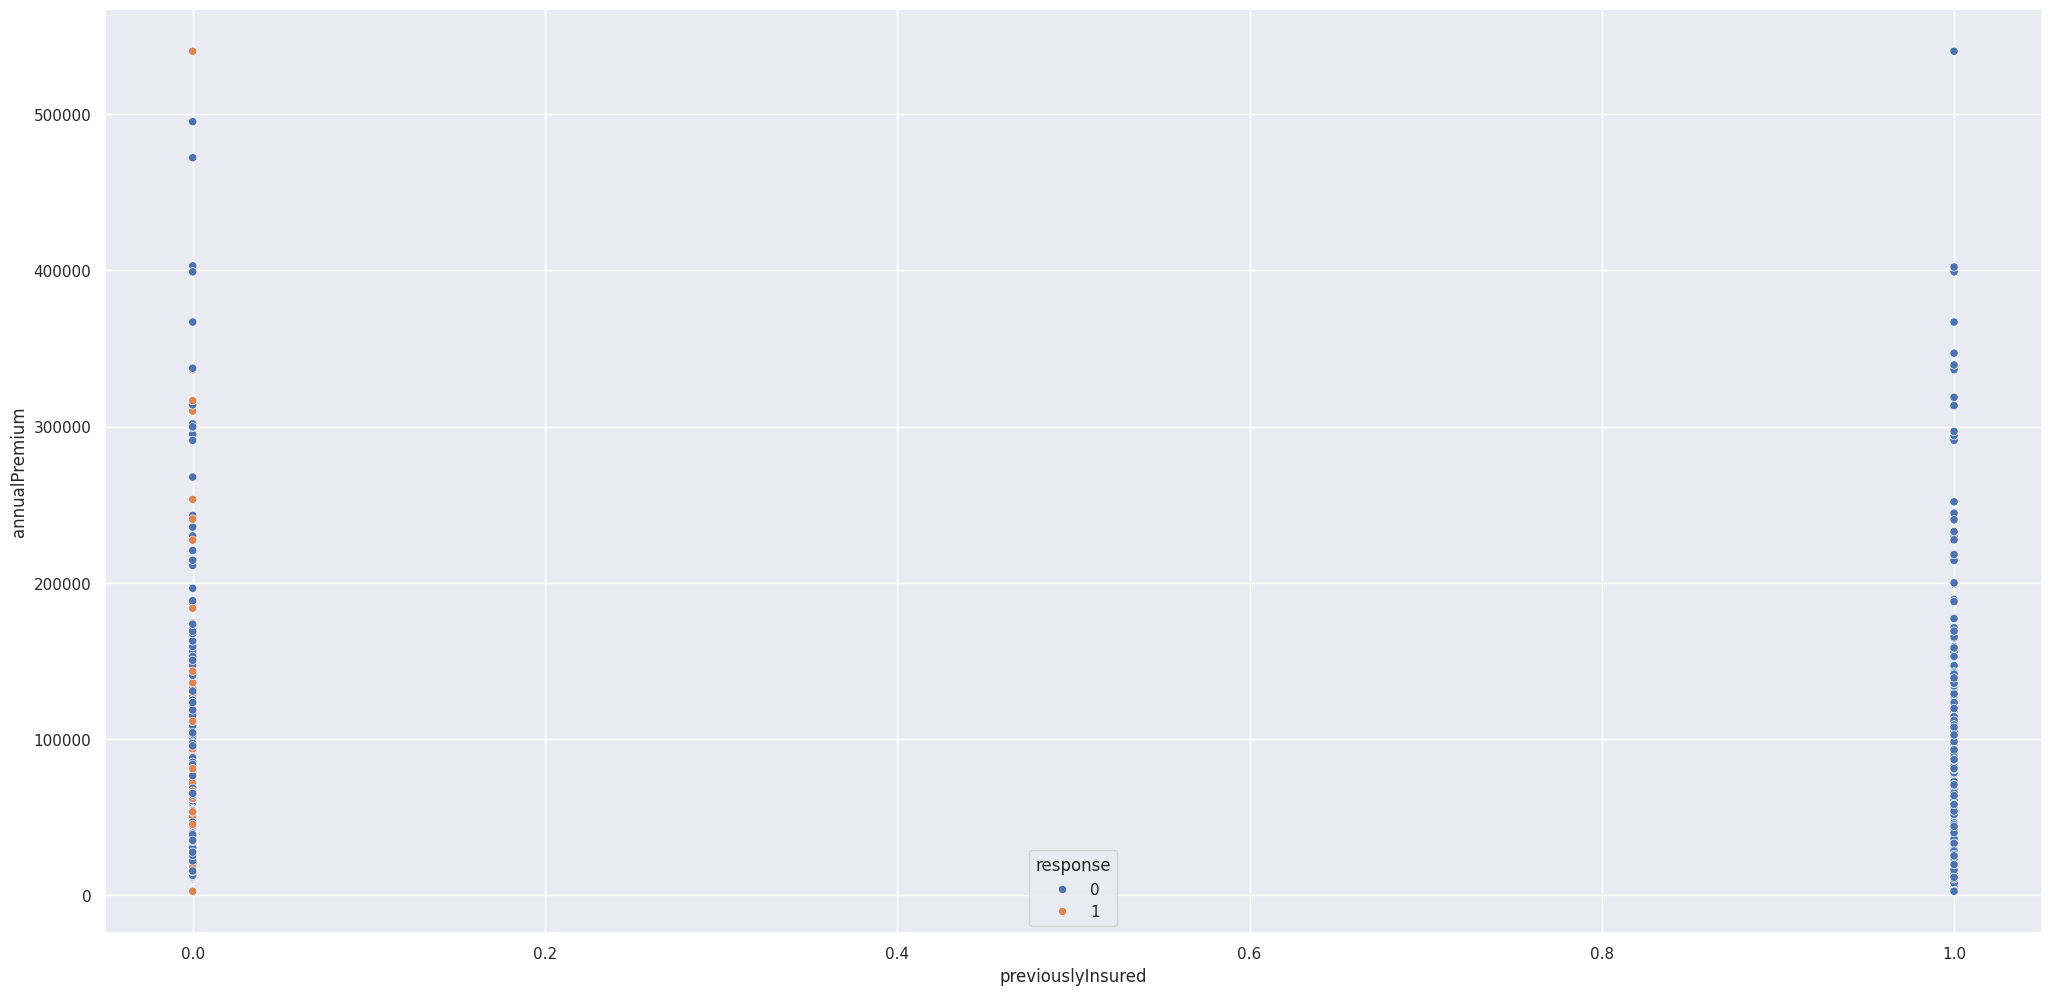

In [71]:
sns.scatterplot(x='previouslyInsured',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Vintage Month

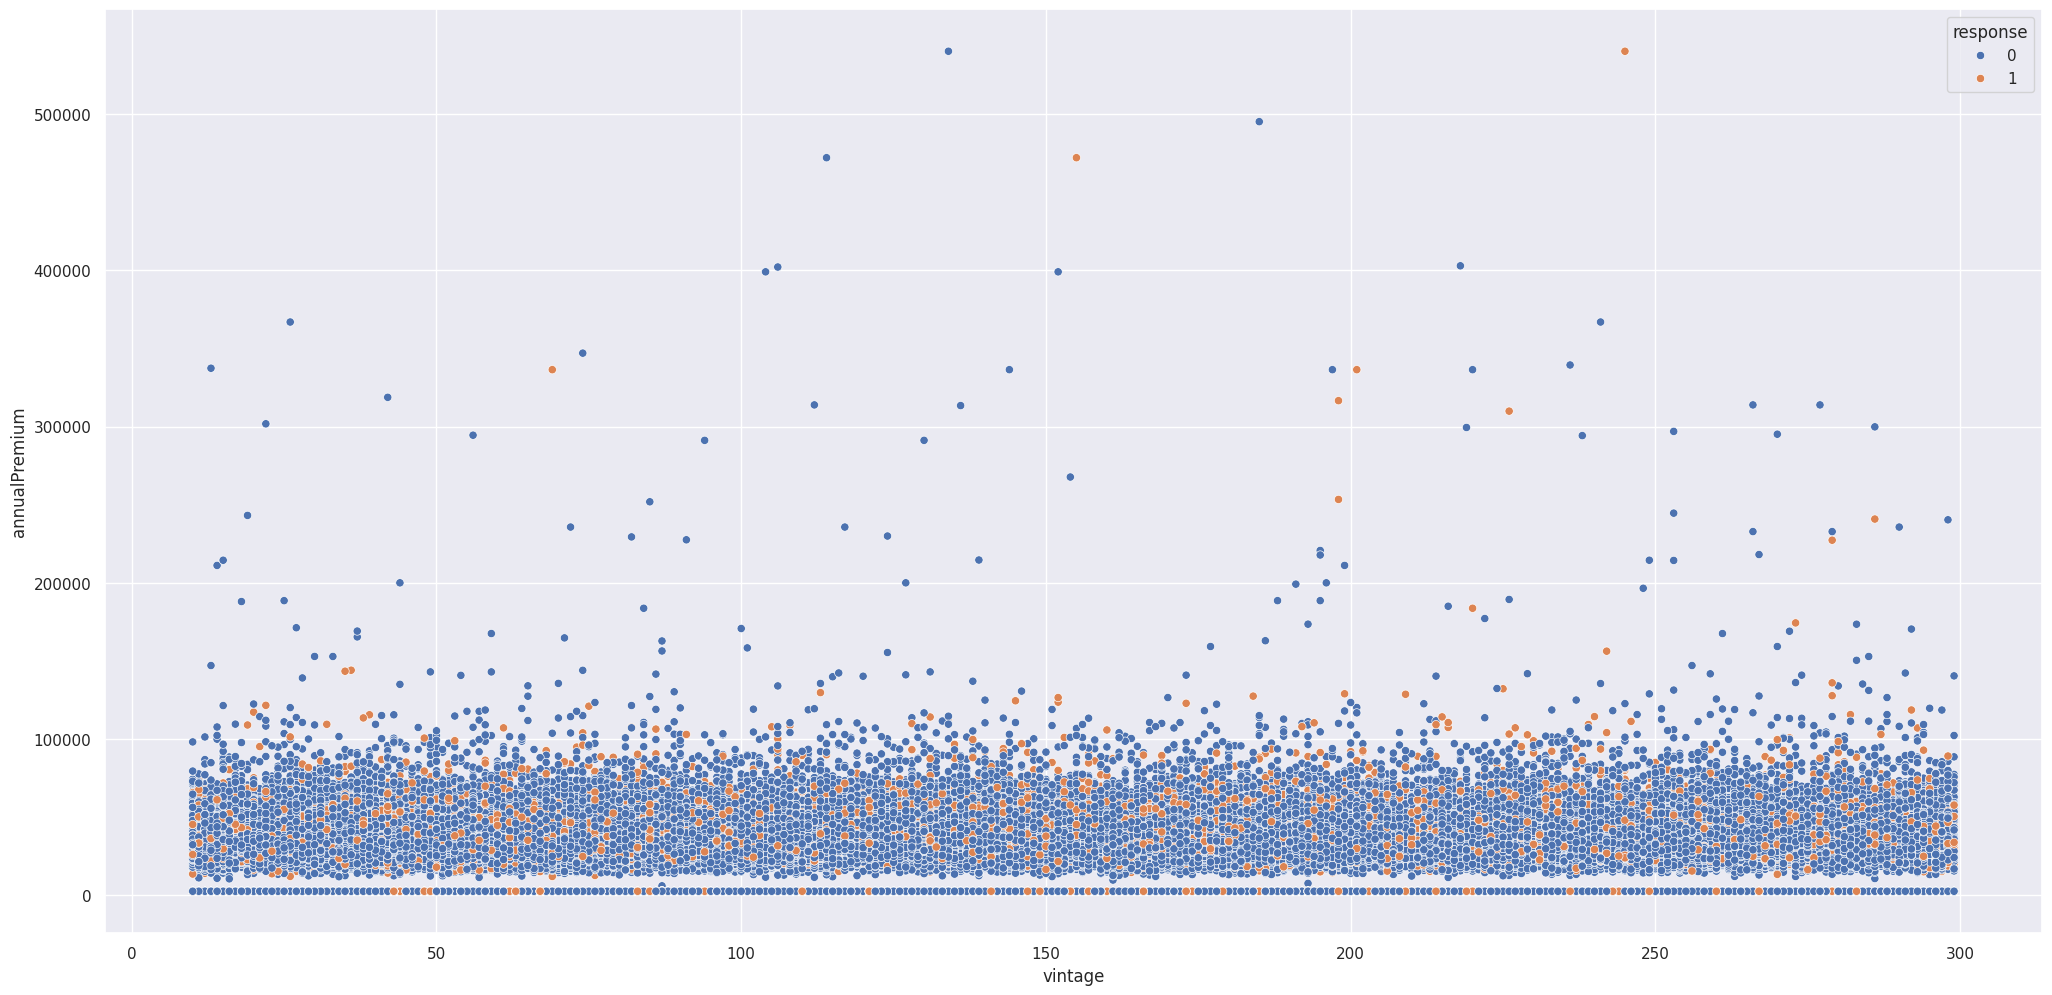

In [72]:
sns.scatterplot(x='vintage',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Age

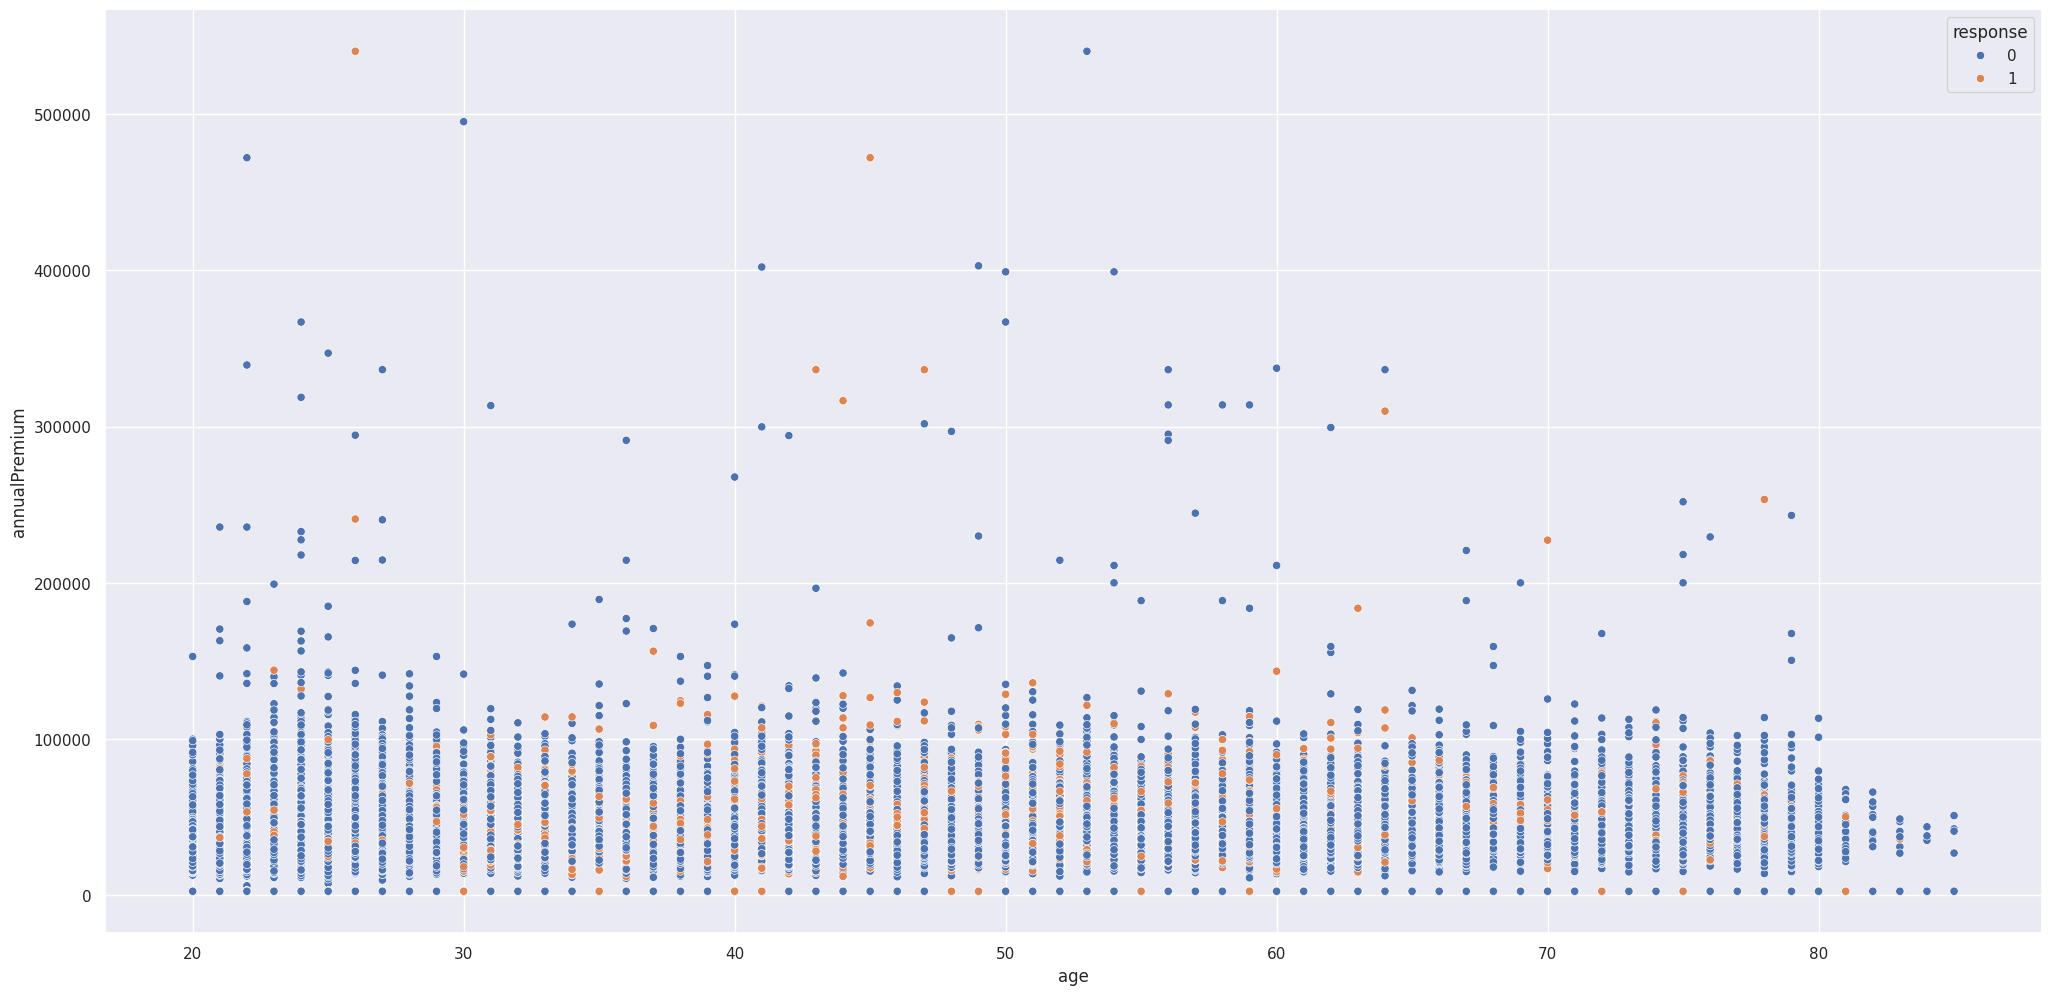

In [73]:
sns.scatterplot(x='age',y='annualPremium',data=df_eda,hue='response');

## 4.4. Multivarible Analysis

### 4.3.1. Numerical Attributes

<Axes: >

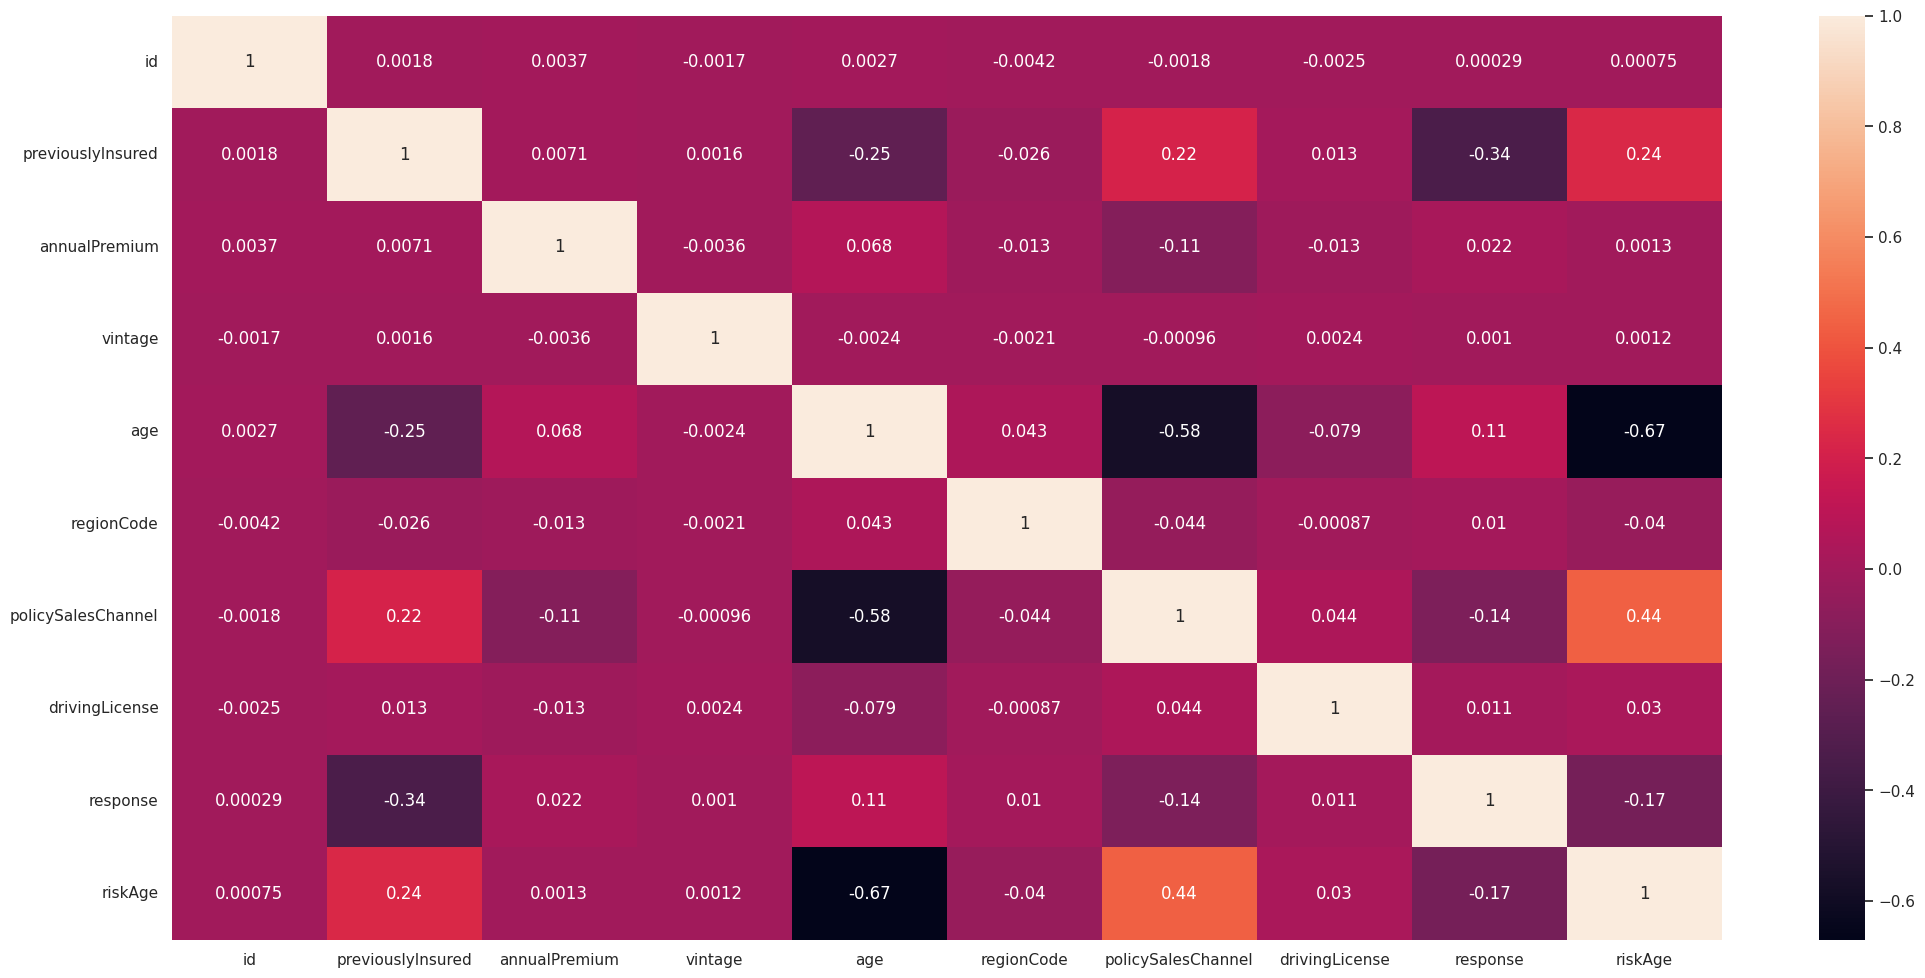

In [74]:
aux= df_eda[numerical_columns].corr()
sns.heatmap(aux,annot=True)

### 4.3.2. Categorical Attributes

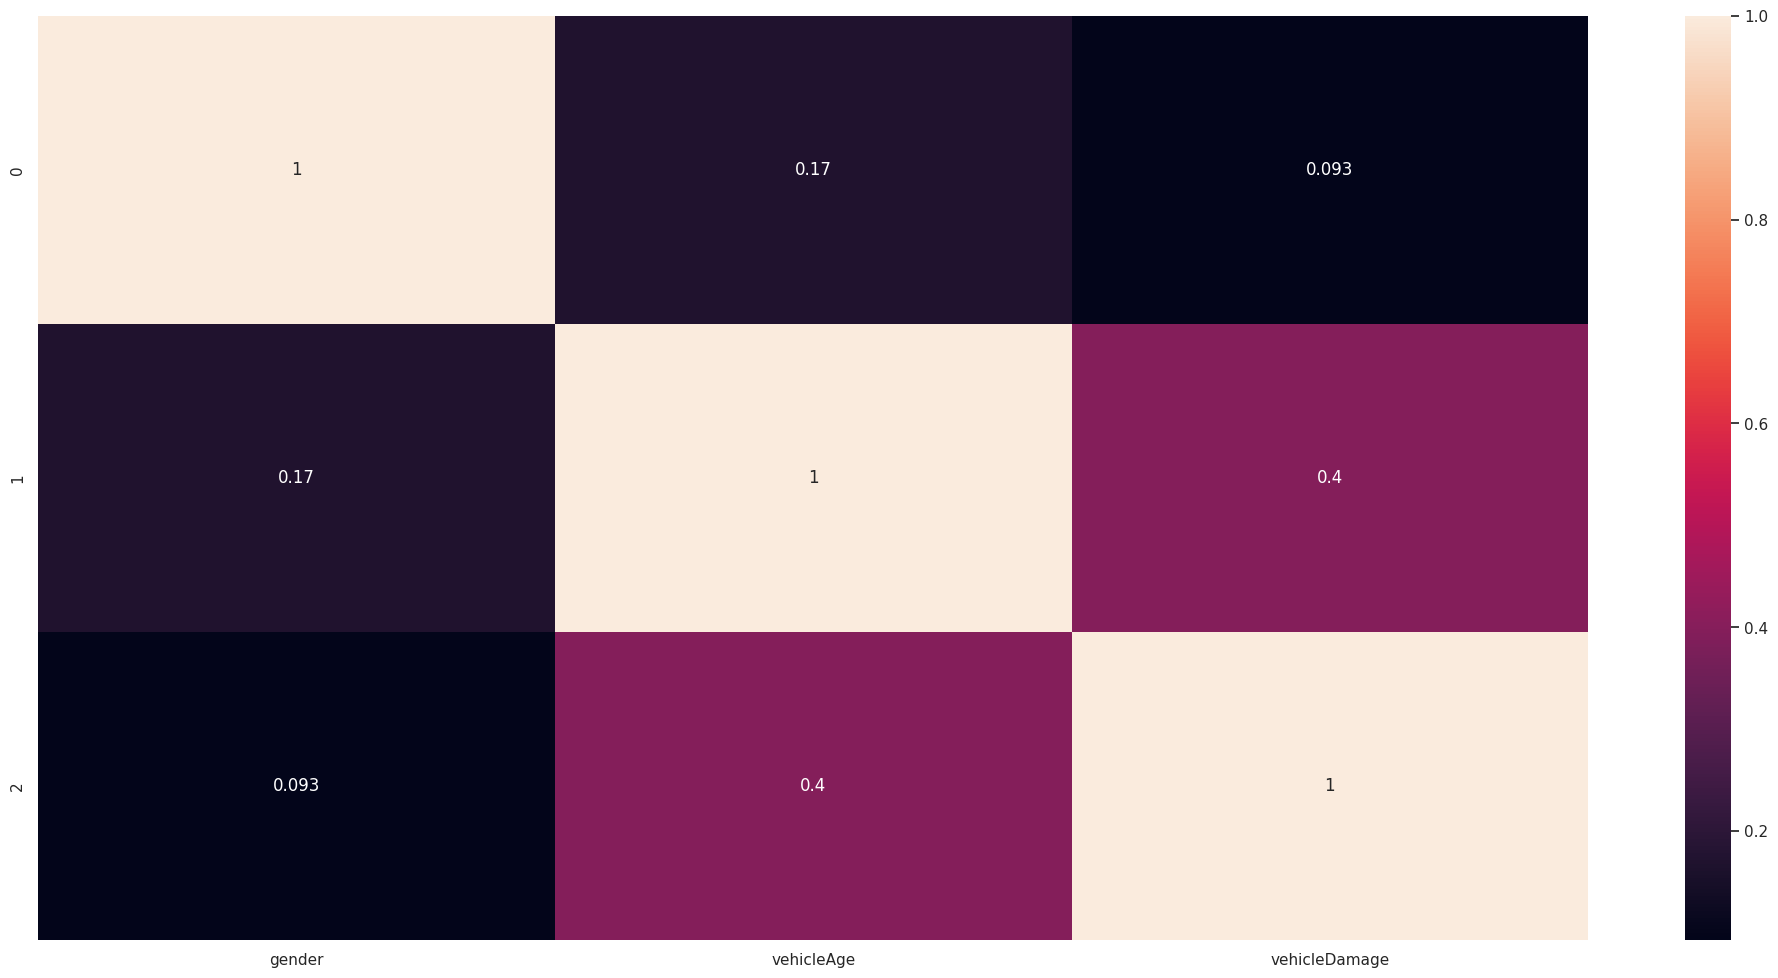

In [75]:
aux=pd.DataFrame(corr_cramer_v(df_eda[categorical_columns]))
sns.heatmap(aux,annot=True);

## 4.4. Hypotheses Insights

**Feature Relevants** 

In my analysis the feature did showed more relevants to modeling the fenomeno are **vehicle Damage, previously insured, vehicle age, driving license,risk Age, age and Gender, respectively**

In step Feature Selection i'll confirm my analysis using some Algorithms to calculate how relevants this features are.

# 5.0. Data Preparation

In [76]:
df_dp=df_fe.copy()
numerical_columns=df_dp.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_columns=df_dp.select_dtypes(exclude=['int64','float64']).columns.tolist()

In [77]:
df_fe.head()

id  previouslyInsured  annualPremium  vintage  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage  response  riskAge
322038  322039                  0     42428.0000      280  Female   54     28.0000             26.0000               1   1-2 Year           Yes         0        0
3178      3179                  0     53117.0000      264  Female   45     28.0000             13.0000               1   1-2 Year           Yes         0        0
214332  214333                  1     27833.0000       98  Female   24     11.0000            152.0000               1   < 1 Year            No         0        1
236018  236019                  1      2630.0000      287  Female   26      1.0000            152.0000               1   < 1 Year            No         0        0
318100  318101                  0     46573.0000       42  Female   45     28.0000            124.0000               1  > 2 Years           Yes         0        0

## 5.1. Numericals

In [78]:
df_dp.head()

id  previouslyInsured  annualPremium  vintage  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage  response  riskAge
322038  322039                  0     42428.0000      280  Female   54     28.0000             26.0000               1   1-2 Year           Yes         0        0
3178      3179                  0     53117.0000      264  Female   45     28.0000             13.0000               1   1-2 Year           Yes         0        0
214332  214333                  1     27833.0000       98  Female   24     11.0000            152.0000               1   < 1 Year            No         0        1
236018  236019                  1      2630.0000      287  Female   26      1.0000            152.0000               1   < 1 Year            No         0        0
318100  318101                  0     46573.0000       42  Female   45     28.0000            124.0000               1  > 2 Years           Yes         0        0

In [79]:
rs=pp.RobustScaler()
mms=pp.MinMaxScaler()
ohe=OneHotEncoder(cols=categorical_columns, use_cat_names=True)

In [80]:
def dp_numericals(df_dp):
    df_dp['annualPremium']=rs.fit_transform(df_dp[['annualPremium']])

    df_dp['vintage']=mms.fit_transform(df_dp[['vintage']])
    df_dp['age']=mms.fit_transform(df_dp[['age']])
    return df_dp

In [81]:
df_dp=dp_numericals(df_dp)

## 5.2. Categorical

In [82]:
fe_regionCode=frequency_enconding(df_dp,'regionCode')
df_dp['regionCode']=df_dp['regionCode'].map(fe_regionCode)

fe_policySalesChannel=frequency_enconding(df_dp,'policySalesChannel')
df_dp['policySalesChannel']=df_dp['policySalesChannel'].map(fe_policySalesChannel)

fe_drivingLicense=frequency_enconding(df_dp,'drivingLicense')
df_dp['drivingLicense']=df_dp['drivingLicense'].map(fe_drivingLicense)

fe_riskAge=frequency_enconding(df_dp,'riskAge')
df_dp['riskAge']=df_dp['riskAge'].map(fe_riskAge)

fe_previouslyInsured=frequency_enconding(df_dp,'previouslyInsured')
df_dp['previouslyInsured']=df_dp['previouslyInsured'].map(fe_previouslyInsured)

In [83]:
y_dp=df_dp['response']
df_dp=ohe.fit_transform(df_dp.drop(['response'],axis=1))
df_dp=df_dp.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})
df_dp['response']=y_dp
df_dp.head()

id  previouslyInsured  annualPremium  vintage  gender_Female  gender_Male    age  regionCode  policySalesChannel  drivingLicense  b1and2  m1  M2  vehicleDamage_Yes  vehicleDamage_No  riskAge  response
322038  322039             0.5423         0.7158   0.9343              1            0 0.5231      0.2795              0.2087          0.9979       1   0   0                  1                 0   0.6998         0
3178      3179             0.5423         1.4275   0.8789              1            0 0.3846      0.2795              0.0048          0.9979       1   0   0                  1                 0   0.6998         0
214332  214333             0.4577        -0.2559   0.3045              1            0 0.0615      0.0245              0.3544          0.9979       0   1   0                  0                 1   0.3002         0
236018  236019             0.4577        -1.9340   0.9585              1            0 0.0923      0.0025              0.3544          0.9979       0   1   0                  0                 1   0.6998         0
318100  318101             0.5423         0.9918   0.1107              1            0 0.3846      0.2795              0.1944          0.9979       0   0   1                  1                 0   0.6998         0

# 6.0. Feature Selection

In [84]:
df_fs=df_dp

In [85]:
df_fs = df_fs.drop(columns=['id'])

In [86]:
x_train = df_fs.drop('response',axis=1)
y_train = df_fs['response']

## 6.1. Feature Importance

Feature: 0, Score: 0.01211
Feature: 1, Score: 0.25660
Feature: 2, Score: 0.26598
Feature: 3, Score: 0.01523
Feature: 4, Score: 0.01516
Feature: 5, Score: 0.13563
Feature: 6, Score: 0.10300
Feature: 7, Score: 0.05614
Feature: 8, Score: 0.00047
Feature: 9, Score: 0.00690
Feature: 10, Score: 0.00276
Feature: 11, Score: 0.00387
Feature: 12, Score: 0.06259
Feature: 13, Score: 0.06251
Feature: 14, Score: 0.00105


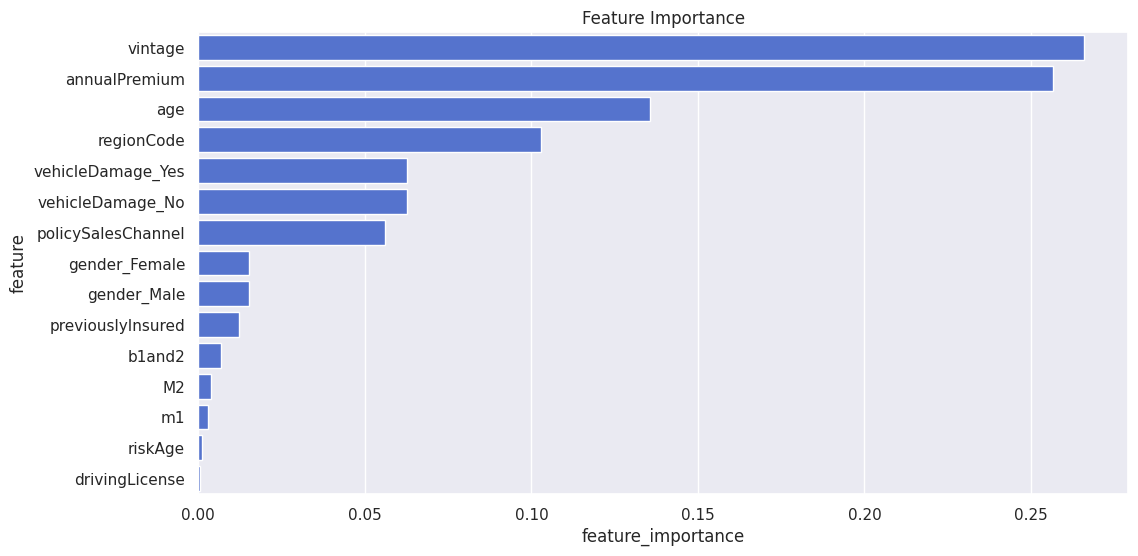

In [87]:
rf = RandomForestRegressor()
# fit the model
rf.fit(x_train, y_train)
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                        'feature_importance': importance})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [88]:
cols_selected_importance = feat_imp['feature'].to_list()
cols_selected_importance

['vintage',
 'annualPremium',
 'age',
 'regionCode',
 'vehicleDamage_Yes',
 'vehicleDamage_No',
 'policySalesChannel',
 'gender_Female',
 'gender_Male',
 'previouslyInsured',
 'b1and2',
 'M2',
 'm1',
 'riskAge',
 'drivingLicense']

## 6.2. Boruta

In [89]:
#definindo dataset de treino e teste para o Boruta
x_train_b = x_train.values
y_train_b = y_train.values.ravel()
rf=RandomForestClassifier( n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=0,random_state=seed).fit(x_train_b,y_train_b)

In [90]:
#comentado para não fazer o algoritimo do boruta#
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
cols_selected_boruta

['age']

## 6.3. Columns Selected


In EDA step, I identified 6 features (vehicle Damage, previously insured, vehicle age, driving license,risk Age, age and Gender), in this step only 3(vehicle Damage, previously insured and Age), showed more relevant to the model.

In [91]:
cols_selected=['previouslyInsured',
 'annualPremium',
 'vintage',
 'age',
 'regionCode',
 'policySalesChannel',
 'vehicleDamage_No',
 'vehicleDamage_Yes']

In [92]:
x_train=x_train[cols_selected]

## 6.1 Preparing Validation Dataset

In [93]:
x_val_bkp=x_val.copy()

In [94]:
# Aplicando transformações no x_test separado no passo Feature Engieneering
idsVal=x_val['id']
## Feature Engieneering
x_val=feature_Engieneering(x_val)

## Data Preparation
x_val=dp_numericals(x_val)

x_val['regionCode']=x_val['regionCode'].map(fe_regionCode)
x_val['policySalesChannel']=x_val['policySalesChannel'].map(fe_policySalesChannel)
x_val['drivingLicense']=x_val['drivingLicense'].map(fe_drivingLicense)
x_val['riskAge']=x_val['riskAge'].map(fe_riskAge)
x_val['previouslyInsured']=x_val['previouslyInsured'].map(fe_previouslyInsured)

x_val=ohe.transform(x_val)
x_val=x_val.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})



## Feature Selection
x_val=x_val[cols_selected]
x_val=x_val.fillna(0)

# 7.0. Machine Learning

In [95]:
models_performance=pd.DataFrame()

## 7.1. Comparing Models

In [96]:
models_list=[
                xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytree=0.9),
                LogisticRegression(penalty='l2', solver='newton-cg'),
                GaussianNB(),
                RandomForestClassifier(n_estimators=100,random_state=seed),
                KNeighborsClassifier(n_jobs=-1),
                LGBMClassifier()
            ]

models_performance = models_train(models_list, x_train, y_train, x_val, y_val, 'predict_proba', 'binaryClass', 0)
models_performance

XGBClassifier
LogisticRegression
GaussianNB
RandomForestClassifier
KNeighborsClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122562 -> initscore=-1.968388
[LightGBM] [Info] Start training from score -1.968388


Model  ROC AUC  Top K Score
0           XGBClassifier   0.8626       0.8771
1      LogisticRegression   0.8144       0.8771
2              GaussianNB   0.8251       0.6385
3  RandomForestClassifier   0.9629       0.9479
4    KNeighborsClassifier   0.8584       0.8816
5          LGBMClassifier   0.8614       0.8770

## 7.2. XGBoost

In [97]:
model_xgb = models_list[0].fit(x_train,y_train)
yhat_proba_xgb = model_xgb.predict_proba(x_val)

## 7.3. Logistic Regression

In [98]:
model_rLog = models_list[1].fit(x_train,y_train)
yhat_proba_rLog = model_rLog.predict_proba(x_val)

## 7.4. Naive Bayes

In [99]:
model_naiveBayes =models_list[2].fit(x_train,y_train)
yhat_proba_naiveBayes=model_naiveBayes.predict_proba(x_val)

## 7.5. Random Forest

In [100]:
model_rf = models_list[3].fit(x_train,y_train)
yhat_proba_rf= model_rf.predict_proba(x_val)

## 7.6. KNN

In [101]:
model_knn = models_list[4].fit(x_train,y_train)
yhat_proba_knn = model_knn.predict_proba(x_val)

## 7.7. LGBM

In [102]:
model_lgbm = models_list[5].fit(x_train,y_train)
yhat_proba_lgbm = model_lgbm.predict_proba(x_val)

[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122562 -> initscore=-1.968388
[LightGBM] [Info] Start training from score -1.968388


## 7.7. Models Performance

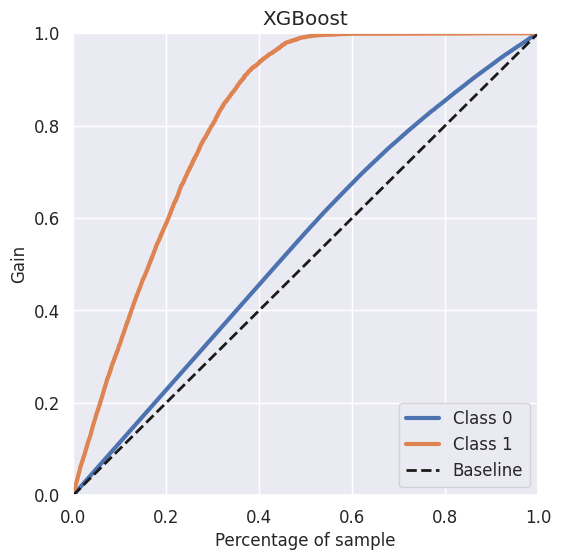

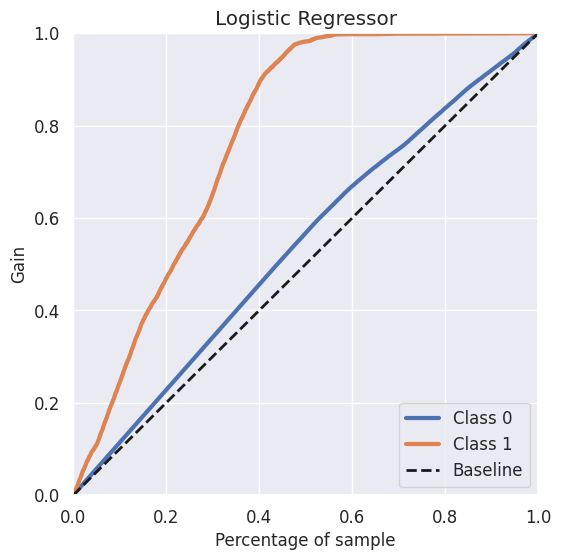

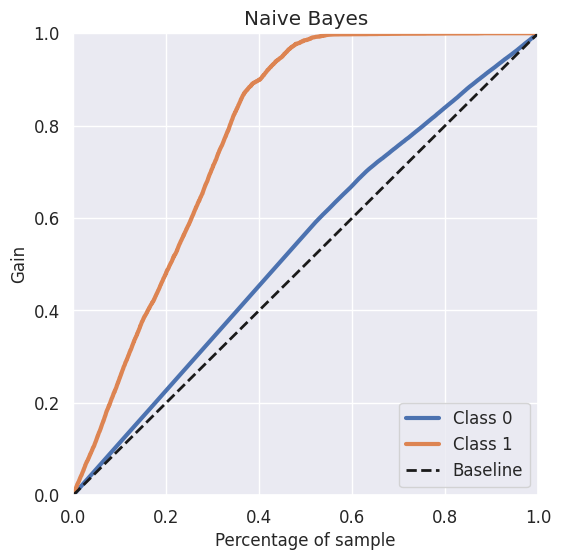

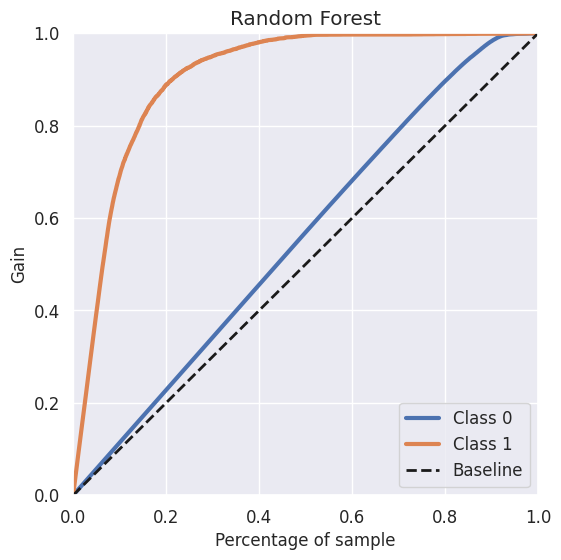

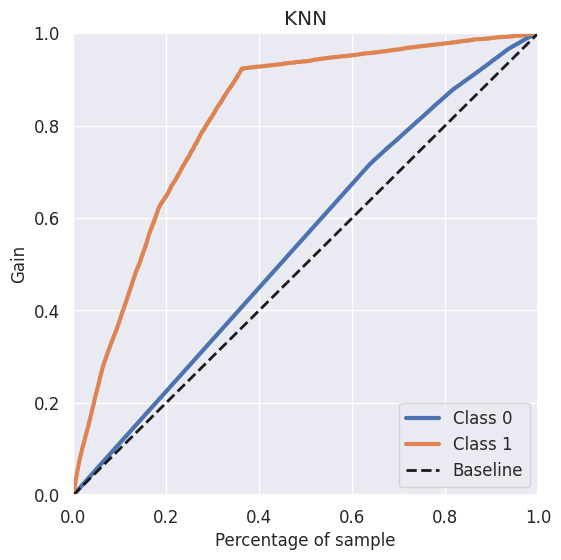

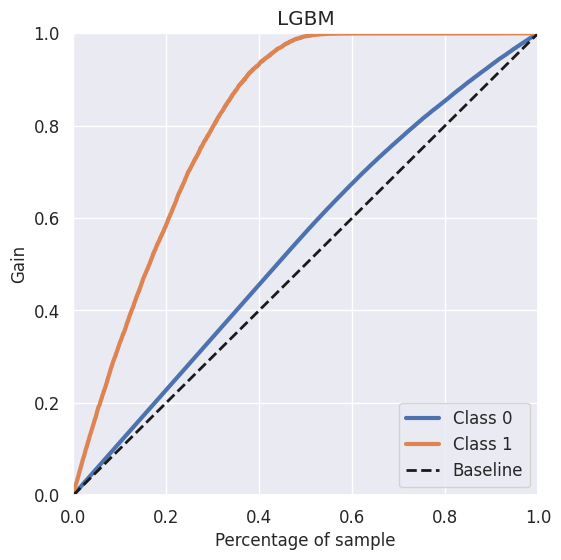

In [103]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb,figsize =(6,6),title='XGBoost');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rLog,figsize =(6,6),title='Logistic Regressor');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_naiveBayes,figsize =(6,6),title='Naive Bayes');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rf,figsize =(6,6),title='Random Forest');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn,figsize =(6,6),title='KNN');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm,figsize =(6,6),title='LGBM');

# 8.0. Crossvalidation

## 8.1. XGBoost

In [104]:
models_performance = pd.concat([models_performance, cross_validation(5, 'XGBoost', model_xgb, x_train, y_train, ranking_class_metrics)], ignore_index=True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.2. Logistic Regression

In [105]:
models_performance = pd.concat([models_performance, cross_validation(5, 'Logistic Regression', model_rLog, x_train, y_train, ranking_class_metrics)], ignore_index=True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.3. Naive Bayes

In [106]:
models_performance = pd.concat([models_performance, cross_validation(5,'GaussianNB',model_naiveBayes,x_train,y_train,ranking_class_metrics)],ignore_index=True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.4. Random Forest

In [107]:
models_performance = pd.concat([models_performance, cross_validation(5,'Random Forest',model_rf,x_train,y_train,ranking_class_metrics)],ignore_index=True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.5. KNN

In [108]:
models_performance = pd.concat([models_performance, cross_validation(5,'KNN',model_knn,x_train,y_train,ranking_class_metrics)],ignore_index=True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.6. LGBM

In [109]:
models_performance = pd.concat([models_performance, cross_validation(5,'LGBM',model_lgbm,x_train,y_train,ranking_class_metrics)],ignore_index=True)

Fold Number 1/5
[LightGBM] [Info] Number of positive: 23915, number of negative: 171212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122561 -> initscore=-1.968397
[LightGBM] [Info] Start training from score -1.968397
Fold Number 2/5
[LightGBM] [Info] Number of positive: 23915, number of negative: 171212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 195127, number of use

## 8.7. Crossvalidation Performance

In [110]:
models_performance.sort_values('Model')

Model  ROC AUC  Top K Score
2                  GaussianNB   0.8251       0.6385
16           GaussianNB - 1/5   0.7828       0.6377
17           GaussianNB - 2/5   0.7837       0.6375
18           GaussianNB - 3/5   0.7848       0.6394
19           GaussianNB - 4/5   0.7825       0.6359
20           GaussianNB - 5/5   0.7826       0.6357
26                  KNN - 1/5   0.5566       0.8541
27                  KNN - 2/5   0.5578       0.8545
28                  KNN - 3/5   0.5553       0.8546
29                  KNN - 4/5   0.5568       0.8533
30                  KNN - 5/5   0.5584       0.8529
4        KNeighborsClassifier   0.8584       0.8816
31                 LGBM - 1/5   0.5002       0.8773
32                 LGBM - 2/5   0.5006       0.8773
33                 LGBM - 3/5   0.5003       0.8774
34                 LGBM - 4/5   0.5003       0.8774
35                 LGBM - 5/5   0.5001       0.8773
5              LGBMClassifier   0.8614       0.8770
11  Logistic Regression - 1/5   0.5000       0.8774
12  Logistic Regression - 2/5   0.5000       0.8774
13  Logistic Regression - 3/5   0.5000       0.8774
14  Logistic Regression - 4/5   0.5000       0.8774
15  Logistic Regression - 5/5   0.5000       0.8775
1          LogisticRegression   0.8144       0.8771
21        Random Forest - 1/5   0.5436       0.8666
22        Random Forest - 2/5   0.5446       0.8668
23        Random Forest - 3/5   0.5439       0.8662
24        Random Forest - 4/5   0.5450       0.8670
25        Random Forest - 5/5   0.5448       0.8648
3      RandomForestClassifier   0.9629       0.9479
0               XGBClassifier   0.8626       0.8771
6               XGBoost - 1/5   0.5000       0.8774
7               XGBoost - 2/5   0.5000       0.8774
8               XGBoost - 3/5   0.5000       0.8774
9               XGBoost - 4/5   0.5000       0.8774
10              XGBoost - 5/5   0.5000       0.8775

# 9.0. Hyper Parameters

In [111]:
max_eval=5

In [112]:
hp_result=pd.DataFrame()

## 9.1. LGBM

In [113]:
lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [114]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in lgbm_parameter.items()}
    print(hp)
    model_lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree']).fit(x_train,y_train)

    yhat_lgbm=model_lgbm.predict_proba(x_val)
    lgbm_result_hp=ranking_class_metrics('LGBM -'+str(i),y_val,yhat_lgbm[:,1],0)
    hp_result=pd.concat([hp_result,lgbm_result_hp])
hp_result

{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 0.1}
[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122562 -> initscore=-1.968388
[LightGBM] [Info] Start training from score -1.968388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

Model  ROC AUC  Top K Score
0  LGBM -0   0.8555       0.8771
0  LGBM -1   0.8592       0.8772
0  LGBM -2   0.8526       0.8771
0  LGBM -3   0.8596       0.8772
0  LGBM -4   0.8555       0.8771

## 9.2. XGBoost

In [115]:
xgb_param = {'n_estimators': [80,100,150,200,500,1500,2500,3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9]}

In [116]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in xgb_param.items()}
    print(hp)
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree']).fit(x_train,y_train)

    yhat_xgb=model_xgb.predict_proba(x_val)
    xgb_result_hp=ranking_class_metrics('XGBoost'+str(i),y_val,yhat_xgb[:,1],0)
    hp_result=pd.concat([hp_result,xgb_result_hp])
hp_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3}
{'n_estimators': 500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7}


Model  ROC AUC  Top K Score
0   LGBM -0   0.8555       0.8771
0   LGBM -1   0.8592       0.8772
0   LGBM -2   0.8526       0.8771
0   LGBM -3   0.8596       0.8772
0   LGBM -4   0.8555       0.8771
0  XGBoost0   0.8627       0.8773
0  XGBoost1   0.8667       0.8776
0  XGBoost2   0.8495       0.8771
0  XGBoost3   0.8477       0.8771
0  XGBoost4   0.8635       0.8772

## 9.3. Random Forest

In [117]:
rf_param = {
            # 'bootstrap': [True, False],
            # 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            # 'max_features': ['log2', 'sqrt'],
            # 'min_samples_leaf': [1, 2, 4],
            # 'min_samples_split': [2, 5, 10],
            'n_estimators': [100],
            'n_jobs':[-1],
            'random_state':[seed]
            }

In [118]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in rf_param.items()}
    print(hp)
    model_rf = RandomForestClassifier(
                                    n_estimators= hp['n_estimators'],
                                    n_jobs= hp['n_jobs'],
                                    random_state=hp['random_state']).fit(x_train,y_train)

    yhat_rf=model_rf.predict_proba(x_val)
    rf_result_hp=ranking_class_metrics('Random Forest random state - ' + str(i),y_val,yhat_rf[:,1],0)
    hp_result=pd.concat([hp_result,rf_result_hp])
hp_result

{'n_estimators': 100, 'n_jobs': -1, 'random_state': 77}
{'n_estimators': 100, 'n_jobs': -1, 'random_state': 77}
{'n_estimators': 100, 'n_jobs': -1, 'random_state': 77}
{'n_estimators': 100, 'n_jobs': -1, 'random_state': 77}
{'n_estimators': 100, 'n_jobs': -1, 'random_state': 77}


Model  ROC AUC  Top K Score
0                         LGBM -0   0.8555       0.8771
0                         LGBM -1   0.8592       0.8772
0                         LGBM -2   0.8526       0.8771
0                         LGBM -3   0.8596       0.8772
0                         LGBM -4   0.8555       0.8771
0                        XGBoost0   0.8627       0.8773
0                        XGBoost1   0.8667       0.8776
0                        XGBoost2   0.8495       0.8771
0                        XGBoost3   0.8477       0.8771
0                        XGBoost4   0.8635       0.8772
0  Random Forest random state - 0   0.9629       0.9479
0  Random Forest random state - 1   0.9629       0.9479
0  Random Forest random state - 2   0.9629       0.9479
0  Random Forest random state - 3   0.9629       0.9479
0  Random Forest random state - 4   0.9629       0.9479

## 9.4. Hyper Parameters Performances

In [119]:
hp_result.sort_values('Top K Score',ascending=False)

Model  ROC AUC  Top K Score
0  Random Forest random state - 0   0.9629       0.9479
0  Random Forest random state - 1   0.9629       0.9479
0  Random Forest random state - 2   0.9629       0.9479
0  Random Forest random state - 3   0.9629       0.9479
0  Random Forest random state - 4   0.9629       0.9479
0                        XGBoost1   0.8667       0.8776
0                        XGBoost0   0.8627       0.8773
0                        XGBoost4   0.8635       0.8772
0                         LGBM -3   0.8596       0.8772
0                         LGBM -1   0.8592       0.8772
0                         LGBM -0   0.8555       0.8771
0                         LGBM -2   0.8526       0.8771
0                         LGBM -4   0.8555       0.8771
0                        XGBoost2   0.8495       0.8771
0                        XGBoost3   0.8477       0.8771

The best result was **Random Forest** with 89,15% score, but the standart parameters scored **89,16%**, os I'll use the standart parameters

# 10.0. Final Models

In [120]:
rf_bp={'n_estimators': 100, 'n_jobs': -1, 'random_state': seed}
xgb_bp={'objective':'binary:logistic','eval_metric':'error','n_estimators':100,'eta':0.01,'max_depth':10,'subsample':0.7,'colsample_bytree':0.9}
lgbm_bp={'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 1}

In [121]:
model_performance=pd.DataFrame()

### Preparing Test Dataset

In [122]:
x_train=pd.concat([x_train,x_val],axis=0)
y_train=pd.concat([y_train,y_val],axis=0)

### Preparing Test Dataset

In [123]:
# Aplicando transformações no x_test separado no passo Feature Engieneering
idsTest=x_test['id']

## Feature Engieneering
x_test=feature_Engieneering(x_test)

## Data Preparation
x_test=dp_numericals(x_test)

x_test['regionCode']=x_test['regionCode'].map(fe_regionCode)
x_test['policySalesChannel']=x_test['policySalesChannel'].map(fe_policySalesChannel)
x_test['drivingLicense']=x_test['drivingLicense'].map(fe_drivingLicense)
x_test['riskAge']=x_test['riskAge'].map(fe_riskAge)
x_test['previouslyInsured']=x_test['previouslyInsured'].map(fe_previouslyInsured)

x_test=ohe.transform(x_test)
x_test=x_test.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})

## Feature Selection
x_test=x_test[cols_selected]
x_test=x_test.fillna(0)

## 10.1 Random Forest

In [124]:
rf = RandomForestClassifier(
                        n_estimators=rf_bp['n_estimators'],
                        n_jobs=rf_bp['n_jobs'],
                        random_state=rf_bp['random_state']).fit(x_train,y_train)
yhat_proba_rf= rf.predict_proba(x_test)
model_performance = pd.concat([model_performance, ranking_class_metrics('Random Forest',y_test,yhat_proba_rf[:,1],0)], ignore_index=True)
model_performance

Model  ROC AUC  Top K Score
0  Random Forest   0.8672       0.8842

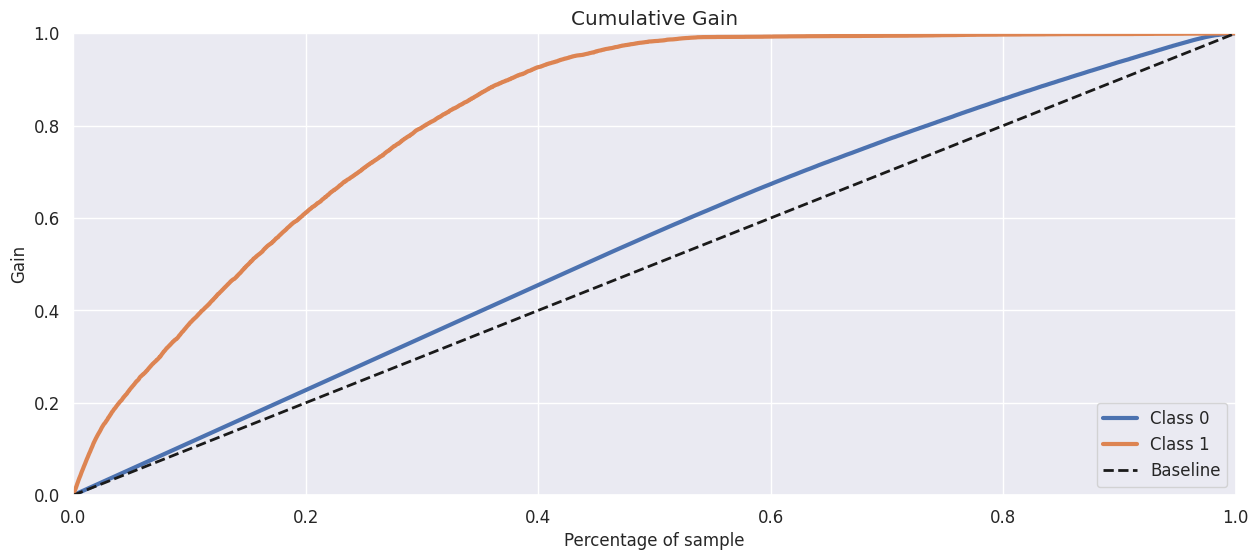

In [125]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_rf,figsize =(15,6),title='Cumulative Gain');

In [126]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [127]:
precision=precision_at_k(df_mp,yhat_proba_rf,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_rf,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.37448343719252214
Recall at K: 0.6111111111111112


## 10.2XGBoost

In [128]:
mxgb=xgb.XGBClassifier(n_estimators=xgb_bp['n_estimators'], 
                      eta=xgb_bp['eta'],
                      max_depth=xgb_bp['max_depth'],
                      subsample=xgb_bp['subsample'],
                      colsample_bytree=xgb_bp['colsample_bytree']).fit(x_train,y_train)
yhat_proba_xgb= mxgb.predict_proba(x_test)
model_performance = pd.concat([model_performance, ranking_class_metrics('XGBooster',y_test,yhat_proba_xgb[:,1],0)], ignore_index=True)
model_performance

Model  ROC AUC  Top K Score
0  Random Forest   0.8672       0.8842
1      XGBooster   0.8535       0.8774

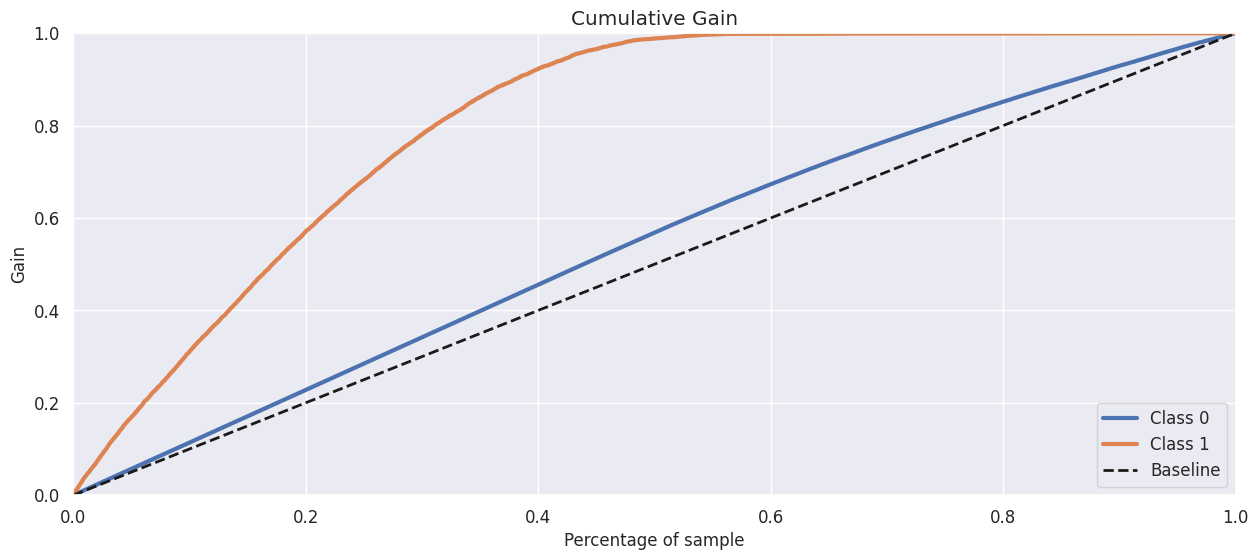

In [129]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_xgb,figsize =(15,6),title='Cumulative Gain');

In [130]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [131]:
precision=precision_at_k(df_mp,yhat_proba_xgb,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_xgb,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.34975401771072484
Recall at K: 0.570755726825091


## 10.3 LGBM

In [132]:
lgbm=LGBMClassifier(num_leaves=lgbm_bp['num_leaves'],
                    max_depth=lgbm_bp['max_depth'],
                    min_split_gain=lgbm_bp['min_split_gain'],
                    min_chiild_weight=lgbm_bp['min_child_weight'],
                    subsample=lgbm_bp['subsample'],
                    colsample_bytree=lgbm_bp['colsample_bytree']).fit(x_train,y_train)
yhat_proba_lgbm= lgbm.predict_proba(x_test)
model_performance = pd.concat([model_performance, ranking_class_metrics('LGBM',y_test,yhat_proba_lgbm[:,1],0)], ignore_index=True)
model_performance

[LightGBM] [Warning] Unknown parameter: min_chiild_weight
[LightGBM] [Warning] Unknown parameter: min_chiild_weight
[LightGBM] [Info] Number of positive: 37386, number of negative: 267501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122622 -> initscore=-1.967827
[LightGBM] [Info] Start training from score -1.967827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Model  ROC AUC  Top K Score
0  Random Forest   0.8672       0.8842
1      XGBooster   0.8535       0.8774
2           LGBM   0.8541       0.8775

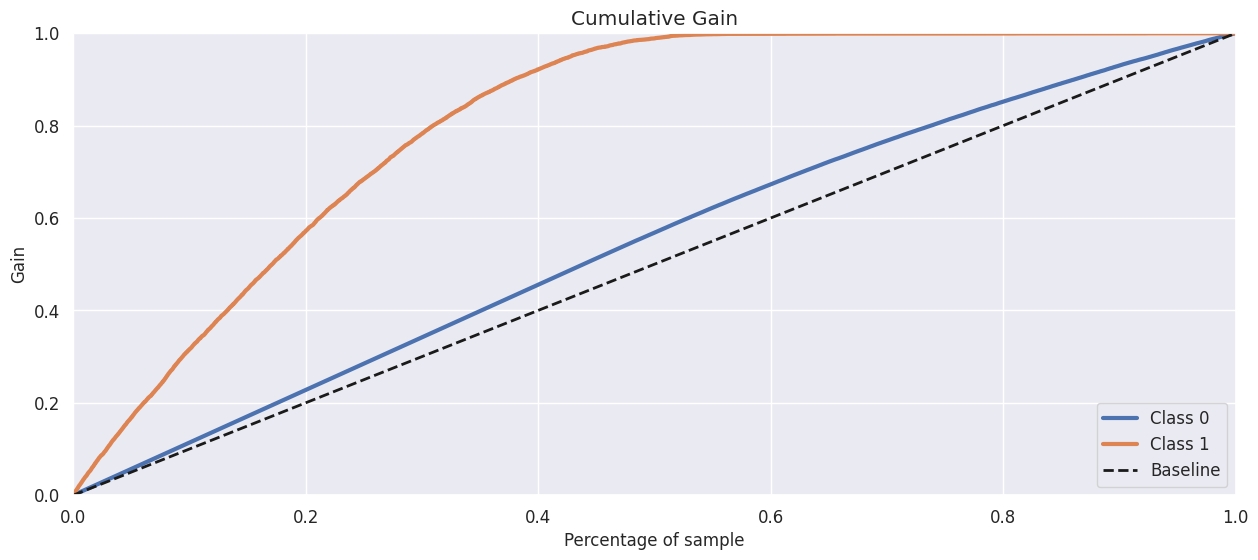

In [133]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

In [134]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [135]:
precision=precision_at_k(df_mp,yhat_proba_lgbm,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_lgbm,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.3504755657592653
Recall at K: 0.5719332048811817


## 10.4 Precision/Recall Comparasion

In [136]:
df_final_performance=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_rf, yhat_proba_xgb, yhat_proba_lgbm]
perc=[0.01,0.05,0.1,0.2,0.3,0.4,0.5]

df_final_performance = pd.concat([df_final_performance, topK_performance(df_mp, probas, 'response', perc)])

In [137]:
df_final_performance.loc[:6, 'Model'] = 'Random Forest'
df_final_performance.loc[7:13, 'Model'] = 'XBoost'
df_final_performance.loc[14:, 'Model'] = 'LGBM'

#### 1% of data

In [138]:
df_final_performance[df_final_performance['perc']==0.01].sort_values(['perc','recall'],ascending=False)

Model   perc    k  precision  recall  target_total  target_at_k  perc_target
0   Random Forest 0.0100  762     0.8152  0.0666          9342          621       0.0665
7          XBoost 0.0100  762     0.4810  0.0393          9342          367       0.0393
14           LGBM 0.0100  762     0.4653  0.0380          9342          355       0.0380

#### 5% of data

In [139]:
df_final_performance[df_final_performance['perc']==0.05].sort_values(['perc','recall'],ascending=False)

Model   perc     k  precision  recall  target_total  target_at_k  perc_target
1   Random Forest 0.0500  3811     0.5693  0.2323          9342         2170       0.2323
8          XBoost 0.0500  3811     0.4140  0.1689          9342         1578       0.1689
15           LGBM 0.0500  3811     0.4116  0.1680          9342         1569       0.1680

#### 10% of data

In [140]:
df_final_performance[df_final_performance['perc']==0.1].sort_values(['perc','recall'],ascending=False)

Model   perc     k  precision  recall  target_total  target_at_k  perc_target
2   Random Forest 0.1000  7622     0.4556  0.3718          9342         3472       0.3717
16           LGBM 0.1000  7622     0.3869  0.3157          9342         2948       0.3156
9          XBoost 0.1000  7622     0.3808  0.3107          9342         2903       0.3107

#### 20% of data

In [141]:
df_final_performance[df_final_performance['perc']==0.2].sort_values(['perc','recall'],ascending=False)

Model   perc      k  precision  recall  target_total  target_at_k  perc_target
3   Random Forest 0.2000  15244     0.3745  0.6111          9342         5709       0.6111
17           LGBM 0.2000  15244     0.3505  0.5719          9342         5343       0.5719
10         XBoost 0.2000  15244     0.3498  0.5708          9342         5332       0.5708

#### 30% of data

In [142]:
df_final_performance[df_final_performance['perc']==0.3].sort_values(['perc','recall'],ascending=False)

Model   perc      k  precision  recall  target_total  target_at_k  perc_target
4   Random Forest 0.3000  22866     0.3258  0.7975          9342         7450       0.7975
18           LGBM 0.3000  22866     0.3198  0.7827          9342         7312       0.7827
11         XBoost 0.3000  22866     0.3188  0.7805          9342         7291       0.7805

#### 40% of data

In [143]:
df_final_performance[df_final_performance['perc']==0.4].sort_values(['perc','recall'],ascending=False)

Model   perc      k  precision  recall  target_total  target_at_k  perc_target
5   Random Forest 0.4000  30488     0.2838  0.9262          9342         8653       0.9262
12         XBoost 0.4000  30488     0.2827  0.9227          9342         8620       0.9227
19           LGBM 0.4000  30488     0.2825  0.9219          9342         8612       0.9219

#### 50% of data

In [144]:
df_final_performance[df_final_performance['perc']==0.5].sort_values(['perc','recall'],ascending=False)

Model   perc      k  precision  recall  target_total  target_at_k  perc_target
20           LGBM 0.5000  38111     0.2424  0.9888          9342         9237       0.9888
13         XBoost 0.5000  38111     0.2423  0.9885          9342         9234       0.9884
6   Random Forest 0.5000  38111     0.2408  0.9822          9342         9175       0.9821

#### Lift Curve

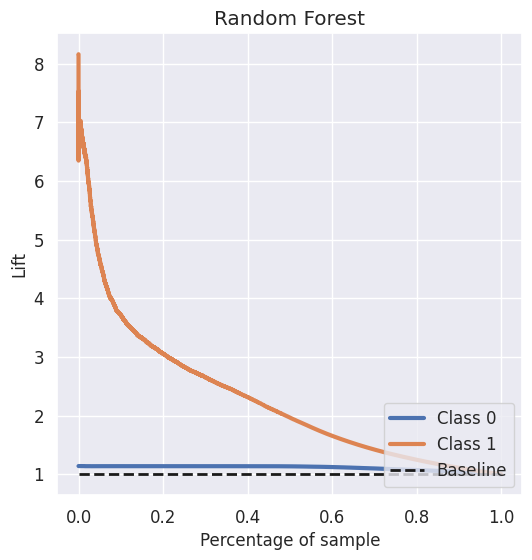

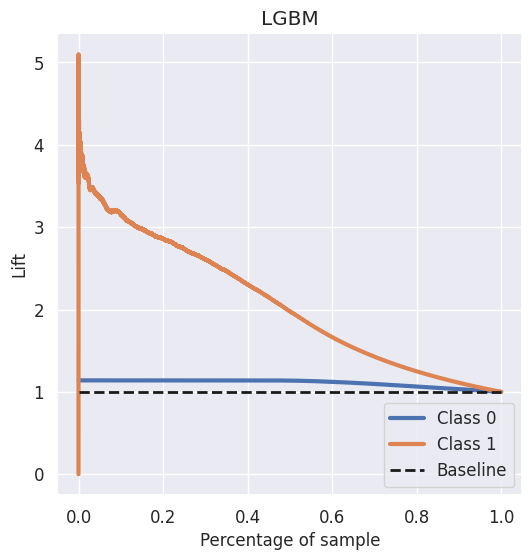

In [145]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_rf,figsize =(6,6),title='Random Forest');
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(6,6),title='LGBM');

## 10.5. Final Model

In [146]:
# pickle.dump(rf,open('../model/radomForestModel.pkl','wb'))
# pickle.dump(lgbm,open('../model/lgbm.pkl','wb'))
# print('Random Forest object size: {0:.2f} KB'.format(os.stat('../model/radomForestModel.pkl').st_size/1024))
# print('LGBM object size: {0:.2f} KB'.format(os.stat('../model/lgbm.pkl').st_size/1024))

In all scenarios above, Random Forest and LGBM had the best performance, but the Random Forest Model exported is **1521 times** bigger than LGBM model. So, I'll use the **LGBM Model** in production.

In [147]:
threshold=[0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9 ]
threshold_performance=pd.DataFrame()

for i in threshold:
    calc_threshold=lambda x: 0 if x <i else  1
    predicition=list(map(calc_threshold,yhat_proba_rf[:,1]))
    threshold_performance = pd.concat((threshold_performance, multi_class_metrics(i,y_test,predicition,0)))

In [148]:
threshold_performance

Index  Model  Precision Score  Recall Score  F1 Score  Matthew Correlation Score
0      0 0.1000           0.2915        0.9074    0.4412                     0.4046
0      0 0.2000           0.3407        0.7290    0.4644                     0.3966
0      0 0.2500           0.3674        0.6341    0.4652                     0.3867
0      0 0.3000           0.3951        0.5414    0.4568                     0.3734
0      0 0.3500           0.4240        0.4450    0.4342                     0.3531
0      0 0.4000           0.4577        0.3634    0.4051                     0.3355
0      0 0.5000           0.5574        0.2437    0.3392                     0.3155
0      0 0.6000           0.6812        0.1656    0.2664                     0.2985
0      0 0.7000           0.7916        0.0952    0.1699                     0.2495
0      0 0.8000           0.8469        0.0290    0.0561                     0.1434
0      0 0.9000           0.9091        0.0021    0.0043                     0.0408

I'll use the thershold 0.35

## 10.6. Busisness Performance

In the beginning of this job, the CEO of Insurance All made some questions about model's performance, now I'll respond all of them.

### 1 - Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

Customer between 30-50 have more interesting in vehicle Insurance.

Customer with newest cars, have more interesting in vehicle Insurance.

Customer in in some espefics region have more interesting in vehicle Insurance.

The Attributes more relevantes to define customer interesting are (previouslyInsured,annualPremium,vintage,age,regionCode,policySalesChannel,vehicleDamage

### 2 - Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
Made 20.000 calls using the model to ranking the customers, the sale team will call to 17,59% of all interested, about 3 more times that random method.

In [149]:
calls=20000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))

Insurance All total leads: 381109
Insurance All % of calls: 5.25%


In [150]:
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting

Model   perc     k  precision  recall  target_total  target_at_k  perc_target
0  Model 0.0525  4000     0.4106  0.1759          9342         1643       0.1759

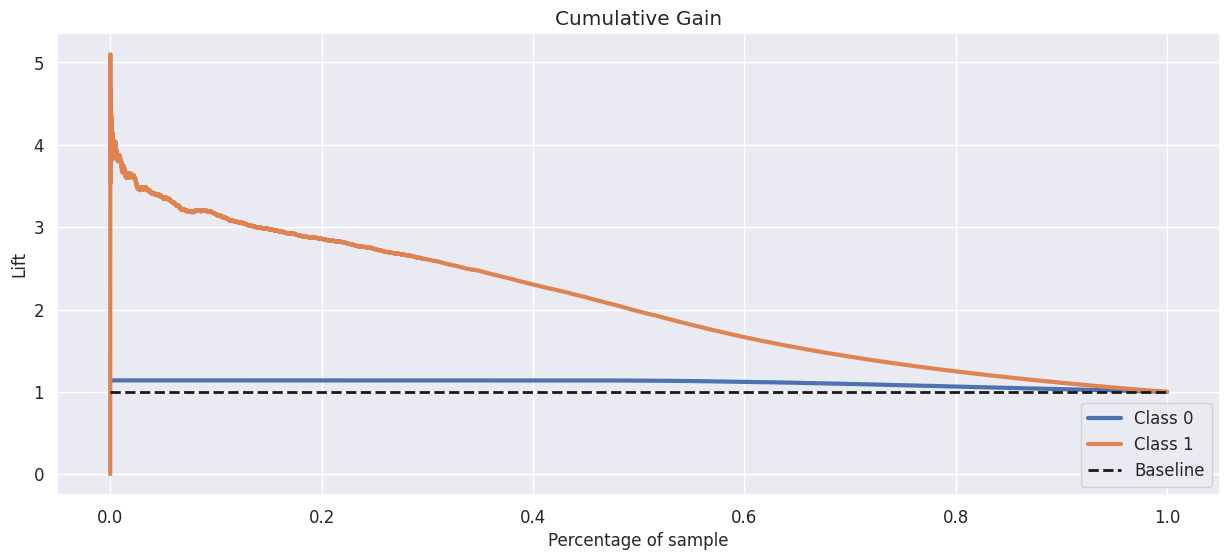

In [151]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

### 3 - E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
Made 40.000 calls using the model to ranking the customers, the sale team will call to 32,89% of all interested, about 3.13 more times that random method.

In [152]:
calls=40000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))

Insurance All total leads: 381109
Insurance All % of calls: 10.50%


In [153]:
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting

Model   perc     k  precision  recall  target_total  target_at_k  perc_target
0  Model 0.1050  8000     0.3842  0.3291          9342         3073       0.3289

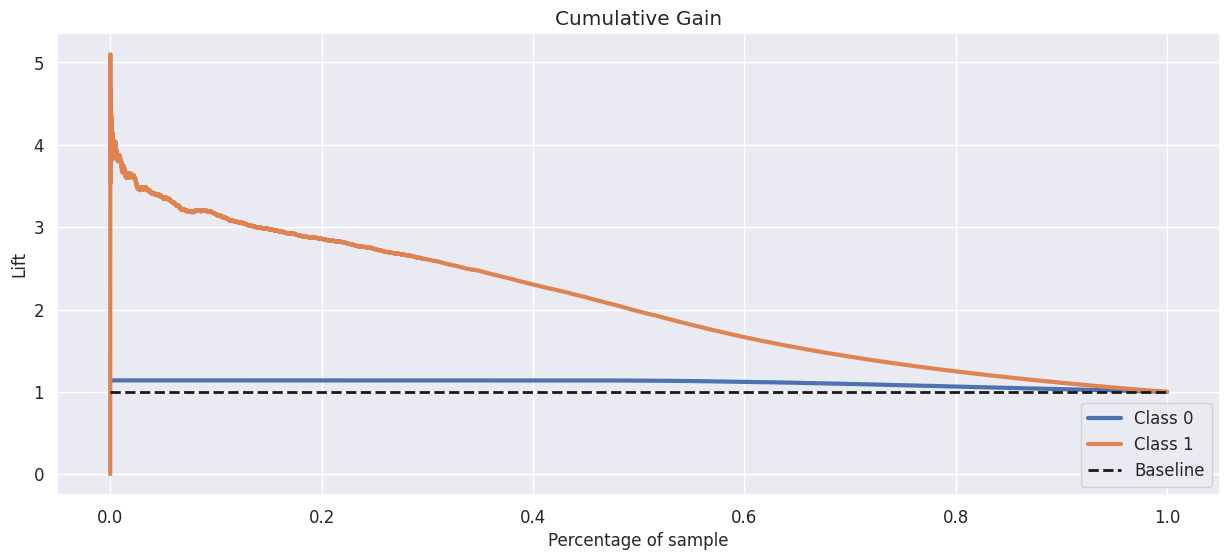

In [154]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

### 4 - Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

Should be necessary 117949 calls to call to 80% of interesting.

In [155]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

df_mp['score']=yhat_proba_lgbm[:,1].tolist()
df_mp=df_mp.sort_values('score',ascending=False)
df_mp=df_mp.reset_index(drop=True)
df_mp['ranking']=df_mp.index+1
df_mp['precision_at_k']=df_mp['response'].cumsum()/df_mp['ranking']
df_mp['recall_at_k']=df_mp['response'].cumsum()/df_mp['response'].sum()

In [156]:
df_mp[df_mp['ranking']==23590]

previouslyInsured  annualPremium  vintage    age  regionCode  policySalesChannel  vehicleDamage_No  vehicleDamage_Yes     id  response  score  ranking  precision_at_k  recall_at_k
23589             0.5423         2.2386   0.7232 0.0312      0.2795              0.1944                 0                  1  11063         1 0.2021    23590          0.3168       0.8000

In [157]:
percCalls=23590/len(df_mp)
qtdCalls=int(np.floor(len(df_test)*percCalls))
print('Should be necessary {} calls to call to 80% of interesting.'.format(qtdCalls))

Should be necessary 117949 calls to call to 80% of interesting.


### Model Result
**20,000 calls(5.25%)**

Suposing that each vehicle Insurance was sell at 2000, the mode bring 335% percent of result totalizing $2,305,493.

**40,000 calls(10.50%)**

Suposing that each vehicle Insurance was sell at 2000, the mode bring 313.4% percent of result totalizing $4,184,986.

In [158]:
calls=20000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting['R$ model']=customerInteresting['target_at_k']*2000
customerInteresting['target_random']=customerInteresting['perc']*customerInteresting['target_total']
customerInteresting['R$ random']=customerInteresting['target_random']*2000
customerInteresting['R$ Final']=customerInteresting['R$ model']-customerInteresting['R$ random']
customerInteresting['% Final']=customerInteresting['R$ model']/customerInteresting['R$ random']
customerInteresting

Insurance All total leads: 381109
Insurance All % of calls: 5.25%


Model   perc     k  precision  recall  target_total  target_at_k  perc_target  R$ model  target_random   R$ random     R$ Final  % Final
0  Model 0.0525  4000     0.4106  0.1759          9342         1643       0.1759   3286000       490.2534 980506.8891 2305493.1109   3.3513

In [159]:
calls=40000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting['R$ model']=customerInteresting['target_at_k']*2000
customerInteresting['target_random']=customerInteresting['perc']*customerInteresting['target_total']
customerInteresting['R$ random']=customerInteresting['target_random']*2000
customerInteresting['R$ Final']=customerInteresting['R$ model']-customerInteresting['R$ random']
customerInteresting['% Final']=customerInteresting['R$ model']/customerInteresting['R$ random']
customerInteresting

Insurance All total leads: 381109
Insurance All % of calls: 10.50%


Model   perc     k  precision  recall  target_total  target_at_k  perc_target  R$ model  target_random    R$ random     R$ Final  % Final
0  Model 0.1050  8000     0.3842  0.3291          9342         3073       0.3289   6146000       980.5069 1961013.7782 4184986.2218   3.1341

# 11.0. Model Production Deploy

In [ ]:
pickle.dump(lgbm,open('../model/lgbm.pkl','wb'))
pickle.dump(rs,open('../parameters/robustScaller.pkl','wb'))
pickle.dump(ohe,open('../parameters/oneHotEncoder.pkl','wb'))
pickle.dump(mms,open('../parameters/minMaxScaller.pkl','wb'))
pickle.dump(fe_regionCode,open('../parameters/fe_regionCode.pkl','wb'))
pickle.dump(fe_policySalesChannel,open('../parameters/fe_policySalesChannel.pkl','wb'))
pickle.dump(fe_drivingLicense,open('../parameters/fe_drivingLicense.pkl','wb'))
pickle.dump(fe_riskAge,open('../parameters/fe_riskAge.pkl','wb'))
pickle.dump(fe_previouslyInsured,open('../parameters/fe_previouslyInsured.pkl','wb'))
pickle.dump(cols_selected,open('../parameters/cols_selected.pkl','wb'))

## 10.6. Busisness Performance

In the beginning of this job, the CEO of Insurance All made some questions about model's performance, now I'll respond all of them.

## 11.1. Insurance All Class

In [8]:
import json
import pickle
import pandas as pd
import numpy as np

from sklearn.ensemble     import RandomForestClassifier
from sklearn              import preprocessing   as pp
from lightgbm             import LGBMClassifier
from sklearn              import metrics         as m
from category_encoders    import OneHotEncoder

class InsuranceAll (object):
    
    
    def __init__(self):
        self.rs=pickle.load(open ('../parameters/robustScaller.pkl','rb'))
        self.mms=pickle.load(open('../parameters/minMaxScaller.pkl','rb'))
        self.ohe=pickle.load(open('../parameters/oneHotEncoder.pkl','rb'))
        self.fe_regionCode=pickle.load(open('../parameters/fe_regionCode.pkl','rb'))
        self.fe_policySalesChannel=pickle.load(open('../parameters/fe_policySalesChannel.pkl','rb'))
        self.fe_drivingLicense=pickle.load(open('../parameters/fe_drivingLicense.pkl','rb'))
        self.fe_riskAge=pickle.load(open('../parameters/fe_riskAge.pkl','rb'))
        self.fe_previouslyInsured=pickle.load(open('../parameters/fe_previouslyInsured.pkl','rb'))
        self.cols_selected=pickle.load(open('../parameters/cols_selected.pkl','rb'))
    
    def dp_numericals(self,df):
        df['annualPremium']=self.rs.fit_transform(df[['annualPremium']])
        df['vintage']=self.mms.fit_transform(df[['vintage']])
        df['age']=self.mms.fit_transform(df[['age']])
        df['vintage']=self.mms.fit_transform(df[['vintage']])
        return df
        
    def data_cleanning(self,df):
        df.columns=['id','gender','age','drivingLicense','regionCode','previouslyInsured','vehicleAge','vehicleDamage','annualPremium','policySalesChannel','vintage']
        return df
                      
    def feature_engieneering(self,df):
        df['riskAge']=df['age'].apply(lambda x: 0 if x>25 else 1)
        return df
    
    def data_preparation(self,df):
        categorical_columns=df.select_dtypes(exclude=['int64','float64']).columns.tolist()
        df=self.dp_numericals(df)
        df=self.feature_engieneering(df)
        df['regionCode']=df['regionCode'].map(self.fe_regionCode)
        df['policySalesChannel']=df['policySalesChannel'].map(self.fe_policySalesChannel)
        df['drivingLicense']=df['drivingLicense'].map(self.fe_drivingLicense)
        df['riskAge']=df['riskAge'].map(self.fe_riskAge)
        df['previouslyInsured']=df['previouslyInsured'].map(self.fe_previouslyInsured)
        df=self.ohe.transform(df)
        df=df.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})
        df=df[self.cols_selected]
        df=df.fillna(0)
        return df

    def get_prediction(self,model,original_data,test_data):
        self.calc_threshold=lambda x: 0 if x < 0.35 else 1
        pred = model.predict_proba(test_data)
        original_data['prediction'] = pred[:,1]
        original_data=original_data.sort_values('prediction',ascending=False)
        original_data['prediction']= list(map(self.calc_threshold, original_data['prediction']))
        return original_data.to_json(orient='records', date_format='iso')                      

## 11.2. API Handler

In [9]:
import pickle
import pandas as pd
from flask import Flask,request,Response
#from insuranceAll.InsuranceAll import InsuranceAll

model = pickle.load(open('../model/lgbm.pkl','rb'))

app = Flask(__name__)
@app.route('/insuranceAll/predict',methods=['POST'])

def insurance_all_predict():
    test_json= request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):
            test_raw=pd.DataFrame(test_json,index=[0])
        else:
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
               
        pipeline = InsuranceAll()
        df = test_raw.copy()
        df = pipeline.data_cleanning(df)
        df = pipeline.feature_engieneering(df)
        df = pipeline.data_preparation(df)
        df_response = pipeline.get_prediction(model,test_raw,df)
        return df_response
    
    else:
        return Response('{}', status=200,mimetype='application/json')

    
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Feb/2021 16:19:24] "POST /insuranceAll/predict HTTP/1.1" 200 -
